In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import subprocess
import threading

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [7]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [9]:
# 定期采样GPU使用情况的函数
def sample_gpu_usage(interval, gpu_usage_list, stop_event, gpu_index): #interval是采样间隔时间
    while not stop_event.is_set():
        gpu_usage = subprocess.check_output(
            ['nvidia-smi', '-i', str(gpu_index), '--query-gpu=utilization.gpu,memory.used', '--format=csv,noheader,nounits']
        ).decode('utf-8').strip().split('\n')[0].split(', ')
        gpu_usage = [int(x) for x in gpu_usage]
        gpu_usage_list.append(gpu_usage)
        time.sleep(interval)

# 模拟训练函数
def train_model(model, Iter, sample_interval=1, gpu_index=1): #这里gpu_index代表GPU的索引，sample_interval代表采样间隔时间几s
    # 用于存储GPU使用情况的列表
    gpu_usage_list = []
    stop_event = threading.Event()

    # 启动一个线程定期采样GPU使用情况
    sampling_thread = threading.Thread(target=sample_gpu_usage, args=(sample_interval, gpu_usage_list, stop_event, gpu_index))
    sampling_thread.start()

    start_time = time.time()  # 获取当前时间
    # 训练模型
    model.train(Iter)
    end_time = time.time() # 获取当前时间
    training_time = end_time - start_time # 计算训练时间

    # 停止采样线程
    stop_event.set()
    sampling_thread.join()

    # 计算平均GPU使用情况
    avg_gpu_usage = np.mean(gpu_usage_list, axis=0)

    return training_time, avg_gpu_usage

In [ ]:
#basic PINN
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 200

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

PINN_training_time = [] #创建一个空列表，用于存储PINN训练时间
GPU_usage = [] #创建一个空列表，用于存储GPU使用率
GPU_memory = [] #创建一个空列表，用于存储GPU显存占用

i = 0 #初始化i为0



for seed in seeds:
    set_seed(seed) #设置随机数种子

    X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个随机点
    # X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)
    #开始训练


    training_time, avg_gpu_usage = train_model(model, Iter = nIter, sample_interval=1)
    print(f"训练时间: {training_time:.2f} 秒")
    print(f"平均GPU使用率: {avg_gpu_usage[0]:.2f}%")
    print(f"平均GPU显存使用量: {avg_gpu_usage[1]:.2f}MiB")

    PINN_training_time.append(training_time)
    GPU_usage.append(avg_gpu_usage[0])
    GPU_memory.append(avg_gpu_usage[1])

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')

    
    


In [11]:
#普通PINN
# 打印PINN训练时间
print(f'PINN训练时间为{[f"{traingtime}%" for traingtime in PINN_training_time]}s')
# 打印平均PINN训练时间
print(f'平均PINN训练时间为{np.mean(PINN_training_time):.2f}s')

# 打印GPU使用率
print(f'GPU使用率为{[f"{usage}%" for usage in GPU_usage]}')
# 打印平均GPU使用率
print(f'平均GPU使用率为{np.mean(GPU_usage):.2f}%')

# 打印GPU显存使用率
print(f'GPU显存使用为{[f"{memory}MiB" for memory in GPU_memory]}')
# 打印平均GPU显存使用率
print(f'平均GPU显存使用为{np.mean(GPU_memory):.2f}MiB')

PINN训练时间为['111.31816172599792%', '108.17176628112793%', '111.023202419281%', '111.3482506275177%', '108.8461844921112%', '109.4990291595459%', '109.4466381072998%', '110.73111653327942%', '108.43356728553772%', '109.00051522254944%']s
平均PINN训练时间为109.78s
GPU使用率为['50.09345794392523%', '51.46153846153846%', '50.046728971962615%', '49.570093457943926%', '50.76190476190476%', '51.0188679245283%', '50.839622641509436%', '50.242990654205606%', '51.076190476190476%', '50.923809523809524%']
平均GPU使用率为50.60%
GPU显存使用为['589.2803738317757MiB', '609.0MiB', '609.0MiB', '609.0MiB', '609.0MiB', '609.0MiB', '609.0MiB', '609.0MiB', '609.0MiB', '609.0MiB']
平均GPU显存使用为607.03MiB


80000
[1.9659576e-01 1.6751269e-01 1.4022291e-01 ... 1.4151237e-09 1.4151067e-09
 1.4150903e-09]


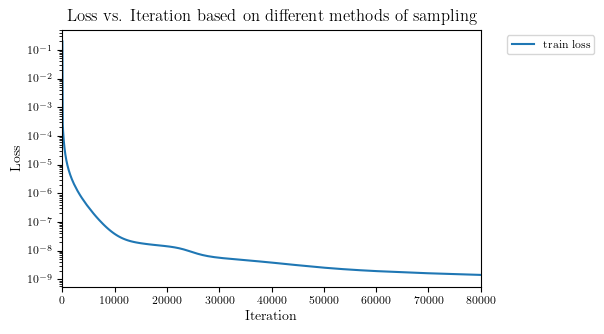

In [12]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,150000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

In [ ]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 200

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点


PINN_training_time = [] #创建一个空列表，用于存储PINN训练时间
GPU_usage = [] #创建一个空列表，用于存储GPU使用率
GPU_memory = [] #创建一个空列表，用于存储GPU显存占用


i = 0 #初始化i为0


for seed in seeds:
    set_seed(seed) #设置随机数种子

    timeused = [] #创建一个空列表，用于存储时间
    Usage = [] #创建一个空列表，用于存储使用率
    Memory = [] #创建一个空列表，用于存储显存占用


    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)


    training_time, avg_gpu_usage = train_model(model, nIter//100)

    timeused.append(training_time)
    Usage.append(avg_gpu_usage[0])
    Memory.append(avg_gpu_usage[1])


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = abs_residual + chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        # model.train(nIter//100,0)
        training_time, avg_gpu_usage = train_model(model, nIter//100)

        timeused.append(training_time)
        Usage.append(avg_gpu_usage[0])
        Memory.append(avg_gpu_usage[1])

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)


    training_time = sum(timeused)
    avg_gpu_usage = [np.mean(Usage), np.mean(Memory)]
    print(f"训练时间: {training_time:.2f} 秒")
    print(f"平均GPU使用率: {avg_gpu_usage[0]:.2f}%")
    print(f"平均GPU显存使用: {avg_gpu_usage[1]:.2f}MiB")

    PINN_training_time.append(training_time)
    GPU_usage.append(avg_gpu_usage[0])
    GPU_memory.append(avg_gpu_usage[1])

    

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')


In [14]:
#fuhe PINN
# 打印PINN训练时间
print(f'PINN训练时间为{[f"{traingtime}%" for traingtime in PINN_training_time]}s')
# 打印平均PINN训练时间
print(f'平均PINN训练时间为{np.mean(PINN_training_time):.2f}s')

# 打印GPU使用率
print(f'GPU使用率为{[f"{usage}%" for usage in GPU_usage]}')
# 打印平均GPU使用率
print(f'平均GPU使用率为{np.mean(GPU_usage):.2f}%')

# 打印GPU显存使用率
print(f'GPU显存使用为{[f"{memory}MiB" for memory in GPU_memory]}')
# 打印平均GPU显存使用率
print(f'平均GPU显存使用为{np.mean(GPU_memory):.2f}MiB')



PINN训练时间为['115.80553531646729%', '114.29670834541321%', '115.17911338806152%', '115.38664174079895%', '114.25273942947388%', '115.7835795879364%', '117.80080366134644%', '115.51872372627258%', '115.38215708732605%', '116.0473701953888%']s
平均PINN训练时间为115.55s
GPU使用率为['22.53%', '22.62%', '22.625%', '22.235%', '23.195%', '22.57%', '22.41%', '22.925%', '22.555%', '22.735%']
平均GPU使用率为22.64%
GPU显存使用为['615.84MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB']
平均GPU显存使用为627.68MiB


80000
[1.9658238e-01 1.6749299e-01 1.4019865e-01 ... 2.2374209e-09 2.2373823e-09
 2.2373450e-09]


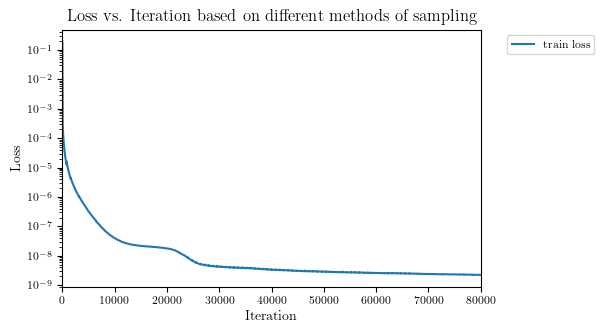

In [15]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,150000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

In [16]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 200

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点


PINN_training_time = [] #创建一个空列表，用于存储PINN训练时间
GPU_usage = [] #创建一个空列表，用于存储GPU使用率
GPU_memory = [] #创建一个空列表，用于存储GPU显存占用


i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子

    timeused = [] #创建一个空列表，用于存储时间
    Usage = [] #创建一个空列表，用于存储使用率
    Memory = [] #创建一个空列表，用于存储显存占用

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f = lb + (ub - lb) * lhs(1, N_f*2) #生成N_f个随机点
    indices = np.arange(X_f.shape[0])
    id = np.random.choice(indices, N_f_1, replace=False) #从indices中随机选择10个数，replace=False表示不允许重复选择，最后将这10个数赋值给id，代表训练过的数据索引
    X_f_train = X_f[id, :] #从X_f_train中选取id对应的的10行，赋值给X_f_train


    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #开始训练模型            
    # model.train(nIter//100,0)
    training_time, avg_gpu_usage = train_model(model, nIter//100)

    timeused.append(training_time)
    Usage.append(avg_gpu_usage[0])
    Memory.append(avg_gpu_usage[1])

    #删除已经训练过的数据的索引
    indices = np.setdiff1d(indices, id) #从indices中去除id中的元素，最后将结果赋值给indices


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 #重新采样500个点
        # 生成新的X_f_train数据
        id = np.random.choice(indices, N_f_new, replace=False) #从indices中随机选择N_f_new个数，replace=False表示不允许重复选择，最后将这N_f_new个数赋值给id，代表训练过的数据索引

        X_f_train_new = X_f[id, :] #从X_f_train中选取id对应的的N_f_new行，赋值给X_f_train_new

        X_f_train = np.vstack((X_f_train, X_f_train_new)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        # model.train(nIter//100,0)
        training_time, avg_gpu_usage = train_model(model, nIter//100)

        timeused.append(training_time)
        Usage.append(avg_gpu_usage[0])
        Memory.append(avg_gpu_usage[1])

        # 删除已经训练过的数据的索引
        indices = np.setdiff1d(indices, id)


    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    timeused.append(training_time)
    Usage.append(avg_gpu_usage[0])
    Memory.append(avg_gpu_usage[1])

    training_time = sum(timeused)
    avg_gpu_usage = [np.mean(Usage), np.mean(Memory)]
    print(f"训练时间: {training_time:.2f} 秒")
    print(f"平均GPU使用率: {avg_gpu_usage[0]:.2f}%")
    print(f"平均GPU显存使用: {avg_gpu_usage[1]:.2f}MiB")

    PINN_training_time.append(training_time)
    GPU_usage.append(avg_gpu_usage[0])
    GPU_memory.append(avg_gpu_usage[1])


    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')



Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   8%|▊         | 66/800 [00:00<00:01, 657.82it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:01, 642.15it/s]


Adam:  27%|██▋       | 213/800 [00:00<00:00, 717.55it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 689.43it/s]


Adam:  45%|████▌     | 362/800 [00:00<00:00, 715.75it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 738.06it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 723.18it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 739.33it/s]


Adam:  84%|████████▎ | 668/800 [00:00<00:00, 704.60it/s]


Adam:  93%|█████████▎| 746/800 [00:01<00:00, 724.40it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 398.41it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 533.58it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 612.75it/s]


Adam:  30%|██▉       | 238/800 [00:00<00:00, 616.10it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 656.60it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 699.18it/s]


Adam:  58%|█████▊    | 463/800 [00:00<00:00, 708.52it/s]


Adam:  68%|██████▊   | 541/800 [00:00<00:00, 729.33it/s]


Adam:  77%|███████▋  | 619/800 [00:00<00:00, 744.66it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 758.37it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 730.47it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 688.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 165.54it/s]


Adam:  10%|█         | 84/800 [00:00<00:01, 457.80it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 579.17it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:00, 651.44it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 699.46it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 724.19it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 687.74it/s]


Adam:  68%|██████▊   | 542/800 [00:00<00:00, 713.77it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 734.24it/s]


Adam:  87%|████████▋ | 695/800 [00:01<00:00, 732.00it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 737.04it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.35it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 115.72it/s]


Adam:   6%|▌         | 47/800 [00:00<00:03, 250.54it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 473.10it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:01, 527.99it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 574.34it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 649.42it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 561.98it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 609.02it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 645.54it/s]


Adam:  78%|███████▊  | 621/800 [00:01<00:00, 682.96it/s]


Adam:  87%|████████▋ | 693/800 [00:01<00:00, 691.64it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 721.66it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 617.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 426.63it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 559.61it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 650.22it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 665.63it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 700.51it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 730.62it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 714.10it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 724.98it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 734.10it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 748.92it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 759.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.62it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 246.38it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 470.59it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 622.00it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 690.71it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 635.79it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 659.01it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 699.70it/s]


Adam:  68%|██████▊   | 545/800 [00:00<00:00, 716.39it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 734.87it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 756.17it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 763.78it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.08it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 337.99it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 549.01it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:00, 630.64it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 687.18it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 724.34it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 741.23it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 725.36it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 674.26it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 659.06it/s]


Adam:  89%|████████▊ | 709/800 [00:01<00:00, 694.91it/s]


Adam:  98%|█████████▊| 780/800 [00:01<00:00, 661.19it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 669.69it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.38it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 495.90it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 599.80it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 673.35it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 630.74it/s]


Adam:  47%|████▋     | 377/800 [00:00<00:00, 609.29it/s]


Adam:  57%|█████▋    | 457/800 [00:00<00:00, 667.40it/s]


Adam:  67%|██████▋   | 533/800 [00:00<00:00, 694.82it/s]


Adam:  77%|███████▋  | 614/800 [00:00<00:00, 728.90it/s]


Adam:  87%|████████▋ | 693/800 [00:01<00:00, 746.57it/s]


Adam:  96%|█████████▌| 769/800 [00:01<00:00, 746.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 666.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 167.45it/s]


Adam:  10%|▉         | 79/800 [00:00<00:01, 430.63it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:01, 591.92it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:00, 650.09it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 594.88it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 622.43it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 613.84it/s]


Adam:  64%|██████▍   | 510/800 [00:00<00:00, 666.28it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 695.11it/s]


Adam:  83%|████████▎ | 665/800 [00:01<00:00, 718.47it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 726.23it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 655.66it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   1%|▏         | 11/800 [00:00<00:07, 104.97it/s]


Adam:   9%|▉         | 75/800 [00:00<00:01, 410.98it/s]


Adam:  18%|█▊        | 144/800 [00:00<00:01, 535.06it/s]


Adam:  28%|██▊       | 224/800 [00:00<00:00, 637.59it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 693.70it/s]


Adam:  47%|████▋     | 376/800 [00:00<00:00, 700.93it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 725.65it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 724.06it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 734.59it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 734.06it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 717.38it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 359.15it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 599.40it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 679.76it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 718.09it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 708.58it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 731.39it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 752.53it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 754.64it/s]


Adam:  82%|████████▏ | 655/800 [00:00<00:00, 768.36it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 771.70it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 726.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 467.75it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 653.61it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:00, 702.99it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 735.46it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 718.35it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 718.89it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 722.41it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 744.25it/s]


Adam:  82%|████████▏ | 658/800 [00:00<00:00, 750.30it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 757.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 644.63it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.62it/s]


Adam:   6%|▌         | 46/800 [00:00<00:03, 231.04it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 409.41it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:01, 529.61it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 627.78it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 632.88it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 681.93it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 715.14it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 741.09it/s]


Adam:  81%|████████  | 645/800 [00:01<00:00, 757.07it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 740.07it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 751.54it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:02, 259.52it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 564.06it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 624.05it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 691.42it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 727.45it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 754.23it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 714.31it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 694.37it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 655.72it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 623.88it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 658.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 188.49it/s]


Adam:   7%|▋         | 56/800 [00:00<00:02, 293.06it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:01, 509.40it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 602.16it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 663.87it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 687.49it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 725.59it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 704.23it/s]


Adam:  74%|███████▍  | 594/800 [00:00<00:00, 732.09it/s]


Adam:  84%|████████▍ | 673/800 [00:01<00:00, 749.34it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 758.66it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 376.02it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 611.94it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 694.35it/s]


Adam:  34%|███▍      | 275/800 [00:00<00:00, 729.93it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 712.62it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 710.96it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 708.07it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 702.61it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 709.12it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 647.97it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 687.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 685.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 179.01it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 512.98it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 545.34it/s]


Adam:  27%|██▋       | 216/800 [00:00<00:01, 580.71it/s]


Adam:  36%|███▌      | 287/800 [00:00<00:00, 626.42it/s]


Adam:  44%|████▍     | 350/800 [00:00<00:00, 619.78it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 669.33it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 685.95it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 710.45it/s]


Adam:  81%|████████▏ | 650/800 [00:01<00:00, 699.81it/s]


Adam:  91%|█████████ | 727/800 [00:01<00:00, 720.68it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.47it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.27it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 227.78it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 480.82it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 556.38it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:00, 655.39it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 691.75it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 716.96it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 739.83it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 747.24it/s]


Adam:  77%|███████▋  | 619/800 [00:00<00:00, 740.67it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 754.67it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 762.95it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 467.64it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 655.24it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 726.58it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 741.31it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 765.77it/s]


Adam:  56%|█████▌    | 445/800 [00:00<00:00, 773.32it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 779.92it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 745.23it/s]


Adam:  85%|████████▌ | 681/800 [00:00<00:00, 753.58it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 763.14it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 747.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 304.82it/s]


Adam:   8%|▊         | 65/800 [00:00<00:02, 325.16it/s]


Adam:  17%|█▋        | 139/800 [00:00<00:01, 513.75it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:01, 577.94it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 627.15it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 680.81it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 713.03it/s]


Adam:  64%|██████▍   | 516/800 [00:00<00:00, 737.79it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 746.06it/s]


Adam:  84%|████████▎ | 668/800 [00:01<00:00, 725.09it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 691.85it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 661.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 375.32it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 532.33it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 520.13it/s]


Adam:  28%|██▊       | 228/800 [00:00<00:00, 591.54it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 661.47it/s]


Adam:  48%|████▊     | 382/800 [00:00<00:00, 688.61it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 680.10it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 712.49it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 738.56it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 712.92it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 709.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.03it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 419.30it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 599.70it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 642.61it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 642.22it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 623.04it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 663.80it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 681.63it/s]


Adam:  68%|██████▊   | 541/800 [00:00<00:00, 713.00it/s]


Adam:  77%|███████▋  | 618/800 [00:00<00:00, 728.55it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 720.37it/s]


Adam:  96%|█████████▌| 769/800 [00:01<00:00, 737.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 688.99it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 117.26it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 403.89it/s]


Adam:  19%|█▉        | 150/800 [00:00<00:01, 566.75it/s]


Adam:  29%|██▊       | 229/800 [00:00<00:00, 653.82it/s]


Adam:  38%|███▊      | 306/800 [00:00<00:00, 693.79it/s]


Adam:  47%|████▋     | 376/800 [00:00<00:00, 678.00it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 709.02it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 729.35it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 728.73it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 745.99it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 752.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 388.99it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 535.26it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 631.37it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 666.17it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 705.73it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 725.85it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 731.06it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 699.65it/s]


Adam:  79%|███████▉  | 632/800 [00:00<00:00, 722.26it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 737.26it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 751.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 224.76it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 497.93it/s]


Adam:  21%|██        | 168/800 [00:00<00:01, 607.56it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 674.02it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 706.62it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 706.69it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 735.03it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 753.31it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 764.53it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 749.43it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 754.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.75it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 455.30it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 632.84it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 668.29it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 679.25it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 686.35it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 716.27it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 716.91it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 732.46it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 731.51it/s]


Adam:  89%|████████▉ | 712/800 [00:01<00:00, 741.29it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 753.58it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 714.06it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 436.21it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 582.41it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 634.84it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 655.91it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 686.97it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 710.02it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 727.39it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 739.72it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 721.47it/s]


Adam:  89%|████████▊ | 709/800 [00:01<00:00, 738.06it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 746.77it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 705.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 49/800 [00:00<00:01, 489.10it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 653.53it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:00, 700.86it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 705.57it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 718.79it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 720.65it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 734.61it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 742.66it/s]


Adam:  81%|████████▏ | 651/800 [00:00<00:00, 731.10it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 740.12it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 721.80it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 443.47it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 548.90it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 639.13it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 682.58it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 619.96it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 639.95it/s]


Adam:  59%|█████▉    | 470/800 [00:00<00:00, 668.53it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 697.13it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 715.36it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 728.78it/s]


Adam:  97%|█████████▋| 776/800 [00:01<00:00, 738.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 477.99it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 615.15it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 664.54it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 669.61it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 692.30it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 705.40it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 727.67it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 739.39it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 745.99it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 748.31it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 743.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 710.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.93it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 579.93it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 672.59it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 723.51it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 709.68it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 707.28it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 732.10it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 749.89it/s]


Adam:  81%|████████  | 648/800 [00:00<00:00, 760.52it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 770.12it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 723.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 369.19it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 571.55it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 666.28it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 689.53it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 725.46it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 743.37it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 759.04it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 766.79it/s]


Adam:  82%|████████▏ | 653/800 [00:00<00:00, 753.20it/s]


Adam:  91%|█████████ | 729/800 [00:01<00:00, 743.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 444.71it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 634.00it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 698.78it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 735.08it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 648.51it/s]


Adam:  54%|█████▍    | 433/800 [00:00<00:00, 690.67it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 720.67it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 740.11it/s]


Adam:  84%|████████▎ | 669/800 [00:00<00:00, 751.08it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 762.95it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 526.67it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 655.56it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 717.71it/s]


Adam:  36%|███▌      | 287/800 [00:00<00:00, 742.79it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 757.74it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 713.74it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 702.19it/s]


Adam:  74%|███████▍  | 590/800 [00:00<00:00, 717.76it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 699.30it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 689.38it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 207.00it/s]


Adam:   9%|▉         | 71/800 [00:00<00:01, 375.51it/s]


Adam:  18%|█▊        | 140/800 [00:00<00:01, 518.05it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:01, 494.34it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 561.89it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 594.46it/s]


Adam:  50%|████▉     | 397/800 [00:00<00:00, 625.76it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 670.69it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 703.82it/s]


Adam:  78%|███████▊  | 628/800 [00:01<00:00, 717.54it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 732.71it/s]


Adam:  97%|█████████▋| 779/800 [00:01<00:00, 723.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 638.85it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 386.72it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 627.66it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 705.37it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 710.05it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 683.16it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 659.75it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 606.54it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 638.15it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 654.36it/s]


Adam:  87%|████████▋ | 697/800 [00:01<00:00, 682.91it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 710.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 671.56it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 309.32it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 590.52it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 682.56it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 698.34it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 722.16it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 747.77it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 753.19it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 712.76it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 667.90it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 697.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.28it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.28it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 501.34it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:01, 572.36it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 655.65it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 706.61it/s]


Adam:  50%|████▉     | 397/800 [00:00<00:00, 737.60it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 752.35it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 734.81it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 748.07it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 754.45it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 762.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 316.56it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 510.76it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 630.08it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 694.70it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 731.03it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 744.12it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 754.84it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 737.80it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 716.74it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 729.49it/s]


Adam:  99%|█████████▉| 790/800 [00:01<00:00, 732.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 704.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 113.76it/s]


Adam:   3%|▎         | 24/800 [00:00<00:07, 108.09it/s]


Adam:   6%|▌         | 45/800 [00:00<00:05, 148.52it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:02, 306.56it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 422.42it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:01, 503.59it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 579.09it/s]


Adam:  48%|████▊     | 384/800 [00:00<00:00, 636.86it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 672.88it/s]


Adam:  67%|██████▋   | 537/800 [00:01<00:00, 700.63it/s]


Adam:  76%|███████▌  | 608/800 [00:01<00:00, 696.90it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 716.20it/s]


Adam:  95%|█████████▍| 759/800 [00:01<00:00, 721.09it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 575.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 247.77it/s]


Adam:   6%|▋         | 50/800 [00:00<00:03, 204.90it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:02, 292.22it/s]


Adam:  21%|██        | 168/800 [00:00<00:01, 463.32it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 559.27it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 607.89it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 651.50it/s]


Adam:  58%|█████▊    | 466/800 [00:00<00:00, 687.57it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 697.24it/s]


Adam:  76%|███████▋  | 611/800 [00:01<00:00, 706.29it/s]


Adam:  86%|████████▌ | 689/800 [00:01<00:00, 726.02it/s]


Adam:  96%|█████████▌| 767/800 [00:01<00:00, 740.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 621.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 328.18it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 467.47it/s]


Adam:  17%|█▋        | 138/800 [00:00<00:01, 471.93it/s]


Adam:  27%|██▋       | 213/800 [00:00<00:01, 580.74it/s]


Adam:  36%|███▌      | 288/800 [00:00<00:00, 639.85it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 688.72it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 688.19it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 697.67it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 718.69it/s]


Adam:  82%|████████▎ | 660/800 [00:01<00:00, 727.64it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 732.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 477.70it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 646.56it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:00, 701.13it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 726.59it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 747.04it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 764.35it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 726.90it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 730.27it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 714.29it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 713.68it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 717.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 169.80it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 399.20it/s]


Adam:  18%|█▊        | 147/800 [00:00<00:01, 553.09it/s]


Adam:  27%|██▋       | 219/800 [00:00<00:00, 618.43it/s]


Adam:  37%|███▋      | 297/800 [00:00<00:00, 676.43it/s]


Adam:  47%|████▋     | 374/800 [00:00<00:00, 707.90it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 728.48it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 740.29it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 745.25it/s]


Adam:  85%|████████▌ | 680/800 [00:01<00:00, 745.15it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 724.34it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.68it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 55/800 [00:00<00:01, 547.82it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 654.31it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:00, 704.27it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 701.18it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 692.93it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 697.85it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 701.23it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 720.45it/s]


Adam:  80%|███████▉  | 639/800 [00:00<00:00, 722.34it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 731.38it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 717.79it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 705.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.02it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 478.76it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 604.85it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:00, 639.60it/s]


Adam:  38%|███▊      | 303/800 [00:00<00:00, 656.76it/s]


Adam:  46%|████▌     | 369/800 [00:00<00:00, 593.30it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 615.52it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 657.41it/s]


Adam:  74%|███████▍  | 590/800 [00:00<00:00, 692.07it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 711.33it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 726.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.93it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 389.93it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 600.61it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 635.07it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 681.33it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 713.66it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 719.72it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 715.35it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 728.13it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 722.34it/s]


Adam:  89%|████████▊ | 709/800 [00:01<00:00, 738.12it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 715.09it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 329.51it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 578.42it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 670.63it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 666.46it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 705.77it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 732.03it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 696.05it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 710.28it/s]


Adam:  80%|███████▉  | 639/800 [00:00<00:00, 728.42it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 731.40it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 691.04it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 55/800 [00:00<00:01, 543.59it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:00, 675.31it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 717.11it/s]


Adam:  36%|███▌      | 287/800 [00:00<00:00, 736.28it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 721.28it/s]


Adam:  54%|█████▍    | 435/800 [00:00<00:00, 727.27it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 729.90it/s]


Adam:  73%|███████▎  | 586/800 [00:00<00:00, 740.56it/s]


Adam:  83%|████████▎ | 661/800 [00:00<00:00, 739.41it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 746.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.30it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 207.86it/s]


Adam:  10%|█         | 84/800 [00:00<00:01, 453.76it/s]


Adam:  19%|█▉        | 151/800 [00:00<00:01, 551.62it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:01, 580.95it/s]


Adam:  37%|███▋      | 293/800 [00:00<00:00, 655.92it/s]


Adam:  46%|████▋     | 370/800 [00:00<00:00, 692.85it/s]


Adam:  56%|█████▋    | 450/800 [00:00<00:00, 725.25it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 730.92it/s]


Adam:  75%|███████▌  | 602/800 [00:00<00:00, 742.60it/s]


Adam:  85%|████████▌ | 680/800 [00:01<00:00, 753.29it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 751.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.93it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 143.60it/s]


Adam:   8%|▊         | 62/800 [00:00<00:02, 331.83it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 479.03it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:00, 598.48it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 657.27it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 691.57it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 715.81it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 696.72it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 714.29it/s]


Adam:  82%|████████▏ | 659/800 [00:01<00:00, 720.59it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 733.90it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 658.85it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 199.22it/s]


Adam:  12%|█▏        | 94/800 [00:00<00:01, 513.20it/s]


Adam:  21%|██▏       | 170/800 [00:00<00:01, 624.99it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 641.73it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 649.16it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 678.94it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 701.78it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 725.08it/s]


Adam:  76%|███████▌  | 609/800 [00:00<00:00, 741.09it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 715.14it/s]


Adam:  95%|█████████▌| 761/800 [00:01<00:00, 730.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 523.84it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 635.78it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 705.23it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 734.24it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 724.81it/s]


Adam:  54%|█████▍    | 433/800 [00:00<00:00, 738.87it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 728.03it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 731.23it/s]


Adam:  82%|████████▏ | 659/800 [00:00<00:00, 745.74it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 753.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 729.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 377.46it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 524.60it/s]


Adam:  22%|██▏       | 179/800 [00:00<00:00, 640.51it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 666.51it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 683.83it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 714.88it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 740.16it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 745.69it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 750.58it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 759.23it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 752.23it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 709.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 474.92it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 666.89it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 730.38it/s]


Adam:  36%|███▋      | 291/800 [00:00<00:00, 759.36it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 733.05it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 709.23it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 737.00it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 756.39it/s]


Adam:  85%|████████▍ | 678/800 [00:00<00:00, 757.69it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 768.51it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 732.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 153.81it/s]


Adam:  10%|█         | 82/800 [00:00<00:01, 446.68it/s]


Adam:  20%|██        | 161/800 [00:00<00:01, 601.33it/s]


Adam:  29%|██▉       | 230/800 [00:00<00:00, 632.98it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 694.32it/s]


Adam:  49%|████▉     | 392/800 [00:00<00:00, 731.24it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 754.32it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 764.27it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 768.73it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 760.92it/s]


Adam:  98%|█████████▊| 785/800 [00:01<00:00, 766.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.71it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 324.85it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 575.26it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 678.82it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 712.61it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 743.77it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 763.65it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 773.31it/s]


Adam:  73%|███████▎  | 586/800 [00:00<00:00, 757.67it/s]


Adam:  83%|████████▎ | 664/800 [00:00<00:00, 764.10it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 768.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 728.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 297.67it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 548.46it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 660.94it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 716.36it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 746.64it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 753.01it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 758.92it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 768.48it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 768.63it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 778.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 735.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 188.49it/s]


Adam:   6%|▌         | 47/800 [00:00<00:03, 242.09it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 450.52it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:01, 587.23it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 659.93it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 691.86it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 677.60it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 707.26it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 727.38it/s]


Adam:  82%|████████▏ | 658/800 [00:01<00:00, 749.14it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 753.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 201.73it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 475.13it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 621.45it/s]


Adam:  31%|███       | 248/800 [00:00<00:00, 687.12it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 700.22it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 713.32it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 734.29it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 745.74it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 760.05it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 719.34it/s]


Adam:  98%|█████████▊| 785/800 [00:01<00:00, 733.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:04, 194.70it/s]


Adam:   7%|▋         | 58/800 [00:00<00:02, 302.21it/s]


Adam:  17%|█▋        | 136/800 [00:00<00:01, 515.92it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:01, 582.18it/s]


Adam:  35%|███▌      | 283/800 [00:00<00:00, 651.49it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 691.87it/s]


Adam:  55%|█████▌    | 440/800 [00:00<00:00, 723.35it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 737.20it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 751.69it/s]


Adam:  84%|████████▍ | 672/800 [00:01<00:00, 735.49it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 749.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 366.76it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 450.50it/s]


Adam:  20%|██        | 161/800 [00:00<00:01, 575.19it/s]


Adam:  29%|██▊       | 229/800 [00:00<00:00, 615.02it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 663.00it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 678.18it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 707.38it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 722.93it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 739.14it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 707.62it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 728.73it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 143.41it/s]


Adam:   6%|▌         | 46/800 [00:00<00:03, 238.76it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 466.89it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:01, 566.25it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 632.53it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 674.12it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 642.93it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 657.11it/s]


Adam:  69%|██████▊   | 549/800 [00:00<00:00, 654.41it/s]


Adam:  77%|███████▋  | 615/800 [00:01<00:00, 651.38it/s]


Adam:  86%|████████▌ | 688/800 [00:01<00:00, 674.87it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 579.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 585.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 322.92it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 499.90it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 592.72it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 630.07it/s]


Adam:  38%|███▊      | 302/800 [00:00<00:00, 638.62it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 636.80it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 625.06it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 648.23it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 677.45it/s]


Adam:  80%|████████  | 643/800 [00:01<00:00, 671.42it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 606.49it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 648.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 628.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 355.91it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 461.25it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 607.18it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 631.49it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 656.79it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 651.36it/s]


Adam:  55%|█████▍    | 439/800 [00:00<00:00, 653.17it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 677.21it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 668.98it/s]


Adam:  81%|████████▏ | 650/800 [00:01<00:00, 676.02it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 695.86it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 703.60it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 438.21it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 623.73it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 652.04it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 683.09it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 699.79it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 708.37it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 704.79it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 705.59it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 725.13it/s]


Adam:  88%|████████▊ | 702/800 [00:01<00:00, 729.69it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 693.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 691.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 303.23it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 535.03it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 565.21it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 631.18it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 683.11it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 700.60it/s]


Adam:  58%|█████▊    | 463/800 [00:00<00:00, 709.55it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 651.03it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 691.07it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 711.93it/s]


Adam:  96%|█████████▌| 769/800 [00:01<00:00, 732.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 677.34it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 356.78it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 606.13it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 684.04it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 671.01it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 680.17it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 713.59it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 698.75it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 723.40it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 733.38it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 741.73it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 755.54it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 708.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 245.72it/s]


Adam:   6%|▋         | 50/800 [00:00<00:03, 244.32it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 488.34it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:01, 525.96it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 572.47it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 640.15it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 661.55it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 676.52it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 704.15it/s]


Adam:  78%|███████▊  | 622/800 [00:01<00:00, 704.33it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 726.56it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 722.19it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 624.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 227.68it/s]


Adam:  10%|▉         | 77/800 [00:00<00:01, 408.17it/s]


Adam:  19%|█▉        | 153/800 [00:00<00:01, 567.24it/s]


Adam:  28%|██▊       | 227/800 [00:00<00:00, 632.42it/s]


Adam:  38%|███▊      | 306/800 [00:00<00:00, 686.60it/s]


Adam:  48%|████▊     | 382/800 [00:00<00:00, 710.91it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 730.73it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 745.89it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 734.09it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 707.32it/s]


Adam:  95%|█████████▌| 761/800 [00:01<00:00, 714.17it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.56it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 328.01it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 586.41it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 677.66it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 720.25it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 734.00it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 733.37it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 752.23it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 758.42it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 722.34it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 740.51it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 358.77it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 568.89it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 664.24it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 703.48it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 722.43it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 715.01it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 728.35it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 721.29it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 698.38it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 687.83it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 698.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.32it/s]


Adam:  11%|█▏        | 91/800 [00:00<00:01, 496.79it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 607.43it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:00, 598.53it/s]


Adam:  38%|███▊      | 303/800 [00:00<00:00, 656.90it/s]


Adam:  48%|████▊     | 382/800 [00:00<00:00, 700.40it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 717.32it/s]


Adam:  67%|██████▋   | 536/800 [00:00<00:00, 734.45it/s]


Adam:  76%|███████▋  | 610/800 [00:00<00:00, 711.35it/s]


Adam:  86%|████████▌ | 688/800 [00:01<00:00, 730.69it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 743.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:02, 259.89it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 480.84it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 600.09it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 658.88it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 682.24it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 689.18it/s]


Adam:  57%|█████▋    | 459/800 [00:00<00:00, 705.14it/s]


Adam:  66%|██████▋   | 530/800 [00:00<00:00, 669.38it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 691.50it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 702.99it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 715.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.17it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 294.46it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 508.24it/s]


Adam:  20%|██        | 161/800 [00:00<00:01, 566.69it/s]


Adam:  30%|██▉       | 238/800 [00:00<00:00, 645.41it/s]


Adam:  39%|███▉      | 312/800 [00:00<00:00, 676.14it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 637.08it/s]


Adam:  56%|█████▌    | 445/800 [00:00<00:00, 579.48it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 634.75it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 682.52it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 709.37it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 700.97it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 641.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 424.85it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 619.05it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:00, 695.52it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 715.66it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 739.91it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 757.03it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 766.56it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 768.54it/s]


Adam:  83%|████████▎ | 667/800 [00:00<00:00, 770.40it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 764.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 730.97it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 556.58it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 660.68it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 628.91it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 677.84it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 641.78it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 679.19it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 693.07it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 700.93it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 697.23it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 672.20it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 689.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 677.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.46it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 537.19it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 646.90it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 692.31it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 727.21it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 720.95it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 744.18it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 750.93it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 763.82it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 756.03it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 756.17it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:04, 194.17it/s]


Adam:   6%|▌         | 45/800 [00:00<00:03, 224.63it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 474.33it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:01, 588.98it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 651.83it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 663.76it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 667.88it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 707.20it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 725.41it/s]


Adam:  81%|████████  | 649/800 [00:01<00:00, 740.36it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 744.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 741.11it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 659.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 391.06it/s]


Adam:  12%|█▏        | 99/800 [00:00<00:01, 506.97it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 624.43it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 680.08it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 714.40it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 704.11it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 729.12it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 740.49it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 747.73it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 740.32it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 723.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 699.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 139.63it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 503.30it/s]


Adam:  21%|██        | 168/800 [00:00<00:01, 627.69it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 676.84it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 680.04it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 691.46it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 715.86it/s]


Adam:  68%|██████▊   | 541/800 [00:00<00:00, 738.87it/s]


Adam:  77%|███████▋  | 615/800 [00:00<00:00, 729.92it/s]


Adam:  86%|████████▌ | 689/800 [00:01<00:00, 719.76it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 682.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.15it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.53it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 477.67it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 551.39it/s]


Adam:  27%|██▋       | 219/800 [00:00<00:00, 588.57it/s]


Adam:  37%|███▋      | 294/800 [00:00<00:00, 645.92it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 650.06it/s]


Adam:  54%|█████▍    | 433/800 [00:00<00:00, 674.26it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 646.53it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 655.37it/s]


Adam:  81%|████████  | 646/800 [00:01<00:00, 689.69it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 675.83it/s]


Adam:  98%|█████████▊| 784/800 [00:01<00:00, 671.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 635.07it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 137.65it/s]


Adam:   7%|▋         | 59/800 [00:00<00:02, 318.60it/s]


Adam:  16%|█▌        | 127/800 [00:00<00:01, 481.11it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 598.55it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 655.77it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 689.20it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 670.70it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 683.33it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 705.13it/s]


Adam:  81%|████████  | 646/800 [00:01<00:00, 702.77it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 718.75it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 695.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 645.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 435.73it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 583.61it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 648.90it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 645.32it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 690.74it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 719.80it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 722.17it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 732.31it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 703.17it/s]


Adam:  88%|████████▊ | 701/800 [00:01<00:00, 699.88it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 696.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 295.65it/s]


Adam:  10%|▉         | 77/800 [00:00<00:01, 397.10it/s]


Adam:  19%|█▊        | 149/800 [00:00<00:01, 543.61it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:01, 527.90it/s]


Adam:  35%|███▌      | 283/800 [00:00<00:00, 618.85it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 552.86it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 578.26it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 634.41it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 669.76it/s]


Adam:  79%|███████▉  | 632/800 [00:01<00:00, 675.73it/s]


Adam:  88%|████████▊ | 701/800 [00:01<00:00, 671.44it/s]


Adam:  97%|█████████▋| 776/800 [00:01<00:00, 692.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 621.30it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 217.51it/s]


Adam:  10%|▉         | 76/800 [00:00<00:01, 396.22it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 558.95it/s]


Adam:  27%|██▋       | 217/800 [00:00<00:00, 592.95it/s]


Adam:  36%|███▋      | 290/800 [00:00<00:00, 639.69it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 680.89it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 706.39it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 726.27it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 631.17it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 656.40it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 630.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 626.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 394.23it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 536.98it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 617.79it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 666.54it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 693.43it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 701.39it/s]


Adam:  60%|█████▉    | 477/800 [00:00<00:00, 728.64it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 667.97it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 690.14it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 706.43it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 611.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 651.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 309.67it/s]


Adam:  12%|█▏        | 95/800 [00:00<00:01, 500.54it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 582.11it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:00, 632.19it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 666.45it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 697.77it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 692.50it/s]


Adam:  66%|██████▋   | 530/800 [00:00<00:00, 714.44it/s]


Adam:  76%|███████▌  | 604/800 [00:00<00:00, 721.96it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 719.42it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 712.30it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 376.27it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 571.69it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 601.63it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 636.55it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 672.52it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 685.72it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 716.15it/s]


Adam:  67%|██████▋   | 539/800 [00:00<00:00, 705.63it/s]


Adam:  77%|███████▋  | 617/800 [00:00<00:00, 726.36it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 728.27it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 733.37it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 288.38it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 474.36it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 606.05it/s]


Adam:  29%|██▉       | 232/800 [00:00<00:00, 619.01it/s]


Adam:  38%|███▊      | 302/800 [00:00<00:00, 646.95it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 667.81it/s]


Adam:  56%|█████▋    | 450/800 [00:00<00:00, 698.93it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 693.92it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 709.11it/s]


Adam:  83%|████████▎ | 667/800 [00:01<00:00, 712.13it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 705.03it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 664.99it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 398.07it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 612.42it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 681.62it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 714.29it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 726.50it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 740.25it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 716.56it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 730.48it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 716.35it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 719.36it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 724.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 210.40it/s]


Adam:   8%|▊         | 64/800 [00:00<00:02, 329.71it/s]


Adam:  18%|█▊        | 144/800 [00:00<00:01, 538.76it/s]


Adam:  27%|██▋       | 218/800 [00:00<00:00, 615.84it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:00, 673.96it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 687.16it/s]


Adam:  56%|█████▌    | 445/800 [00:00<00:00, 713.55it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 725.02it/s]


Adam:  75%|███████▍  | 598/800 [00:00<00:00, 741.19it/s]


Adam:  84%|████████▍ | 673/800 [00:01<00:00, 738.07it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 741.30it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 677.74it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 161.73it/s]


Adam:   6%|▌         | 47/800 [00:00<00:03, 240.55it/s]


Adam:  10%|█         | 81/800 [00:00<00:02, 285.12it/s]


Adam:  19%|█▉        | 151/800 [00:00<00:01, 445.89it/s]


Adam:  28%|██▊       | 222/800 [00:00<00:01, 539.96it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 582.25it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 645.27it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 689.98it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 703.79it/s]


Adam:  74%|███████▍  | 596/800 [00:01<00:00, 720.72it/s]


Adam:  84%|████████▎ | 669/800 [00:01<00:00, 720.89it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 732.19it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 622.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 308.57it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 570.28it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 665.49it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 705.20it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 729.76it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 702.75it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 715.49it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 731.29it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 737.42it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 751.36it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 711.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 699.42it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 428.10it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 633.59it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 683.00it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 685.31it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 687.57it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 682.54it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 704.22it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 723.68it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 726.40it/s]


Adam:  89%|████████▊ | 709/800 [00:01<00:00, 740.63it/s]


Adam:  98%|█████████▊| 784/800 [00:01<00:00, 733.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 703.83it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 415.72it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 592.69it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 643.21it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 678.33it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 675.13it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 678.79it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 662.03it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 646.86it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 631.82it/s]


Adam:  84%|████████▍ | 671/800 [00:01<00:00, 665.45it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 670.18it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 651.82it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 453.77it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 638.12it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 669.25it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 565.39it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 610.81it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 604.90it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 648.86it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 637.06it/s]


Adam:  76%|███████▌  | 608/800 [00:00<00:00, 657.82it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 687.68it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 698.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 651.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 363.30it/s]


Adam:   9%|▉         | 74/800 [00:00<00:02, 347.20it/s]


Adam:  18%|█▊        | 144/800 [00:00<00:01, 501.77it/s]


Adam:  27%|██▋       | 218/800 [00:00<00:00, 591.20it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 594.00it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 649.32it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 687.20it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 712.75it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 676.04it/s]


Adam:  81%|████████  | 649/800 [00:01<00:00, 650.53it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 652.04it/s]


Adam:  98%|█████████▊| 784/800 [00:01<00:00, 660.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 629.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 148.81it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 492.55it/s]


Adam:  21%|██        | 168/800 [00:00<00:01, 624.66it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 678.70it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 713.24it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 735.29it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 746.35it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 747.95it/s]


Adam:  79%|███████▊  | 629/800 [00:00<00:00, 726.96it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 742.50it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 741.46it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.30it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 466.46it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 519.61it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:01, 617.46it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 670.14it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 686.56it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 704.22it/s]


Adam:  59%|█████▉    | 470/800 [00:00<00:00, 690.60it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 703.80it/s]


Adam:  78%|███████▊  | 622/800 [00:00<00:00, 726.35it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 738.00it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 714.18it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 688.85it/s]

训练时间: 119.36 秒
平均GPU使用率: 22.49%
平均GPU显存使用: 629.00MiB
当前为第1次循环，种子为0



Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 4/800 [00:00<00:23, 34.38it/s]


Adam:   7%|▋         | 54/800 [00:00<00:02, 289.98it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 496.07it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 596.09it/s]


Adam:  35%|███▌      | 283/800 [00:00<00:00, 656.53it/s]


Adam:  45%|████▍     | 359/800 [00:00<00:00, 689.42it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 716.78it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 736.26it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 741.72it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 740.74it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 752.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 664.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 447.13it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 647.52it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:00, 673.36it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 718.60it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 718.00it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 714.71it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 709.31it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 689.58it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 698.74it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 721.86it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 736.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 705.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 1/800 [00:00<04:08,  3.21it/s]


Adam:   5%|▌         | 41/800 [00:00<00:05, 127.96it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:02, 308.29it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 400.74it/s]


Adam:  31%|███       | 249/800 [00:00<00:01, 510.12it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 570.59it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 616.82it/s]


Adam:  59%|█████▉    | 472/800 [00:01<00:00, 667.64it/s]


Adam:  69%|██████▊   | 549/800 [00:01<00:00, 698.16it/s]


Adam:  79%|███████▊  | 629/800 [00:01<00:00, 727.01it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 733.95it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 744.53it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 555.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 189.03it/s]


Adam:  10%|█         | 81/800 [00:00<00:01, 439.49it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 560.91it/s]


Adam:  29%|██▉       | 230/800 [00:00<00:00, 645.57it/s]


Adam:  38%|███▊      | 308/800 [00:00<00:00, 692.51it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 687.16it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 712.03it/s]


Adam:  66%|██████▋   | 530/800 [00:00<00:00, 722.45it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 729.74it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 735.62it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 744.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 388.99it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 628.86it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 691.93it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 713.08it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 725.75it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 733.29it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 742.01it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 751.92it/s]


Adam:  82%|████████▏ | 654/800 [00:00<00:00, 756.56it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 760.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 730.57it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 347.28it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 615.78it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:00, 691.32it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 725.24it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 743.33it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 697.14it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 724.88it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 746.16it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 761.67it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 768.19it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 726.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 554.23it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 653.73it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:00, 685.39it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 719.18it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 749.57it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 767.06it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 771.96it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 779.38it/s]


Adam:  85%|████████▌ | 681/800 [00:00<00:00, 784.06it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 782.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 753.71it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 58/800 [00:00<00:01, 579.66it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 585.55it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 554.53it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 599.90it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 673.11it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 718.77it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 748.95it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 767.33it/s]


Adam:  81%|████████  | 648/800 [00:00<00:00, 774.00it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 780.60it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.69it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 233.41it/s]


Adam:  10%|▉         | 76/800 [00:00<00:01, 397.27it/s]


Adam:  19%|█▉        | 153/800 [00:00<00:01, 563.92it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:00, 628.64it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 660.87it/s]


Adam:  46%|████▋     | 371/800 [00:00<00:00, 684.08it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 726.02it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 729.68it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 746.39it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 759.00it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 771.01it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.35it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 379.03it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 606.32it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 664.72it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 719.91it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 752.16it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 771.56it/s]


Adam:  64%|██████▍   | 513/800 [00:00<00:00, 781.36it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 775.62it/s]


Adam:  84%|████████▍ | 671/800 [00:00<00:00, 776.89it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 777.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 739.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 169.20it/s]


Adam:   6%|▋         | 52/800 [00:00<00:02, 273.44it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 502.23it/s]


Adam:  25%|██▌       | 201/800 [00:00<00:01, 583.57it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 655.70it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 683.41it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 697.88it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 714.37it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 719.19it/s]


Adam:  81%|████████  | 647/800 [00:01<00:00, 704.53it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 723.85it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 701.27it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 651.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 237.41it/s]


Adam:   9%|▉         | 70/800 [00:00<00:01, 366.01it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:01, 482.43it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:01, 510.88it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 594.33it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 661.57it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 701.51it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 715.10it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 734.96it/s]


Adam:  82%|████████▏ | 657/800 [00:01<00:00, 757.22it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 736.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 664.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 339.82it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 460.58it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 597.97it/s]


Adam:  28%|██▊       | 227/800 [00:00<00:00, 601.52it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 650.53it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 697.76it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 704.89it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 698.36it/s]


Adam:  76%|███████▌  | 604/800 [00:00<00:00, 727.78it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 711.83it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 730.07it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 681.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 329.39it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 613.71it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 687.47it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 694.17it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 722.70it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 719.88it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 743.80it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 765.59it/s]


Adam:  82%|████████▏ | 654/800 [00:00<00:00, 746.57it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 764.87it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 726.68it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 157.51it/s]


Adam:  11%|█▏        | 91/800 [00:00<00:01, 501.95it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 603.15it/s]


Adam:  29%|██▉       | 232/800 [00:00<00:00, 631.68it/s]


Adam:  39%|███▉      | 310/800 [00:00<00:00, 683.80it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 697.17it/s]


Adam:  57%|█████▋    | 457/800 [00:00<00:00, 709.67it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 737.19it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 736.86it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 751.13it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 751.52it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.33it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 248.09it/s]


Adam:  10%|█         | 83/800 [00:00<00:01, 440.66it/s]


Adam:  20%|██        | 162/800 [00:00<00:01, 598.54it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 676.85it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 715.87it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 738.48it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 756.20it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 765.21it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 766.69it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 768.21it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 771.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 169.98it/s]


Adam:   8%|▊         | 64/800 [00:00<00:02, 344.94it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 485.86it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 606.60it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 617.69it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 644.44it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 690.32it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 721.42it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 741.41it/s]


Adam:  82%|████████▏ | 659/800 [00:01<00:00, 752.88it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 709.84it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.35it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 355.10it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 555.26it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 625.90it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 662.35it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 714.94it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 744.63it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 767.50it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 771.11it/s]


Adam:  81%|████████▏ | 650/800 [00:00<00:00, 772.36it/s]


Adam:  91%|█████████ | 729/800 [00:01<00:00, 776.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 730.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 124.15it/s]


Adam:   5%|▌         | 41/800 [00:00<00:03, 212.94it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 434.44it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:01, 566.43it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 629.98it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 683.61it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 720.61it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 738.10it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 743.98it/s]


Adam:  82%|████████▏ | 653/800 [00:01<00:00, 678.40it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 662.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 638.57it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 455.35it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 641.34it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:00, 708.32it/s]


Adam:  34%|███▍      | 275/800 [00:00<00:00, 709.44it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 725.55it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 745.81it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 732.06it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 653.59it/s]


Adam:  81%|████████  | 646/800 [00:00<00:00, 655.86it/s]


Adam:  91%|█████████ | 726/800 [00:01<00:00, 696.14it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 700.14it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 308.43it/s]


Adam:  12%|█▏        | 94/800 [00:00<00:01, 494.05it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:01, 621.33it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 689.38it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 727.76it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 744.61it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 761.30it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 766.60it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 732.04it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 748.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 714.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 114.35it/s]


Adam:   8%|▊         | 60/800 [00:00<00:02, 325.01it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 491.23it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:01, 590.94it/s]


Adam:  34%|███▍      | 275/800 [00:00<00:00, 626.35it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 615.56it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 631.99it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 678.19it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 681.22it/s]


Adam:  79%|███████▊  | 629/800 [00:01<00:00, 707.69it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 725.82it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 750.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 648.78it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:03, 257.82it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 573.08it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 666.41it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 705.58it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 704.71it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 710.30it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 731.08it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 745.59it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 757.99it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 738.81it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 753.85it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 712.93it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 278.61it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 574.99it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:00, 623.04it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 582.90it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 646.12it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 687.69it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 716.89it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 726.60it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 722.17it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 740.75it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 746.75it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 408.25it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 600.23it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 683.12it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 703.66it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 687.39it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 700.85it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 694.15it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 682.46it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 700.51it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 715.63it/s]


Adam:  97%|█████████▋| 776/800 [00:01<00:00, 706.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.55it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 514.25it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 656.36it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 711.17it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 696.08it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 706.93it/s]


Adam:  53%|█████▎    | 425/800 [00:00<00:00, 717.70it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 555.55it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 552.99it/s]


Adam:  79%|███████▉  | 635/800 [00:01<00:00, 609.06it/s]


Adam:  88%|████████▊ | 702/800 [00:01<00:00, 623.68it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 632.29it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 633.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 157.99it/s]


Adam:   7%|▋         | 55/800 [00:00<00:02, 293.65it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 501.14it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 603.01it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 625.15it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 557.92it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 592.73it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 621.37it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 654.91it/s]


Adam:  78%|███████▊  | 620/800 [00:01<00:00, 676.45it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 698.89it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 723.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 626.34it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 424.12it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 602.34it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 660.01it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 693.21it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 685.87it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 711.57it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 736.05it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 747.14it/s]


Adam:  81%|████████  | 646/800 [00:00<00:00, 755.19it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 747.19it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 720.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 269.52it/s]


Adam:  12%|█▏        | 94/800 [00:00<00:01, 502.86it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 594.27it/s]


Adam:  30%|███       | 241/800 [00:00<00:00, 659.33it/s]


Adam:  40%|███▉      | 316/800 [00:00<00:00, 688.65it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 718.79it/s]


Adam:  58%|█████▊    | 466/800 [00:00<00:00, 703.31it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 723.39it/s]


Adam:  77%|███████▋  | 619/800 [00:00<00:00, 730.33it/s]


Adam:  87%|████████▋ | 693/800 [00:01<00:00, 726.94it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 725.85it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.22it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 317.56it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 545.44it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 635.40it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 564.50it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 634.94it/s]


Adam:  50%|████▉     | 397/800 [00:00<00:00, 677.30it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 702.43it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 715.23it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 716.49it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 720.16it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 734.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.81it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 345.33it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 458.04it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 610.62it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 687.93it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 720.52it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 740.15it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 718.45it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 733.00it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 750.43it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 766.51it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 728.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 439.48it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 578.47it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 683.22it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 714.07it/s]


Adam:  44%|████▍     | 350/800 [00:00<00:00, 741.83it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 755.73it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 707.85it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 703.81it/s]


Adam:  82%|████████▏ | 658/800 [00:00<00:00, 734.71it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 747.17it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 124.46it/s]


Adam:   8%|▊         | 68/800 [00:00<00:01, 369.19it/s]


Adam:  17%|█▋        | 136/800 [00:00<00:01, 508.80it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:00, 612.44it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 632.10it/s]


Adam:  45%|████▌     | 362/800 [00:00<00:00, 690.45it/s]


Adam:  55%|█████▌    | 440/800 [00:00<00:00, 718.77it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 743.73it/s]


Adam:  75%|███████▌  | 600/800 [00:00<00:00, 758.38it/s]


Adam:  85%|████████▌ | 680/800 [00:01<00:00, 769.33it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 730.24it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.66it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 227.95it/s]


Adam:  10%|█         | 80/800 [00:00<00:01, 428.20it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 583.87it/s]


Adam:  28%|██▊       | 220/800 [00:00<00:00, 599.92it/s]


Adam:  38%|███▊      | 300/800 [00:00<00:00, 670.57it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 706.67it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 736.79it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 750.65it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 741.58it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 755.55it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 760.95it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 113.36it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 395.84it/s]


Adam:  18%|█▊        | 141/800 [00:00<00:01, 520.35it/s]


Adam:  28%|██▊       | 220/800 [00:00<00:00, 623.00it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 678.60it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 718.34it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 738.16it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 758.15it/s]


Adam:  77%|███████▋  | 616/800 [00:00<00:00, 767.44it/s]


Adam:  87%|████████▋ | 695/800 [00:01<00:00, 774.34it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 624.30it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 644.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 365.68it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 573.51it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:01, 612.86it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 657.34it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 690.83it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 679.06it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 715.65it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 743.11it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 755.16it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 760.64it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 759.15it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.69it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 127.05it/s]


Adam:  10%|▉         | 78/800 [00:00<00:01, 430.01it/s]


Adam:  20%|█▉        | 156/800 [00:00<00:01, 588.52it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 659.61it/s]


Adam:  38%|███▊      | 300/800 [00:00<00:00, 650.77it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 700.74it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 724.04it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 745.88it/s]


Adam:  77%|███████▋  | 616/800 [00:00<00:00, 753.40it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 752.53it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 761.27it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 228.75it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 520.38it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 646.95it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 700.97it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 735.81it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 750.54it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 758.29it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 759.32it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 761.46it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 767.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.81it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 366.76it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 602.28it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 686.76it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 691.12it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 728.16it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 751.83it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 754.40it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 729.61it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 676.95it/s]


Adam:  91%|█████████ | 727/800 [00:01<00:00, 704.15it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 706.43it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 378.84it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 615.87it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 698.79it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 733.89it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 749.66it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 754.99it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 762.73it/s]


Adam:  73%|███████▎  | 586/800 [00:00<00:00, 761.90it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 759.08it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 754.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 728.31it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 167.05it/s]


Adam:  10%|█         | 82/800 [00:00<00:01, 448.70it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 609.88it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 660.21it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 708.36it/s]


Adam:  49%|████▉     | 392/800 [00:00<00:00, 722.38it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 735.93it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 736.84it/s]


Adam:  77%|███████▋  | 617/800 [00:00<00:00, 728.83it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 724.09it/s]


Adam:  95%|█████████▌| 763/800 [00:01<00:00, 710.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 685.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 558.35it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 634.58it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 704.78it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 730.16it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 711.50it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 722.63it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 737.49it/s]


Adam:  73%|███████▎  | 586/800 [00:00<00:00, 751.99it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 761.27it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 772.54it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 738.72it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 295.53it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 565.45it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 664.72it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 661.80it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 572.54it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 630.77it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 660.05it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 697.70it/s]


Adam:  78%|███████▊  | 627/800 [00:00<00:00, 724.92it/s]


Adam:  88%|████████▊ | 701/800 [00:01<00:00, 692.17it/s]


Adam:  97%|█████████▋| 779/800 [00:01<00:00, 715.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 667.65it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 456.12it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 655.52it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 707.97it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 722.13it/s]


Adam:  45%|████▍     | 357/800 [00:00<00:00, 740.38it/s]


Adam:  54%|█████▍    | 435/800 [00:00<00:00, 750.87it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 757.04it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 764.55it/s]


Adam:  84%|████████▍ | 670/800 [00:00<00:00, 772.38it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 777.77it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 745.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 55/800 [00:00<00:01, 545.25it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 662.06it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:00, 697.87it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 718.23it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 737.65it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 756.30it/s]


Adam:  65%|██████▍   | 518/800 [00:00<00:00, 769.20it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 762.57it/s]


Adam:  84%|████████▍ | 672/800 [00:00<00:00, 736.44it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 753.60it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 731.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 168.69it/s]


Adam:   6%|▌         | 48/800 [00:00<00:03, 248.26it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 402.84it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:01, 534.36it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 623.34it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 674.26it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 706.69it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 727.35it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 741.08it/s]


Adam:  81%|████████▏ | 650/800 [00:01<00:00, 752.13it/s]


Adam:  91%|█████████ | 729/800 [00:01<00:00, 760.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 357.09it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 604.68it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 679.31it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 722.50it/s]


Adam:  44%|████▍     | 350/800 [00:00<00:00, 748.47it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 765.26it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 776.85it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 783.38it/s]


Adam:  84%|████████▍ | 671/800 [00:00<00:00, 787.07it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 790.03it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 749.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 213.49it/s]


Adam:   6%|▌         | 46/800 [00:00<00:03, 227.31it/s]


Adam:  10%|█         | 83/800 [00:00<00:02, 290.45it/s]


Adam:  20%|██        | 161/800 [00:00<00:01, 481.42it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 589.34it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 651.85it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 685.30it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 719.71it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 740.83it/s]


Adam:  79%|███████▉  | 631/800 [00:01<00:00, 751.16it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 754.44it/s]


Adam:  98%|█████████▊| 784/800 [00:01<00:00, 741.58it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 641.81it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 387.12it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 597.03it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:01, 614.88it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 674.27it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 709.80it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 736.20it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 748.97it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 738.39it/s]


Adam:  80%|████████  | 643/800 [00:00<00:00, 751.04it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 760.31it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 760.41it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.05it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 418.96it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 618.97it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 639.84it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 641.31it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 689.25it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 714.29it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 733.14it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 710.16it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 726.26it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 713.71it/s]


Adam:  98%|█████████▊| 784/800 [00:01<00:00, 728.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 289.32it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 559.81it/s]


Adam:  21%|██▏       | 170/800 [00:00<00:01, 603.77it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 666.19it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 703.42it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 732.23it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 716.54it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 718.69it/s]


Adam:  78%|███████▊  | 627/800 [00:00<00:00, 729.67it/s]


Adam:  88%|████████▊ | 701/800 [00:01<00:00, 726.91it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 716.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 691.10it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 133.03it/s]


Adam:   8%|▊         | 61/800 [00:00<00:02, 325.12it/s]


Adam:  17%|█▋        | 137/800 [00:00<00:01, 518.31it/s]


Adam:  26%|██▋       | 211/800 [00:00<00:00, 602.27it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 665.10it/s]


Adam:  45%|████▌     | 362/800 [00:00<00:00, 686.80it/s]


Adam:  54%|█████▍    | 433/800 [00:00<00:00, 692.94it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 689.27it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 704.11it/s]


Adam:  81%|████████▏ | 650/800 [00:01<00:00, 711.34it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 709.31it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 726.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 657.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 218.10it/s]


Adam:   7%|▋         | 56/800 [00:00<00:02, 289.25it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:01, 508.11it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:00, 599.02it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 640.17it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 682.88it/s]


Adam:  54%|█████▍    | 433/800 [00:00<00:00, 708.77it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 697.57it/s]


Adam:  73%|███████▎  | 582/800 [00:00<00:00, 722.77it/s]


Adam:  83%|████████▎ | 661/800 [00:01<00:00, 742.42it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 745.77it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 670.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 248.30it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 547.03it/s]


Adam:  21%|██▏       | 170/800 [00:00<00:01, 611.65it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 618.62it/s]


Adam:  39%|███▉      | 310/800 [00:00<00:00, 672.34it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 702.80it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 727.16it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 720.05it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 717.12it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 729.68it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 718.96it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 217.92it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 498.31it/s]


Adam:  19%|█▉        | 155/800 [00:00<00:01, 558.08it/s]


Adam:  28%|██▊       | 227/800 [00:00<00:00, 618.95it/s]


Adam:  37%|███▋      | 294/800 [00:00<00:00, 634.95it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 685.05it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 682.96it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 630.45it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 673.85it/s]


Adam:  83%|████████▎ | 662/800 [00:01<00:00, 690.39it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 688.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 648.15it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 177.09it/s]


Adam:   8%|▊         | 67/800 [00:00<00:02, 357.44it/s]


Adam:  17%|█▋        | 137/800 [00:00<00:01, 510.02it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:01, 587.25it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 652.69it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 662.90it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 571.88it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 631.01it/s]


Adam:  72%|███████▏  | 574/800 [00:00<00:00, 663.60it/s]


Adam:  80%|████████  | 643/800 [00:01<00:00, 613.62it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 651.17it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 683.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 616.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 207.58it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 465.98it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 607.59it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 652.67it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 689.57it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 707.67it/s]


Adam:  58%|█████▊    | 463/800 [00:00<00:00, 720.03it/s]


Adam:  68%|██████▊   | 542/800 [00:00<00:00, 740.15it/s]


Adam:  77%|███████▋  | 617/800 [00:00<00:00, 735.55it/s]


Adam:  87%|████████▋ | 693/800 [00:01<00:00, 741.46it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 730.01it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 131.76it/s]


Adam:   4%|▍         | 32/800 [00:00<00:04, 157.29it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 416.61it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:01, 565.08it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 639.24it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 693.12it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 659.96it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 654.56it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 687.77it/s]


Adam:  79%|███████▉  | 635/800 [00:01<00:00, 710.38it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 714.58it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 724.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 634.82it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 359.76it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 576.85it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 666.42it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 710.31it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 742.54it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 754.47it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 763.47it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 771.55it/s]


Adam:  82%|████████▏ | 659/800 [00:00<00:00, 737.35it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 737.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 208.35it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 504.83it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:00, 630.89it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 692.33it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 682.35it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 702.76it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 699.80it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 721.48it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 742.25it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 729.12it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 712.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.80it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:03, 257.19it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 574.79it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 664.83it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 713.21it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 686.69it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 720.52it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 734.69it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 752.94it/s]


Adam:  81%|████████  | 648/800 [00:00<00:00, 756.14it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 760.19it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 155.19it/s]


Adam:   6%|▋         | 50/800 [00:00<00:02, 262.16it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 504.23it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 618.89it/s]


Adam:  36%|███▌      | 288/800 [00:00<00:00, 674.70it/s]


Adam:  45%|████▍     | 357/800 [00:00<00:00, 679.50it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 708.72it/s]


Adam:  64%|██████▍   | 510/800 [00:00<00:00, 722.15it/s]


Adam:  73%|███████▎  | 583/800 [00:00<00:00, 718.41it/s]


Adam:  82%|████████▏ | 655/800 [00:01<00:00, 708.87it/s]


Adam:  91%|█████████ | 726/800 [00:01<00:00, 691.04it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 694.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 651.06it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 238.25it/s]


Adam:   8%|▊         | 66/800 [00:00<00:02, 343.22it/s]


Adam:  18%|█▊        | 140/800 [00:00<00:01, 522.65it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:01, 536.14it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 614.66it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 673.42it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 706.14it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 725.44it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 727.23it/s]


Adam:  82%|████████▏ | 659/800 [00:01<00:00, 744.99it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 754.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.55it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 379.54it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 625.55it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 699.45it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 732.12it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 746.06it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 745.82it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 751.65it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 758.43it/s]


Adam:  83%|████████▎ | 664/800 [00:00<00:00, 770.91it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 748.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 733.55it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 198.20it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 525.80it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 644.26it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 658.15it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 684.71it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 556.24it/s]


Adam:  58%|█████▊    | 466/800 [00:00<00:00, 624.48it/s]


Adam:  68%|██████▊   | 546/800 [00:00<00:00, 674.54it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 707.48it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 733.88it/s]


Adam:  98%|█████████▊| 785/800 [00:01<00:00, 751.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 670.33it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.43it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 578.21it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 662.19it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 695.70it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 705.59it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 724.66it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 715.38it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 662.26it/s]


Adam:  79%|███████▊  | 629/800 [00:00<00:00, 687.25it/s]


Adam:  89%|████████▊ | 709/800 [00:01<00:00, 718.36it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 731.01it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 387.02it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 584.50it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 666.13it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 695.25it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 726.70it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 710.46it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 730.43it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 747.64it/s]


Adam:  82%|████████▏ | 654/800 [00:00<00:00, 763.89it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 774.34it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 727.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 478.27it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 666.43it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 715.66it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 738.41it/s]


Adam:  46%|████▌     | 364/800 [00:00<00:00, 759.83it/s]


Adam:  55%|█████▌    | 440/800 [00:00<00:00, 737.05it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 705.92it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 675.41it/s]


Adam:  82%|████████▏ | 655/800 [00:00<00:00, 682.41it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 707.97it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 159.03it/s]


Adam:  10%|█         | 84/800 [00:00<00:01, 464.13it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 584.45it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 667.13it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 639.41it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 654.23it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 695.47it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 726.46it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 714.30it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 669.94it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 694.18it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 657.83it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 408.96it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 590.23it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 657.24it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 651.28it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 684.18it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 716.49it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 734.06it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 746.21it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 756.50it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 765.04it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 762.64it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.75it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 308.87it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 587.24it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 669.72it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 706.58it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 694.94it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 702.85it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 717.64it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 740.94it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 754.87it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 758.93it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 728.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.16it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 218.97it/s]


Adam:   9%|▉         | 74/800 [00:00<00:01, 393.74it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 467.45it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:01, 584.83it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 643.81it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 689.00it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 714.43it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 715.32it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 728.71it/s]


Adam:  83%|████████▎ | 662/800 [00:01<00:00, 739.14it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 733.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 671.48it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 459.16it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 641.22it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 682.87it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 711.43it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 735.92it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 753.88it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 760.20it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 762.87it/s]


Adam:  83%|████████▎ | 662/800 [00:00<00:00, 751.31it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 731.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 720.15it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 444.94it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 620.68it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 662.86it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 676.22it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 717.93it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 744.01it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 749.60it/s]


Adam:  72%|███████▏  | 574/800 [00:00<00:00, 733.06it/s]


Adam:  81%|████████▏ | 650/800 [00:00<00:00, 740.13it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 757.57it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 722.60it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 187.36it/s]


Adam:  11%|█         | 85/800 [00:00<00:01, 463.17it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 613.41it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 685.98it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 724.39it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 746.11it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 759.93it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 773.09it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 764.64it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 773.37it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 720.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 225.62it/s]


Adam:  10%|▉         | 79/800 [00:00<00:01, 419.68it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:01, 587.32it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:00, 656.03it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 697.87it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 697.67it/s]


Adam:  57%|█████▋    | 457/800 [00:00<00:00, 708.53it/s]


Adam:  67%|██████▋   | 535/800 [00:00<00:00, 730.69it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 744.93it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 754.97it/s]


Adam:  96%|█████████▌| 767/800 [00:01<00:00, 753.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.66it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 417.10it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 634.46it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:00, 693.73it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 730.27it/s]


Adam:  44%|████▍     | 353/800 [00:00<00:00, 740.41it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 755.68it/s]


Adam:  64%|██████▍   | 510/800 [00:00<00:00, 760.83it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 763.01it/s]


Adam:  83%|████████▎ | 664/800 [00:00<00:00, 697.79it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 661.17it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 267.92it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 523.71it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 597.18it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 655.99it/s]


Adam:  40%|███▉      | 316/800 [00:00<00:00, 684.19it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 712.67it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 733.69it/s]


Adam:  69%|██████▊   | 549/800 [00:00<00:00, 746.03it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 757.24it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 759.65it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 761.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 118.03it/s]


Adam:   5%|▌         | 42/800 [00:00<00:03, 222.83it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 374.46it/s]


Adam:  20%|██        | 162/800 [00:00<00:01, 478.00it/s]


Adam:  30%|██▉       | 238/800 [00:00<00:00, 576.61it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 635.90it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 685.61it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 713.80it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 730.54it/s]


Adam:  78%|███████▊  | 622/800 [00:01<00:00, 731.16it/s]


Adam:  87%|████████▋ | 697/800 [00:01<00:00, 736.36it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 749.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 643.66it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 424.83it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 562.96it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:00, 624.17it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 676.71it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 707.81it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 729.51it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 745.74it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 749.94it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 755.77it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 756.83it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 758.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 717.71it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 120.86it/s]


Adam:   6%|▌         | 44/800 [00:00<00:03, 228.48it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 466.50it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:01, 576.98it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 639.69it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 680.90it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 704.83it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 670.33it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 695.59it/s]


Adam:  81%|████████  | 649/800 [00:01<00:00, 718.54it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 706.07it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 706.78it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 640.83it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 289.28it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 565.23it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 655.98it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 704.53it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 722.89it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 742.92it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 729.42it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 738.69it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 744.38it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 729.87it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 712.64it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 534.06it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 651.78it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 706.27it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 702.87it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 726.56it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 739.81it/s]


Adam:  64%|██████▍   | 510/800 [00:00<00:00, 755.74it/s]


Adam:  74%|███████▎  | 588/800 [00:00<00:00, 761.31it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 759.15it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 746.12it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 732.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 197.54it/s]


Adam:   5%|▌         | 40/800 [00:00<00:04, 177.11it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 377.49it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:01, 528.19it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 590.83it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 645.16it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 676.18it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 656.43it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 679.79it/s]


Adam:  78%|███████▊  | 621/800 [00:01<00:00, 694.70it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 711.08it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 733.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 628.14it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 387.18it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 610.75it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 673.66it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 709.86it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 734.05it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 743.21it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 748.81it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 749.56it/s]


Adam:  81%|████████▏ | 651/800 [00:00<00:00, 726.62it/s]


Adam:  91%|█████████ | 727/800 [00:01<00:00, 735.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 708.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 319.84it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 458.42it/s]


Adam:  20%|█▉        | 159/800 [00:00<00:01, 570.97it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:00, 644.72it/s]


Adam:  38%|███▊      | 306/800 [00:00<00:00, 667.56it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 691.19it/s]


Adam:  56%|█████▋    | 450/800 [00:00<00:00, 690.55it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 709.32it/s]


Adam:  76%|███████▌  | 604/800 [00:00<00:00, 731.66it/s]


Adam:  85%|████████▍ | 679/800 [00:01<00:00, 734.89it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 677.63it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 666.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:04, 194.47it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 462.35it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 600.44it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 673.91it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 689.29it/s]


Adam:  48%|████▊     | 384/800 [00:00<00:00, 599.95it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 634.81it/s]


Adam:  65%|██████▌   | 522/800 [00:00<00:00, 519.87it/s]


Adam:  75%|███████▌  | 601/800 [00:01<00:00, 587.03it/s]


Adam:  84%|████████▍ | 676/800 [00:01<00:00, 629.14it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 667.11it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 616.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:03, 255.33it/s]


Adam:  10%|█         | 80/800 [00:00<00:01, 419.52it/s]


Adam:  19%|█▉        | 150/800 [00:00<00:01, 544.78it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 614.95it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 611.55it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 655.45it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 671.88it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 687.54it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 665.94it/s]


Adam:  81%|████████▏ | 651/800 [00:01<00:00, 698.08it/s]


Adam:  91%|█████████ | 729/800 [00:01<00:00, 720.07it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 658.31it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:02, 378.62it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 466.35it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 587.21it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 657.80it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 690.86it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 649.88it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 627.34it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 660.51it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 696.06it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 681.58it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 700.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 654.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 327.50it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 525.56it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 615.08it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 670.03it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 703.84it/s]


Adam:  50%|████▉     | 397/800 [00:00<00:00, 698.12it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 687.83it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 721.37it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 687.93it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 696.84it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 690.87it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 197.82it/s]


Adam:  11%|█▏        | 91/800 [00:00<00:01, 495.39it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 608.23it/s]


Adam:  30%|██▉       | 238/800 [00:00<00:00, 650.44it/s]


Adam:  40%|███▉      | 316/800 [00:00<00:00, 695.58it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 684.68it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 718.49it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 726.68it/s]


Adam:  77%|███████▋  | 618/800 [00:00<00:00, 740.73it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 750.81it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 732.85it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.74it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 388.76it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 596.58it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 652.57it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 681.84it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 714.17it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 721.87it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 743.57it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 738.46it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 753.92it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 738.96it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 705.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 154.29it/s]


Adam:   5%|▍         | 38/800 [00:00<00:03, 191.99it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 437.76it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:01, 569.18it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 632.77it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 678.81it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 710.08it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 735.09it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 746.24it/s]


Adam:  82%|████████▏ | 655/800 [00:01<00:00, 754.10it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 756.29it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 661.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 136.43it/s]


Adam:   8%|▊         | 60/800 [00:00<00:02, 322.95it/s]


Adam:  17%|█▋        | 137/800 [00:00<00:01, 523.68it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:01, 570.85it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 636.70it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 683.99it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 713.23it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 721.60it/s]


Adam:  73%|███████▎  | 583/800 [00:00<00:00, 729.94it/s]


Adam:  83%|████████▎ | 662/800 [00:01<00:00, 745.61it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 748.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.07it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.73it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 536.40it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 644.27it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 693.02it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 724.18it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 717.05it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 737.17it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 745.69it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 723.82it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 717.69it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 719.64it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.94it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 177.32it/s]


Adam:  12%|█▏        | 95/800 [00:00<00:01, 520.54it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 591.55it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 671.45it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 715.38it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 741.96it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 724.39it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 745.11it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 728.81it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 742.26it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 727.43it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 695.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 329.57it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 529.50it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:00, 639.11it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 699.70it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 732.64it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 748.63it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 762.06it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 763.89it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 772.18it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 778.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 731.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 458.39it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 564.96it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 653.84it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 699.07it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 728.60it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 744.38it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 747.60it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 752.52it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 735.23it/s]


Adam:  91%|█████████ | 727/800 [00:01<00:00, 747.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 721.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 127.36it/s]


Adam:   7%|▋         | 55/800 [00:00<00:02, 297.99it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:01, 511.82it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 608.10it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 664.83it/s]


Adam:  45%|████▍     | 359/800 [00:00<00:00, 689.95it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 676.47it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 690.53it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 712.40it/s]


Adam:  81%|████████▏ | 651/800 [00:01<00:00, 666.31it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 667.56it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 661.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 633.72it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 279.90it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 576.25it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:00, 645.21it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 663.45it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 695.78it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 713.41it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 713.04it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 731.20it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 740.64it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 748.35it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 751.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 705.33it/s]

训练时间: 118.15 秒
平均GPU使用率: 22.78%
平均GPU显存使用: 629.00MiB
当前为第2次循环，种子为1



Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 3/800 [00:00<00:26, 29.89it/s]


Adam:   4%|▍         | 34/800 [00:00<00:03, 193.94it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 438.18it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:01, 543.64it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 634.47it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 515.71it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 586.90it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 643.22it/s]


Adam:  69%|██████▊   | 549/800 [00:00<00:00, 661.60it/s]


Adam:  79%|███████▊  | 629/800 [00:01<00:00, 701.17it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 719.87it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 746.11it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 619.68it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 154.80it/s]


Adam:   6%|▋         | 50/800 [00:00<00:02, 259.45it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 371.90it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:01, 533.64it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 624.12it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 681.98it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 710.04it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 727.58it/s]


Adam:  71%|███████▏  | 570/800 [00:00<00:00, 739.50it/s]


Adam:  80%|████████  | 644/800 [00:01<00:00, 729.79it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 748.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 661.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 1/800 [00:00<04:27,  2.99it/s]


Adam:   4%|▍         | 30/800 [00:00<00:08, 88.66it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:02, 292.11it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:01, 416.46it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:01, 517.85it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 588.78it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 643.56it/s]


Adam:  60%|█████▉    | 479/800 [00:01<00:00, 649.32it/s]


Adam:  70%|██████▉   | 558/800 [00:01<00:00, 688.57it/s]


Adam:  79%|███████▉  | 633/800 [00:01<00:00, 705.50it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 694.77it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 709.47it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 539.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 388.57it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 616.72it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 667.29it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 718.50it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 741.38it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 755.38it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 731.47it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 721.32it/s]


Adam:  82%|████████▏ | 658/800 [00:00<00:00, 742.39it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 755.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 725.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 424.88it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 628.65it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 668.99it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 698.29it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 707.45it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 731.17it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 717.08it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 741.00it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 753.58it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 761.30it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.30it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 299.76it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 487.49it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 605.02it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 676.75it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 707.37it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 722.73it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 751.84it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 763.23it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 775.28it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 780.79it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 755.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 714.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 279.53it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 542.31it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 636.69it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 702.91it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 733.46it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 757.38it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 744.46it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 731.90it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 737.15it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 750.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 49/800 [00:00<00:01, 487.73it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 666.59it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:00, 726.43it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 751.64it/s]


Adam:  46%|████▌     | 369/800 [00:00<00:00, 766.35it/s]


Adam:  56%|█████▌    | 449/800 [00:00<00:00, 776.37it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 781.79it/s]


Adam:  76%|███████▌  | 608/800 [00:00<00:00, 784.35it/s]


Adam:  86%|████████▌ | 688/800 [00:00<00:00, 786.31it/s]


Adam:  96%|█████████▌| 767/800 [00:01<00:00, 785.90it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 762.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:  10%|▉         | 79/800 [00:00<00:00, 781.64it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:00, 772.66it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 773.28it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 756.78it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 654.99it/s]


Adam:  58%|█████▊    | 468/800 [00:00<00:00, 691.27it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 723.80it/s]


Adam:  79%|███████▊  | 629/800 [00:00<00:00, 748.31it/s]


Adam:  88%|████████▊ | 705/800 [00:00<00:00, 749.60it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 754.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 733.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 309.37it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 583.30it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 617.57it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 678.67it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 695.89it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 720.53it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 717.47it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 744.81it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 759.21it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 754.90it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 721.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.17it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 127.03it/s]


Adam:   8%|▊         | 63/800 [00:00<00:02, 342.02it/s]


Adam:  18%|█▊        | 140/800 [00:00<00:01, 535.04it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:01, 589.77it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 667.06it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 707.91it/s]


Adam:  56%|█████▌    | 447/800 [00:00<00:00, 733.95it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 743.58it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 755.62it/s]


Adam:  85%|████████▌ | 682/800 [00:01<00:00, 763.54it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 772.51it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 286.77it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 515.96it/s]


Adam:  21%|██▏       | 170/800 [00:00<00:01, 612.76it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 678.84it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 671.38it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 715.61it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 718.44it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 717.24it/s]


Adam:  77%|███████▋  | 619/800 [00:00<00:00, 728.62it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 750.66it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 759.29it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.30it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 386.74it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 578.54it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 675.37it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 716.12it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 735.74it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 752.65it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 742.07it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 733.37it/s]


Adam:  81%|████████▏ | 651/800 [00:00<00:00, 728.33it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 722.88it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 715.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.83it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 298.27it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 531.05it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 619.89it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 684.41it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 722.59it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 724.06it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 721.00it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 738.92it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 711.09it/s]


Adam:  88%|████████▊ | 702/800 [00:01<00:00, 663.48it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 686.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.27it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 188.13it/s]


Adam:  11%|█         | 87/800 [00:00<00:01, 474.43it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 610.78it/s]


Adam:  30%|██▉       | 239/800 [00:00<00:00, 660.38it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 694.76it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 729.42it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 737.84it/s]


Adam:  68%|██████▊   | 545/800 [00:00<00:00, 731.16it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 751.13it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 765.12it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 663.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.68it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 143.40it/s]


Adam:  10%|█         | 80/800 [00:00<00:01, 434.94it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 561.64it/s]


Adam:  29%|██▉       | 231/800 [00:00<00:00, 650.12it/s]


Adam:  39%|███▊      | 309/800 [00:00<00:00, 695.12it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 708.79it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 715.22it/s]


Adam:  67%|██████▋   | 536/800 [00:00<00:00, 739.65it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 735.41it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 705.09it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 721.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 679.62it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 206.08it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 496.96it/s]


Adam:  21%|██▏       | 171/800 [00:00<00:01, 628.87it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 690.52it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 713.27it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 736.90it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 688.03it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 705.71it/s]


Adam:  78%|███████▊  | 627/800 [00:00<00:00, 709.31it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 637.66it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 666.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 659.31it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 214.80it/s]


Adam:   6%|▋         | 50/800 [00:00<00:02, 251.07it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 429.32it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:01, 553.04it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 596.13it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 662.47it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 688.65it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 669.14it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 663.07it/s]


Adam:  78%|███████▊  | 624/800 [00:01<00:00, 686.17it/s]


Adam:  88%|████████▊ | 701/800 [00:01<00:00, 707.28it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 710.47it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 634.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 121.68it/s]


Adam:   8%|▊         | 64/800 [00:00<00:02, 342.05it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 478.11it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:01, 562.79it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 639.09it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 695.25it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 713.76it/s]


Adam:  64%|██████▍   | 513/800 [00:00<00:00, 735.90it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 728.67it/s]


Adam:  84%|████████▎ | 668/800 [00:01<00:00, 752.61it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 757.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 669.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 176.54it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 502.31it/s]


Adam:  21%|██▏       | 171/800 [00:00<00:00, 629.48it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 672.42it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 670.59it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 685.68it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 666.15it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 684.00it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 718.85it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 731.79it/s]


Adam:  95%|█████████▍| 759/800 [00:01<00:00, 734.64it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 681.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 167.02it/s]


Adam:  10%|█         | 81/800 [00:00<00:01, 441.19it/s]


Adam:  20%|██        | 162/800 [00:00<00:01, 607.56it/s]


Adam:  29%|██▉       | 232/800 [00:00<00:00, 641.98it/s]


Adam:  39%|███▊      | 309/800 [00:00<00:00, 687.81it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 684.44it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 701.75it/s]


Adam:  66%|██████▋   | 530/800 [00:00<00:00, 726.29it/s]


Adam:  76%|███████▌  | 609/800 [00:00<00:00, 745.88it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 755.91it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 762.77it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 329.40it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 562.68it/s]


Adam:  22%|██▏       | 179/800 [00:00<00:00, 636.68it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 679.48it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 706.83it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 734.72it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 739.89it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 756.43it/s]


Adam:  80%|████████  | 643/800 [00:00<00:00, 763.39it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 769.57it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 723.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 49/800 [00:00<00:01, 489.32it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 624.63it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 698.42it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 730.33it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 732.41it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 733.51it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 748.55it/s]


Adam:  73%|███████▎  | 582/800 [00:00<00:00, 756.57it/s]


Adam:  82%|████████▎ | 660/800 [00:00<00:00, 762.51it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 752.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 731.02it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 313.41it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 547.32it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 652.13it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 694.08it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 719.37it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 736.04it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 738.39it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 730.40it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 729.26it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 729.39it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 728.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 524.70it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:00, 673.82it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 722.08it/s]


Adam:  36%|███▌      | 287/800 [00:00<00:00, 740.31it/s]


Adam:  46%|████▌     | 364/800 [00:00<00:00, 749.86it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 760.00it/s]


Adam:  65%|██████▍   | 519/800 [00:00<00:00, 721.59it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 700.99it/s]


Adam:  84%|████████▍ | 671/800 [00:00<00:00, 725.70it/s]


Adam:  94%|█████████▎| 748/800 [00:01<00:00, 736.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 725.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:02, 259.57it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 567.63it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 668.58it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 711.50it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 738.12it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 733.17it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 747.96it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 761.77it/s]


Adam:  81%|████████▏ | 651/800 [00:00<00:00, 765.80it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 749.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 721.46it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 387.25it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 611.40it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 684.65it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 701.02it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 648.98it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 672.15it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 694.56it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 712.61it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 700.95it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 727.91it/s]


Adam:  99%|█████████▉| 790/800 [00:01<00:00, 735.63it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.76it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 525.47it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 668.59it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 707.86it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 710.28it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 724.13it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 701.87it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 722.23it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 722.30it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 742.29it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 743.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 723.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 359.45it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 592.42it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 658.15it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 597.03it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 625.61it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 670.59it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 694.22it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 718.93it/s]


Adam:  79%|███████▊  | 629/800 [00:00<00:00, 733.56it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 747.27it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 730.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 685.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 205.28it/s]


Adam:   6%|▋         | 51/800 [00:00<00:02, 259.39it/s]


Adam:  16%|█▌        | 127/800 [00:00<00:01, 485.75it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:01, 567.57it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 631.96it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 669.98it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 698.34it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 720.99it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 720.19it/s]


Adam:  81%|████████  | 648/800 [00:01<00:00, 728.94it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 731.79it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 724.78it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 146.38it/s]


Adam:   5%|▌         | 43/800 [00:00<00:03, 219.52it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 385.40it/s]


Adam:  21%|██▏       | 171/800 [00:00<00:01, 504.19it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 593.93it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 532.56it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 593.50it/s]


Adam:  57%|█████▋    | 459/800 [00:00<00:00, 646.88it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 686.40it/s]


Adam:  76%|███████▋  | 610/800 [00:01<00:00, 697.82it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 680.74it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 710.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 610.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 124.52it/s]


Adam:   6%|▌         | 48/800 [00:00<00:03, 250.25it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 415.45it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:01, 551.08it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 627.98it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 682.50it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 709.56it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 728.26it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 729.85it/s]


Adam:  81%|████████  | 646/800 [00:01<00:00, 722.25it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 691.02it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 704.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 643.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   1%|▏         | 11/800 [00:00<00:07, 105.67it/s]


Adam:   5%|▍         | 37/800 [00:00<00:03, 193.03it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 379.09it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:01, 517.48it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 616.59it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 645.50it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 684.21it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 705.73it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 687.81it/s]


Adam:  77%|███████▋  | 616/800 [00:01<00:00, 670.86it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 676.44it/s]


Adam:  95%|█████████▌| 763/800 [00:01<00:00, 706.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 625.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 274.77it/s]


Adam:   8%|▊         | 65/800 [00:00<00:02, 327.18it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:01, 481.14it/s]


Adam:  26%|██▋       | 212/800 [00:00<00:00, 604.22it/s]


Adam:  36%|███▋      | 291/800 [00:00<00:00, 668.34it/s]


Adam:  45%|████▌     | 363/800 [00:00<00:00, 682.41it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 680.88it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 714.53it/s]


Adam:  74%|███████▎  | 588/800 [00:00<00:00, 730.97it/s]


Adam:  83%|████████▎ | 663/800 [00:01<00:00, 735.62it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 748.01it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.08it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 458.78it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 580.73it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 592.42it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 618.72it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 674.63it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 689.38it/s]


Adam:  58%|█████▊    | 468/800 [00:00<00:00, 717.73it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 740.95it/s]


Adam:  78%|███████▊  | 627/800 [00:00<00:00, 753.86it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 749.62it/s]


Adam:  98%|█████████▊| 780/800 [00:01<00:00, 755.03it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 704.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 385.88it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 578.67it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:01, 618.12it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 679.05it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 708.66it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 729.68it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 726.56it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 739.85it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 732.52it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 747.73it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 724.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 703.62it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 248.23it/s]


Adam:   8%|▊         | 62/800 [00:00<00:02, 318.42it/s]


Adam:  17%|█▋        | 139/800 [00:00<00:01, 523.54it/s]


Adam:  27%|██▋       | 217/800 [00:00<00:00, 622.03it/s]


Adam:  37%|███▋      | 293/800 [00:00<00:00, 668.65it/s]


Adam:  45%|████▌     | 363/800 [00:00<00:00, 678.84it/s]


Adam:  55%|█████▍    | 439/800 [00:00<00:00, 704.12it/s]


Adam:  64%|██████▍   | 510/800 [00:00<00:00, 697.85it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 698.36it/s]


Adam:  82%|████████▏ | 653/800 [00:01<00:00, 703.18it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 705.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 660.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 474.55it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 651.31it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:00, 703.82it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 713.46it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 726.09it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 711.07it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 690.00it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 710.64it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 709.05it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 723.49it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 713.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.16it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 366.04it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 561.56it/s]


Adam:  21%|██▏       | 170/800 [00:00<00:01, 589.59it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 643.66it/s]


Adam:  38%|███▊      | 308/800 [00:00<00:00, 628.35it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 677.42it/s]


Adam:  58%|█████▊    | 463/800 [00:00<00:00, 706.51it/s]


Adam:  68%|██████▊   | 541/800 [00:00<00:00, 729.35it/s]


Adam:  77%|███████▋  | 615/800 [00:00<00:00, 731.86it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 739.65it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 714.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.65it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 329.17it/s]


Adam:  12%|█▏        | 95/800 [00:00<00:01, 496.68it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:01, 620.40it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 626.59it/s]


Adam:  39%|███▊      | 309/800 [00:00<00:00, 660.96it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 698.67it/s]


Adam:  58%|█████▊    | 461/800 [00:00<00:00, 710.65it/s]


Adam:  67%|██████▋   | 533/800 [00:00<00:00, 651.23it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 664.46it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 696.64it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 717.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 670.82it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 347.89it/s]


Adam:  12%|█▏        | 99/800 [00:00<00:01, 517.92it/s]


Adam:  21%|██▏       | 171/800 [00:00<00:01, 607.59it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 672.37it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 709.86it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 726.80it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 733.36it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 744.58it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 736.89it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 724.19it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 723.70it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:04, 193.20it/s]


Adam:   7%|▋         | 57/800 [00:00<00:02, 295.32it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 441.95it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:01, 568.76it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 625.12it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 621.63it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 657.68it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 664.35it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 705.62it/s]


Adam:  78%|███████▊  | 626/800 [00:01<00:00, 702.78it/s]


Adam:  87%|████████▋ | 697/800 [00:01<00:00, 703.11it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 715.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 639.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 349.88it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 598.73it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 646.27it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 652.00it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 671.15it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 686.50it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 711.52it/s]


Adam:  69%|██████▊   | 549/800 [00:00<00:00, 732.75it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 732.15it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 742.96it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 734.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 695.02it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 178.23it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 480.34it/s]


Adam:  20%|█▉        | 159/800 [00:00<00:01, 581.20it/s]


Adam:  28%|██▊       | 228/800 [00:00<00:00, 622.90it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 674.49it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 708.76it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 733.07it/s]


Adam:  68%|██████▊   | 541/800 [00:00<00:00, 748.91it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 759.07it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 696.35it/s]


Adam:  96%|█████████▌| 767/800 [00:01<00:00, 673.77it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 666.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 160.02it/s]


Adam:   5%|▌         | 40/800 [00:00<00:03, 198.28it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 427.53it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:01, 558.75it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 632.97it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 684.96it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 695.01it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 697.25it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 716.76it/s]


Adam:  80%|███████▉  | 636/800 [00:01<00:00, 702.09it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 645.47it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 632.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 616.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 148.84it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 494.49it/s]


Adam:  20%|█▉        | 159/800 [00:00<00:01, 586.57it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:00, 654.59it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 691.94it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 711.82it/s]


Adam:  57%|█████▋    | 459/800 [00:00<00:00, 673.44it/s]


Adam:  67%|██████▋   | 536/800 [00:00<00:00, 700.37it/s]


Adam:  76%|███████▋  | 610/800 [00:00<00:00, 711.68it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 728.44it/s]


Adam:  95%|█████████▌| 761/800 [00:01<00:00, 722.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 679.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 234.37it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 497.00it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 615.56it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 684.82it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 725.92it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 742.53it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 752.77it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 714.07it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 735.47it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 733.19it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 742.38it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.06it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 366.26it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 596.24it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 664.75it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 716.34it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 729.98it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 747.30it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 742.23it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 737.66it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 723.41it/s]


Adam:  91%|█████████ | 726/800 [00:01<00:00, 743.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.15it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 405.47it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 600.98it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 682.30it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 708.18it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 710.83it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 701.31it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 663.25it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 694.82it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 712.01it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 731.32it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 743.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 700.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 197.44it/s]


Adam:   8%|▊         | 68/800 [00:00<00:02, 362.10it/s]


Adam:  18%|█▊        | 144/800 [00:00<00:01, 542.75it/s]


Adam:  28%|██▊       | 221/800 [00:00<00:00, 630.86it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 682.08it/s]


Adam:  46%|████▋     | 372/800 [00:00<00:00, 698.18it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 729.47it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 740.34it/s]


Adam:  76%|███████▌  | 609/800 [00:00<00:00, 756.94it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 762.88it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 763.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 158.87it/s]


Adam:  11%|█         | 85/800 [00:00<00:01, 467.36it/s]


Adam:  20%|██        | 161/800 [00:00<00:01, 598.27it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:00, 647.80it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 642.39it/s]


Adam:  47%|████▋     | 374/800 [00:00<00:00, 677.85it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 696.03it/s]


Adam:  66%|██████▌   | 528/800 [00:00<00:00, 726.53it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 740.81it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 751.11it/s]


Adam:  95%|█████████▌| 761/800 [00:01<00:00, 754.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 687.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 297.29it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 560.99it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 649.02it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 691.87it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 719.90it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 733.27it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 700.72it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 722.47it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 739.15it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 747.96it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 749.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 263.04it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 514.05it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:00, 629.59it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 688.03it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 700.63it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 665.48it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 671.48it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 707.60it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 731.64it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 739.26it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 750.73it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.03it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 131.94it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 466.42it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 613.57it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 677.39it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 705.66it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 732.03it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 753.07it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 736.58it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 737.77it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 752.94it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 708.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 688.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 167.84it/s]


Adam:  10%|▉         | 79/800 [00:00<00:01, 430.00it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 566.16it/s]


Adam:  29%|██▊       | 229/800 [00:00<00:00, 644.78it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 691.28it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 713.17it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 737.65it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 750.87it/s]


Adam:  77%|███████▋  | 618/800 [00:00<00:00, 759.10it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 762.64it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 759.64it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.96it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 447.91it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 645.27it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 690.32it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 693.36it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 722.72it/s]


Adam:  53%|█████▎    | 425/800 [00:00<00:00, 739.76it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 752.30it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 751.32it/s]


Adam:  82%|████████▏ | 655/800 [00:00<00:00, 733.19it/s]


Adam:  91%|█████████ | 729/800 [00:01<00:00, 708.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 713.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   1%|▏         | 11/800 [00:00<00:07, 107.64it/s]


Adam:   5%|▍         | 37/800 [00:00<00:03, 195.63it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 455.06it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:01, 583.70it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 651.96it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 667.02it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 665.05it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 673.37it/s]


Adam:  68%|██████▊   | 546/800 [00:00<00:00, 645.73it/s]


Adam:  78%|███████▊  | 624/800 [00:01<00:00, 684.45it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 693.27it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 721.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 636.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 367.99it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 567.84it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 666.08it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 703.61it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 728.06it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 750.08it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 748.17it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 725.61it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 733.04it/s]


Adam:  91%|█████████ | 726/800 [00:01<00:00, 747.79it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 183.59it/s]


Adam:   6%|▋         | 51/800 [00:00<00:02, 261.11it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 493.07it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:01, 572.55it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 647.68it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 674.69it/s]


Adam:  53%|█████▎    | 425/800 [00:00<00:00, 694.47it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 696.97it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 707.05it/s]


Adam:  80%|████████  | 640/800 [00:01<00:00, 706.33it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 725.63it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 740.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 657.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 154.85it/s]


Adam:  10%|▉         | 77/800 [00:00<00:01, 416.03it/s]


Adam:  19%|█▊        | 149/800 [00:00<00:01, 551.96it/s]


Adam:  28%|██▊       | 220/800 [00:00<00:00, 613.76it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 674.22it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 646.61it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 678.70it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 711.46it/s]


Adam:  75%|███████▌  | 600/800 [00:00<00:00, 734.43it/s]


Adam:  84%|████████▍ | 674/800 [00:01<00:00, 706.36it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 658.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 646.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 319.29it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 507.07it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 608.23it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 680.90it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 668.47it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 697.82it/s]


Adam:  58%|█████▊    | 468/800 [00:00<00:00, 710.64it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 711.00it/s]


Adam:  77%|███████▋  | 619/800 [00:00<00:00, 735.40it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 737.53it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 737.18it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 49/800 [00:00<00:01, 487.22it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 663.42it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:00, 610.21it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 647.16it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 685.27it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 697.43it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 696.02it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 721.33it/s]


Adam:  80%|████████  | 643/800 [00:00<00:00, 740.97it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 757.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 759.14it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 708.96it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 508.29it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 623.07it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 673.07it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 706.86it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 700.55it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 651.76it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 689.13it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 688.02it/s]


Adam:  80%|███████▉  | 639/800 [00:00<00:00, 710.09it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 685.44it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 706.01it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 225.90it/s]


Adam:   7%|▋         | 55/800 [00:00<00:02, 280.68it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:01, 498.29it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:01, 443.23it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 528.11it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 582.99it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 632.53it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 657.35it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 677.61it/s]


Adam:  81%|████████  | 645/800 [00:01<00:00, 700.75it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 701.71it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 701.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 611.34it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 474.44it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 639.30it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 632.91it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 643.96it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 655.06it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 663.08it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 700.02it/s]


Adam:  68%|██████▊   | 541/800 [00:00<00:00, 704.73it/s]


Adam:  77%|███████▋  | 619/800 [00:00<00:00, 727.26it/s]


Adam:  87%|████████▋ | 697/800 [00:01<00:00, 740.55it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 734.19it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 165.93it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 494.05it/s]


Adam:  20%|██        | 162/800 [00:00<00:01, 593.33it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 638.04it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 665.12it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 685.73it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 688.09it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 705.95it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 733.97it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 738.85it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 718.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 677.99it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 337.22it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 588.19it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 666.95it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 717.73it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 723.42it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 738.25it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 732.58it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 751.19it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 740.35it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 754.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 720.15it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 114.85it/s]


Adam:   4%|▎         | 28/800 [00:00<00:05, 137.22it/s]


Adam:   8%|▊         | 62/800 [00:00<00:03, 226.07it/s]


Adam:  17%|█▋        | 135/800 [00:00<00:01, 420.73it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:01, 460.66it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 552.25it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 630.88it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 674.54it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 711.11it/s]


Adam:  72%|███████▏  | 572/800 [00:01<00:00, 699.00it/s]


Adam:  80%|████████  | 643/800 [00:01<00:00, 662.84it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 691.25it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 717.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 593.81it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 415.52it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 615.68it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 653.38it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 653.29it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 658.67it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 697.88it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 714.03it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 726.08it/s]


Adam:  78%|███████▊  | 627/800 [00:00<00:00, 739.59it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 748.89it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 755.07it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.13it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 427.50it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 584.60it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 676.05it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 702.94it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 721.35it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 733.19it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 741.73it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 733.89it/s]


Adam:  81%|████████  | 648/800 [00:00<00:00, 744.13it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 743.26it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 725.77it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 277.13it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 533.60it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 629.61it/s]


Adam:  31%|███       | 248/800 [00:00<00:00, 668.30it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 664.21it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 704.15it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 693.69it/s]


Adam:  68%|██████▊   | 542/800 [00:00<00:00, 715.89it/s]


Adam:  77%|███████▋  | 617/800 [00:00<00:00, 724.18it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 717.59it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 717.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.74it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 165.12it/s]


Adam:   5%|▌         | 42/800 [00:00<00:03, 212.00it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 381.62it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 525.59it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 580.61it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 649.96it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 638.01it/s]


Adam:  58%|█████▊    | 463/800 [00:00<00:00, 669.13it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 688.78it/s]


Adam:  77%|███████▋  | 613/800 [00:01<00:00, 710.30it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 726.59it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 735.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 634.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 137.48it/s]


Adam:   6%|▌         | 44/800 [00:00<00:03, 223.61it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 378.06it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 522.59it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 616.32it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 667.85it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 706.09it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 717.64it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 737.90it/s]


Adam:  80%|████████  | 644/800 [00:01<00:00, 752.10it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 748.77it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 758.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 655.65it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 329.31it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 580.31it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 664.74it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 699.71it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 730.13it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 746.51it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 751.11it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 760.92it/s]


Adam:  82%|████████▏ | 654/800 [00:00<00:00, 769.33it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 726.51it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 438.26it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 513.09it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 617.44it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 680.11it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 713.64it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 730.08it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 749.46it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 757.28it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 761.72it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 679.74it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 702.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 298.86it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 591.05it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 671.76it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 721.10it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 732.93it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 728.55it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 727.87it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 746.26it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 753.88it/s]


Adam:  91%|█████████ | 726/800 [00:01<00:00, 763.01it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 437.19it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 626.07it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 663.19it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 692.88it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 721.86it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 696.83it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 724.90it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 730.16it/s]


Adam:  81%|████████  | 648/800 [00:00<00:00, 741.45it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 745.34it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 729.57it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 709.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 135.30it/s]


Adam:   4%|▍         | 32/800 [00:00<00:04, 160.52it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 393.89it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 497.01it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 597.81it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 646.48it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 677.66it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 693.00it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 704.47it/s]


Adam:  76%|███████▋  | 611/800 [00:01<00:00, 702.22it/s]


Adam:  86%|████████▌ | 688/800 [00:01<00:00, 721.96it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 731.68it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 635.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   1%|▏         | 11/800 [00:00<00:07, 104.17it/s]


Adam:   6%|▋         | 51/800 [00:00<00:02, 273.17it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 428.28it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:01, 560.53it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 636.89it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 678.40it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 681.92it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 671.85it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 703.75it/s]


Adam:  80%|███████▉  | 638/800 [00:01<00:00, 726.88it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 741.54it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 692.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 636.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 309.20it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 512.51it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 635.06it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 689.70it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 690.62it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 708.57it/s]


Adam:  59%|█████▉    | 470/800 [00:00<00:00, 703.46it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 727.44it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 726.07it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 731.62it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 708.55it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 687.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 407.67it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 611.08it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 693.98it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 723.75it/s]


Adam:  44%|████▍     | 350/800 [00:00<00:00, 733.97it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 752.04it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 742.29it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 756.03it/s]


Adam:  82%|████████▎ | 660/800 [00:00<00:00, 719.63it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 738.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 722.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 219.89it/s]


Adam:   6%|▋         | 50/800 [00:00<00:02, 252.98it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 464.11it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:01, 554.89it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 638.05it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 663.66it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 700.77it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 720.61it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 743.78it/s]


Adam:  82%|████████▏ | 658/800 [00:01<00:00, 758.95it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 752.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 395.47it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 624.27it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 687.73it/s]


Adam:  34%|███▍      | 275/800 [00:00<00:00, 727.68it/s]


Adam:  44%|████▍     | 353/800 [00:00<00:00, 744.30it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 696.99it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 664.44it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 695.67it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 697.31it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 711.87it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 648.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 326.23it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 508.61it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 622.82it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 686.93it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 704.29it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 723.49it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 739.28it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 726.63it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 720.16it/s]


Adam:  88%|████████▊ | 702/800 [00:01<00:00, 724.65it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 730.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 308.63it/s]


Adam:  11%|█         | 85/800 [00:00<00:01, 441.27it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 566.92it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:01, 562.69it/s]


Adam:  36%|███▋      | 290/800 [00:00<00:00, 632.34it/s]


Adam:  46%|████▌     | 369/800 [00:00<00:00, 684.97it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 704.13it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 724.74it/s]


Adam:  74%|███████▍  | 594/800 [00:00<00:00, 722.99it/s]


Adam:  84%|████████▎ | 668/800 [00:01<00:00, 725.87it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 732.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 670.57it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 326.75it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 555.77it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 653.91it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 697.89it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 707.11it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 718.75it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 716.94it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 690.75it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 718.28it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 727.59it/s]


Adam:  98%|█████████▊| 780/800 [00:01<00:00, 728.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.63it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 369.46it/s]


Adam:  12%|█▏        | 94/800 [00:00<00:01, 484.31it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 581.71it/s]


Adam:  28%|██▊       | 225/800 [00:00<00:00, 590.58it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 642.62it/s]


Adam:  46%|████▋     | 371/800 [00:00<00:00, 666.45it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 698.03it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 721.54it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 734.04it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 746.63it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 750.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 196.59it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 477.23it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:01, 575.37it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 653.22it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 693.27it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 718.61it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 723.84it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 728.30it/s]


Adam:  76%|███████▋  | 612/800 [00:00<00:00, 731.42it/s]


Adam:  86%|████████▌ | 688/800 [00:01<00:00, 739.27it/s]


Adam:  95%|█████████▌| 763/800 [00:01<00:00, 739.55it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 688.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 326.28it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 477.65it/s]


Adam:  20%|██        | 162/800 [00:00<00:01, 574.75it/s]


Adam:  28%|██▊       | 224/800 [00:00<00:00, 590.78it/s]


Adam:  38%|███▊      | 300/800 [00:00<00:00, 651.34it/s]


Adam:  47%|████▋     | 377/800 [00:00<00:00, 690.98it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 717.46it/s]


Adam:  67%|██████▋   | 533/800 [00:00<00:00, 735.02it/s]


Adam:  76%|███████▋  | 610/800 [00:00<00:00, 744.81it/s]


Adam:  86%|████████▌ | 686/800 [00:01<00:00, 748.80it/s]


Adam:  95%|█████████▌| 761/800 [00:01<00:00, 520.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 612.08it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 326.66it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 586.14it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 668.06it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 704.65it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 706.17it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 708.37it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 664.66it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 695.88it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 714.68it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 647.83it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 663.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 669.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 405.32it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 614.53it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 625.64it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 654.47it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 672.35it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 647.20it/s]


Adam:  58%|█████▊    | 466/800 [00:00<00:00, 679.39it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 697.59it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 706.37it/s]


Adam:  86%|████████▌ | 688/800 [00:01<00:00, 719.09it/s]


Adam:  95%|█████████▌| 763/800 [00:01<00:00, 727.04it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.22it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 294.59it/s]


Adam:  10%|█         | 84/800 [00:00<00:01, 436.51it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:01, 569.68it/s]


Adam:  28%|██▊       | 225/800 [00:00<00:00, 608.51it/s]


Adam:  37%|███▋      | 293/800 [00:00<00:00, 632.94it/s]


Adam:  46%|████▌     | 369/800 [00:00<00:00, 674.10it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 695.33it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 696.45it/s]


Adam:  73%|███████▎  | 586/800 [00:00<00:00, 702.96it/s]


Adam:  82%|████████▏ | 657/800 [00:01<00:00, 699.81it/s]


Adam:  91%|█████████ | 727/800 [00:01<00:00, 682.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 695.84it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.13it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 134.90it/s]


Adam:   4%|▍         | 31/800 [00:00<00:05, 153.45it/s]


Adam:  10%|▉         | 79/800 [00:00<00:02, 299.29it/s]


Adam:  18%|█▊        | 146/800 [00:00<00:01, 443.45it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:01, 511.73it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 594.44it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 644.54it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 623.73it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 595.24it/s]


Adam:  70%|██████▉   | 557/800 [00:01<00:00, 618.77it/s]


Adam:  78%|███████▊  | 620/800 [00:01<00:00, 619.15it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 631.28it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 632.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 564.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 224.75it/s]


Adam:   7%|▋         | 57/800 [00:00<00:02, 290.76it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:01, 491.82it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:01, 568.54it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 647.27it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 657.07it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 675.17it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 682.25it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 640.62it/s]


Adam:  79%|███████▉  | 634/800 [00:01<00:00, 674.06it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 689.58it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 681.85it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 631.74it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 119.77it/s]


Adam:   4%|▍         | 36/800 [00:00<00:04, 189.40it/s]


Adam:  10%|█         | 82/800 [00:00<00:02, 312.53it/s]


Adam:  19%|█▉        | 150/800 [00:00<00:01, 457.00it/s]


Adam:  28%|██▊       | 224/800 [00:00<00:01, 556.57it/s]


Adam:  38%|███▊      | 303/800 [00:00<00:00, 634.94it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 655.65it/s]


Adam:  56%|█████▋    | 450/800 [00:00<00:00, 691.25it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 669.78it/s]


Adam:  74%|███████▎  | 588/800 [00:01<00:00, 617.31it/s]


Adam:  81%|████████▏ | 651/800 [00:01<00:00, 602.16it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 638.76it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 658.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 586.75it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 416.74it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 592.49it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 599.44it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 634.04it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 673.30it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 681.48it/s]


Adam:  58%|█████▊    | 468/800 [00:00<00:00, 711.68it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 684.55it/s]


Adam:  76%|███████▌  | 609/800 [00:00<00:00, 669.16it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 672.15it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 685.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:07, 109.90it/s]


Adam:   8%|▊         | 68/800 [00:00<00:02, 364.34it/s]


Adam:  17%|█▋        | 135/800 [00:00<00:01, 497.56it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:01, 578.02it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 648.45it/s]


Adam:  46%|████▌     | 364/800 [00:00<00:00, 697.70it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 728.86it/s]


Adam:  65%|██████▌   | 522/800 [00:00<00:00, 744.81it/s]


Adam:  75%|███████▌  | 602/800 [00:00<00:00, 761.42it/s]


Adam:  85%|████████▌ | 680/800 [00:01<00:00, 767.03it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 749.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 458.07it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 633.99it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 684.93it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 726.15it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 746.50it/s]


Adam:  54%|█████▍    | 433/800 [00:00<00:00, 756.87it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 764.88it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 766.17it/s]


Adam:  83%|████████▎ | 666/800 [00:00<00:00, 748.57it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 747.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 732.97it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 467.64it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 619.61it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:00, 689.39it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 729.58it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 751.49it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 761.34it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 755.58it/s]


Adam:  74%|███████▍  | 590/800 [00:00<00:00, 746.45it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 725.74it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 716.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.22it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 50/800 [00:00<00:01, 494.04it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 664.79it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 719.56it/s]


Adam:  36%|███▌      | 287/800 [00:00<00:00, 746.25it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 759.11it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 756.08it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 763.82it/s]


Adam:  75%|███████▍  | 597/800 [00:00<00:00, 759.22it/s]


Adam:  84%|████████▍ | 673/800 [00:00<00:00, 757.74it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 764.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.13it/s]

训练时间: 119.60 秒
平均GPU使用率: 22.84%
平均GPU显存使用: 629.00MiB
当前为第3次循环，种子为12



Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 4/800 [00:00<00:24, 32.60it/s]


Adam:   7%|▋         | 59/800 [00:00<00:02, 310.89it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 464.31it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:01, 546.41it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 594.03it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 576.96it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 620.02it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 659.88it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 701.56it/s]


Adam:  78%|███████▊  | 625/800 [00:01<00:00, 712.80it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 718.52it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 734.77it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 629.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 177.91it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 481.45it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 620.09it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 676.80it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 714.28it/s]


Adam:  50%|████▉     | 397/800 [00:00<00:00, 721.96it/s]


Adam:  59%|█████▉    | 470/800 [00:00<00:00, 720.69it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 726.25it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 738.00it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 745.91it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 756.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 1/800 [00:00<04:33,  2.92it/s]


Adam:   3%|▎         | 24/800 [00:00<00:11, 69.46it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:02, 273.19it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 380.68it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:01, 450.71it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 538.71it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 573.88it/s]


Adam:  55%|█████▍    | 437/800 [00:01<00:00, 609.27it/s]


Adam:  63%|██████▎   | 502/800 [00:01<00:00, 619.47it/s]


Adam:  71%|███████   | 569/800 [00:01<00:00, 632.43it/s]


Adam:  80%|███████▉  | 637/800 [00:01<00:00, 646.35it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 672.15it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 682.24it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 507.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.23it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 553.03it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 657.94it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 711.82it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 741.49it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 764.30it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 759.17it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 696.97it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 726.12it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 739.75it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 709.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 149.24it/s]


Adam:   9%|▉         | 70/800 [00:00<00:01, 382.92it/s]


Adam:  17%|█▋        | 139/800 [00:00<00:01, 518.51it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:01, 522.44it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 617.11it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 643.01it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 688.60it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 722.43it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 733.41it/s]


Adam:  81%|████████▏ | 650/800 [00:01<00:00, 694.73it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 707.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 652.62it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 357.72it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 554.95it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 641.10it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 707.37it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 747.60it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 741.71it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 763.31it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 760.49it/s]


Adam:  82%|████████▏ | 654/800 [00:00<00:00, 754.53it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 770.68it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 731.35it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 465.10it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 647.36it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:00, 723.09it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 758.38it/s]


Adam:  46%|████▌     | 365/800 [00:00<00:00, 723.63it/s]


Adam:  55%|█████▌    | 440/800 [00:00<00:00, 730.63it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 734.00it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 746.52it/s]


Adam:  84%|████████▍ | 671/800 [00:00<00:00, 754.09it/s]


Adam:  93%|█████████▎| 747/800 [00:01<00:00, 739.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 728.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 405.49it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 616.24it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 681.26it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 675.62it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 715.63it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 729.17it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 744.40it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 646.03it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 663.22it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 706.09it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 159.42it/s]


Adam:   4%|▍         | 33/800 [00:00<00:04, 164.48it/s]


Adam:   6%|▋         | 50/800 [00:00<00:04, 159.01it/s]


Adam:   8%|▊         | 66/800 [00:00<00:04, 151.61it/s]


Adam:  10%|█         | 82/800 [00:00<00:05, 139.44it/s]


Adam:  17%|█▋        | 135/800 [00:00<00:02, 258.85it/s]


Adam:  26%|██▋       | 212/800 [00:00<00:01, 412.89it/s]


Adam:  36%|███▋      | 291/800 [00:00<00:00, 525.74it/s]


Adam:  46%|████▋     | 370/800 [00:00<00:00, 605.05it/s]


Adam:  56%|█████▋    | 451/800 [00:01<00:00, 666.23it/s]


Adam:  66%|██████▌   | 528/800 [00:01<00:00, 695.55it/s]


Adam:  76%|███████▋  | 610/800 [00:01<00:00, 730.91it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 723.80it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 716.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 523.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 348.93it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 595.97it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 679.87it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 714.07it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 736.12it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 750.39it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 765.33it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 769.29it/s]


Adam:  82%|████████▏ | 658/800 [00:00<00:00, 746.60it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 759.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 731.99it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 326.18it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 588.06it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 685.80it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 727.45it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 748.58it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 733.14it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 679.87it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 708.72it/s]


Adam:  81%|████████▏ | 650/800 [00:00<00:00, 676.51it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 710.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 692.14it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 197.74it/s]


Adam:  10%|▉         | 76/800 [00:00<00:01, 409.31it/s]


Adam:  18%|█▊        | 148/800 [00:00<00:01, 548.87it/s]


Adam:  28%|██▊       | 225/800 [00:00<00:00, 634.02it/s]


Adam:  36%|███▋      | 292/800 [00:00<00:00, 646.61it/s]


Adam:  46%|████▋     | 371/800 [00:00<00:00, 695.08it/s]


Adam:  56%|█████▋    | 450/800 [00:00<00:00, 724.06it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 712.45it/s]


Adam:  75%|███████▌  | 600/800 [00:00<00:00, 729.57it/s]


Adam:  84%|████████▍ | 674/800 [00:01<00:00, 722.34it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 735.34it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 679.75it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 406.44it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 628.61it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 701.89it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 705.63it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 714.90it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 745.83it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 759.32it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 767.65it/s]


Adam:  83%|████████▎ | 664/800 [00:00<00:00, 775.75it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 779.31it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 741.62it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 359.78it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 557.29it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 652.03it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 626.74it/s]


Adam:  39%|███▉      | 312/800 [00:00<00:00, 612.65it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 617.31it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 669.97it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 708.54it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 665.15it/s]


Adam:  84%|████████▍ | 674/800 [00:01<00:00, 636.25it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 673.64it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 652.55it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 49/800 [00:00<00:01, 487.34it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 621.94it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:00, 708.63it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 746.76it/s]


Adam:  46%|████▌     | 365/800 [00:00<00:00, 766.55it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 779.33it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 788.09it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 791.71it/s]


Adam:  86%|████████▌ | 688/800 [00:00<00:00, 796.54it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 776.90it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 757.66it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 137.49it/s]


Adam:   8%|▊         | 66/800 [00:00<00:02, 360.52it/s]


Adam:  18%|█▊        | 148/800 [00:00<00:01, 566.43it/s]


Adam:  29%|██▉       | 230/800 [00:00<00:00, 662.84it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 712.64it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 745.78it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 760.91it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 767.66it/s]


Adam:  79%|███████▊  | 629/800 [00:00<00:00, 752.75it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 767.73it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 772.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 704.72it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 267.78it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 523.28it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:00, 654.56it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 711.44it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 748.32it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 761.75it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 774.04it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 741.07it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 748.49it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 702.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 703.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 436.65it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 634.98it/s]


Adam:  25%|██▌       | 201/800 [00:00<00:00, 700.61it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 741.74it/s]


Adam:  45%|████▍     | 357/800 [00:00<00:00, 732.02it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 757.07it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 759.45it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 775.05it/s]


Adam:  85%|████████▍ | 677/800 [00:00<00:00, 783.73it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 779.85it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 746.17it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 396.85it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 611.14it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 662.23it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 697.44it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 686.61it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 709.45it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 713.51it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 717.33it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 730.35it/s]


Adam:  89%|████████▊ | 709/800 [00:01<00:00, 733.56it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 726.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 176.63it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 394.51it/s]


Adam:  18%|█▊        | 145/800 [00:00<00:01, 539.02it/s]


Adam:  25%|██▌       | 201/800 [00:00<00:01, 546.11it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 606.24it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 673.45it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 712.12it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 729.31it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 728.74it/s]


Adam:  83%|████████▎ | 664/800 [00:01<00:00, 750.43it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 744.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 667.94it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 339.05it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 600.06it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 634.15it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 678.98it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 720.40it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 710.39it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 733.85it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 726.01it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 718.44it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 737.76it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 750.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 445.84it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 626.50it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 692.59it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 703.81it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 725.68it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 702.89it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 724.12it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 740.47it/s]


Adam:  82%|████████▏ | 658/800 [00:00<00:00, 760.07it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 746.11it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 717.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 464.44it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 648.25it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 711.27it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 737.75it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 752.22it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 768.50it/s]


Adam:  65%|██████▍   | 519/800 [00:00<00:00, 770.74it/s]


Adam:  75%|███████▍  | 599/800 [00:00<00:00, 779.58it/s]


Adam:  85%|████████▍ | 678/800 [00:00<00:00, 780.75it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 780.54it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 752.65it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:03, 253.52it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 522.05it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 644.75it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 618.80it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 673.12it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 707.23it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 737.82it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 752.99it/s]


Adam:  80%|███████▉  | 638/800 [00:00<00:00, 761.48it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 767.69it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 767.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.93it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 262.24it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 521.65it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 637.06it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 700.25it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 695.56it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 702.66it/s]


Adam:  59%|█████▉    | 470/800 [00:00<00:00, 701.57it/s]


Adam:  68%|██████▊   | 546/800 [00:00<00:00, 717.78it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 726.95it/s]


Adam:  87%|████████▋ | 697/800 [00:01<00:00, 736.00it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 739.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 477.65it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 640.55it/s]


Adam:  25%|██▌       | 201/800 [00:00<00:00, 698.33it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 735.92it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 757.29it/s]


Adam:  55%|█████▌    | 440/800 [00:00<00:00, 765.91it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 714.11it/s]


Adam:  74%|███████▍  | 590/800 [00:00<00:00, 621.58it/s]


Adam:  82%|████████▏ | 657/800 [00:00<00:00, 633.87it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 632.04it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 661.23it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 57/800 [00:00<00:01, 565.74it/s]


Adam:  17%|█▋        | 135/800 [00:00<00:00, 690.25it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 715.54it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 744.53it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 755.45it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 732.55it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 743.85it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 728.11it/s]


Adam:  84%|████████▍ | 674/800 [00:00<00:00, 745.74it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 753.18it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 737.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 375.82it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 604.11it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 673.92it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 713.96it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 728.59it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 728.05it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 734.86it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 739.36it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 744.04it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 750.10it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 751.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 720.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 475.33it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 645.06it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 686.49it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 677.73it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 672.04it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 671.24it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 701.31it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 722.46it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 737.46it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 749.53it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 700.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 695.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 447.65it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 597.26it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 655.79it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 691.54it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 708.89it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 700.95it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 721.13it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 730.77it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 722.80it/s]


Adam:  89%|████████▉ | 712/800 [00:01<00:00, 732.78it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 742.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 708.42it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 467.16it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 651.13it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 709.41it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 716.02it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 738.38it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 753.96it/s]


Adam:  64%|██████▍   | 510/800 [00:00<00:00, 729.41it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 717.52it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 718.22it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 709.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 199.12it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 484.23it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 603.20it/s]


Adam:  30%|███       | 241/800 [00:00<00:00, 667.92it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 708.77it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 694.85it/s]


Adam:  58%|█████▊    | 461/800 [00:00<00:00, 651.20it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 690.55it/s]


Adam:  77%|███████▋  | 619/800 [00:00<00:00, 718.72it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 737.81it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 713.53it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.37it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:03, 256.95it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 474.14it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 612.38it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 684.51it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 699.26it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 723.73it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 741.88it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 758.93it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 773.34it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 777.55it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 771.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 372.83it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 579.30it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 671.57it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 701.86it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 711.88it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 742.97it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 762.89it/s]


Adam:  73%|███████▎  | 582/800 [00:00<00:00, 775.81it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 784.50it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 789.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 740.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 267.66it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 524.11it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 635.02it/s]


Adam:  30%|███       | 241/800 [00:00<00:00, 644.50it/s]


Adam:  38%|███▊      | 306/800 [00:00<00:00, 621.80it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 681.30it/s]


Adam:  58%|█████▊    | 468/800 [00:00<00:00, 719.78it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 740.13it/s]


Adam:  78%|███████▊  | 622/800 [00:00<00:00, 722.48it/s]


Adam:  87%|████████▋ | 695/800 [00:01<00:00, 712.14it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 729.18it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 677.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 229.01it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 533.12it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:00, 631.30it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 696.17it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 732.95it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 755.67it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 769.67it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 778.34it/s]


Adam:  82%|████████▏ | 653/800 [00:00<00:00, 782.45it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 786.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 734.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 169.92it/s]


Adam:   6%|▌         | 44/800 [00:00<00:03, 227.59it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 419.58it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:01, 561.50it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 621.79it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 670.27it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 680.58it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 707.28it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 733.31it/s]


Adam:  81%|████████  | 646/800 [00:01<00:00, 754.12it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 752.15it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 705.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 648.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 516.23it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 435.49it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:01, 583.57it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 658.70it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 676.07it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 711.21it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 734.52it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 752.42it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 751.12it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 746.03it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 700.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 147.78it/s]


Adam:   6%|▋         | 50/800 [00:00<00:02, 265.77it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 497.90it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:00, 603.38it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 602.33it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 661.71it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 696.62it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 719.21it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 734.35it/s]


Adam:  81%|████████  | 649/800 [00:01<00:00, 655.99it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 640.69it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 681.17it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 632.96it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 408.56it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 636.00it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:00, 711.60it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 562.88it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 578.79it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 645.86it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 692.71it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 644.16it/s]


Adam:  80%|███████▉  | 636/800 [00:01<00:00, 639.76it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 682.89it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 710.53it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.56it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 525.59it/s]


Adam:  17%|█▋        | 134/800 [00:00<00:00, 687.57it/s]


Adam:  27%|██▋       | 213/800 [00:00<00:00, 731.45it/s]


Adam:  36%|███▋      | 291/800 [00:00<00:00, 747.02it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 690.79it/s]


Adam:  56%|█████▌    | 447/800 [00:00<00:00, 727.44it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 721.61it/s]


Adam:  75%|███████▍  | 598/800 [00:00<00:00, 735.32it/s]


Adam:  84%|████████▍ | 672/800 [00:00<00:00, 735.68it/s]


Adam:  93%|█████████▎| 746/800 [00:01<00:00, 734.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 723.80it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 468.73it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 627.54it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 697.87it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 671.79it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 717.43it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 737.03it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 751.61it/s]


Adam:  74%|███████▎  | 588/800 [00:00<00:00, 766.45it/s]


Adam:  84%|████████▎ | 668/800 [00:00<00:00, 775.77it/s]


Adam:  93%|█████████▎| 746/800 [00:01<00:00, 776.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 737.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 228.76it/s]


Adam:  10%|█         | 84/800 [00:00<00:01, 452.18it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 609.48it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 683.52it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 721.74it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 741.35it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 760.11it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 763.82it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 763.20it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 731.26it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 717.70it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 699.16it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 407.70it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 624.81it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 646.59it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 702.62it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 724.15it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 747.33it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 757.73it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 764.19it/s]


Adam:  82%|████████▏ | 657/800 [00:00<00:00, 764.40it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 756.09it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 728.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 474.94it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 651.14it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 717.60it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 708.76it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 654.11it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 693.77it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 720.01it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 717.31it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 722.16it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 719.87it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 721.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.10it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 404.52it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 606.18it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 676.14it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 698.23it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 723.48it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 712.36it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 721.79it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 725.17it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 733.57it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 726.05it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 735.51it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 709.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 379.84it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 596.73it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 688.07it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 731.61it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 756.64it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 760.72it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 762.31it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 754.05it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 766.39it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 772.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 740.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 49/800 [00:00<00:01, 484.20it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 534.09it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 595.35it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 659.64it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 699.77it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 720.74it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 737.46it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 735.92it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 753.77it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 757.91it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 766.58it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 714.80it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 445.70it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 637.67it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:00, 709.94it/s]


Adam:  35%|███▌      | 283/800 [00:00<00:00, 742.91it/s]


Adam:  45%|████▌     | 362/800 [00:00<00:00, 758.62it/s]


Adam:  55%|█████▍    | 439/800 [00:00<00:00, 762.29it/s]


Adam:  64%|██████▍   | 516/800 [00:00<00:00, 759.23it/s]


Adam:  75%|███████▍  | 597/800 [00:00<00:00, 772.47it/s]


Adam:  85%|████████▍ | 678/800 [00:00<00:00, 781.07it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 785.63it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 752.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:02, 259.83it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 517.84it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 596.10it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 665.94it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 699.01it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 639.57it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 674.23it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 578.42it/s]


Adam:  75%|███████▌  | 600/800 [00:00<00:00, 598.49it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 644.74it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 676.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 639.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:06, 130.82it/s]


Adam:   6%|▌         | 44/800 [00:00<00:03, 226.75it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 482.17it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 603.89it/s]


Adam:  35%|███▌      | 283/800 [00:00<00:00, 668.58it/s]


Adam:  45%|████▌     | 363/800 [00:00<00:00, 712.46it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 740.15it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 757.28it/s]


Adam:  75%|███████▍  | 599/800 [00:00<00:00, 757.37it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 765.46it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 768.52it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.05it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 207.03it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 504.96it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:00, 631.35it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 686.80it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 719.86it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 702.04it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 732.11it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 739.55it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 757.79it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 770.10it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 750.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.16it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 238.82it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 478.09it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 605.80it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 682.18it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 723.92it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 747.88it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 761.61it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 772.07it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 780.73it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 787.54it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 726.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 366.18it/s]


Adam:  10%|█         | 84/800 [00:00<00:01, 423.51it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:01, 566.86it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 649.66it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 684.02it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 718.05it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 741.08it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 756.50it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 767.22it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 774.70it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 761.90it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 703.14it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 227.07it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 531.88it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 643.85it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 695.09it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 719.29it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 739.75it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 755.32it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 768.37it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 768.62it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 773.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 724.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.00it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 537.43it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 645.02it/s]


Adam:  31%|███       | 248/800 [00:00<00:00, 673.02it/s]


Adam:  40%|███▉      | 316/800 [00:00<00:00, 673.49it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 682.23it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 714.70it/s]


Adam:  68%|██████▊   | 545/800 [00:00<00:00, 741.26it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 757.23it/s]


Adam:  88%|████████▊ | 701/800 [00:01<00:00, 742.36it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 746.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 699.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 216.87it/s]


Adam:  12%|█▏        | 99/800 [00:00<00:01, 538.10it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 638.41it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 695.28it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 724.71it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 734.53it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 747.88it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 764.00it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 771.18it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 754.19it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 218.64it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 489.22it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:01, 575.82it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 657.46it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 700.30it/s]


Adam:  49%|████▉     | 392/800 [00:00<00:00, 723.08it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 720.96it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 737.07it/s]


Adam:  77%|███████▋  | 617/800 [00:00<00:00, 731.84it/s]


Adam:  87%|████████▋ | 695/800 [00:01<00:00, 743.62it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 753.15it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.06it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 459.69it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 644.57it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 652.47it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 706.41it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 736.36it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 749.06it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 757.82it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 757.22it/s]


Adam:  82%|████████▏ | 657/800 [00:00<00:00, 745.28it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 752.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 728.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 449.35it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 636.89it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 663.46it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 543.41it/s]


Adam:  40%|███▉      | 316/800 [00:00<00:00, 538.81it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 610.65it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 650.63it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 679.00it/s]


Adam:  77%|███████▋  | 614/800 [00:00<00:00, 634.25it/s]


Adam:  86%|████████▌ | 686/800 [00:01<00:00, 655.34it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 652.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 632.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 319.97it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 568.21it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 525.66it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 599.29it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 660.39it/s]


Adam:  49%|████▉     | 392/800 [00:00<00:00, 695.32it/s]


Adam:  59%|█████▉    | 470/800 [00:00<00:00, 722.36it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 726.46it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 735.10it/s]


Adam:  87%|████████▋ | 697/800 [00:01<00:00, 745.44it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 752.11it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 524.51it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 659.37it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:00, 704.02it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 704.09it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 696.58it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 692.49it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 712.93it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 707.78it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 724.72it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 723.20it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 722.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 705.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 456.72it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 634.18it/s]


Adam:  25%|██▌       | 201/800 [00:00<00:00, 700.58it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 734.90it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 747.76it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 756.71it/s]


Adam:  64%|██████▍   | 516/800 [00:00<00:00, 769.46it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 778.98it/s]


Adam:  84%|████████▍ | 675/800 [00:00<00:00, 780.41it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 784.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 752.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 515.62it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 561.52it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 669.49it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 708.02it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 738.66it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 753.73it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 766.41it/s]


Adam:  73%|███████▎  | 586/800 [00:00<00:00, 770.05it/s]


Adam:  83%|████████▎ | 666/800 [00:00<00:00, 778.03it/s]


Adam:  93%|█████████▎| 746/800 [00:01<00:00, 783.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 744.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 286.74it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 582.18it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 664.21it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 712.25it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 736.30it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 759.06it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 764.08it/s]


Adam:  73%|███████▎  | 582/800 [00:00<00:00, 774.91it/s]


Adam:  83%|████████▎ | 662/800 [00:00<00:00, 781.85it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 786.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 736.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 458.91it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 654.92it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 719.07it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 697.98it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 733.19it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 734.78it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 754.29it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 767.86it/s]


Adam:  84%|████████▎ | 669/800 [00:00<00:00, 768.22it/s]


Adam:  93%|█████████▎| 746/800 [00:01<00:00, 764.11it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 737.27it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 128.96it/s]


Adam:   6%|▌         | 47/800 [00:00<00:02, 251.91it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 480.42it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:01, 570.29it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 631.58it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 669.30it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 706.40it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 720.37it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 701.51it/s]


Adam:  81%|████████  | 646/800 [00:01<00:00, 711.17it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 720.92it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 728.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 652.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 269.53it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 571.59it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 673.13it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 701.91it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 721.88it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 743.96it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 756.23it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 757.97it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 759.38it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 765.83it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 726.31it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 248.01it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 553.42it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 663.14it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 673.33it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 694.89it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 694.64it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 720.13it/s]


Adam:  68%|██████▊   | 546/800 [00:00<00:00, 717.01it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 738.48it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 740.05it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 748.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 409.37it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 613.32it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 624.10it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 670.56it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 703.85it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 724.24it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 741.56it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 735.23it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 744.80it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 755.26it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 760.97it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 309.22it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 576.68it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 666.51it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 709.69it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 700.94it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 706.71it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 718.15it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 739.29it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 749.08it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 738.15it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 716.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 695.98it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 149.39it/s]


Adam:   6%|▋         | 50/800 [00:00<00:02, 264.70it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 465.55it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:01, 551.93it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 620.58it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 650.03it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 685.30it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 714.20it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 709.37it/s]


Adam:  80%|███████▉  | 637/800 [00:01<00:00, 720.55it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 734.16it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 753.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 533.65it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 624.55it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:00, 667.34it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 670.66it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 715.57it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 727.88it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 659.49it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 674.07it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 707.91it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 725.57it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 741.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 700.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 234.58it/s]


Adam:   8%|▊         | 62/800 [00:00<00:02, 318.45it/s]


Adam:  17%|█▋        | 134/800 [00:00<00:01, 498.70it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:00, 595.54it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:01, 511.88it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 529.09it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 561.10it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 576.86it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 545.14it/s]


Adam:  71%|███████   | 567/800 [00:01<00:00, 505.63it/s]


Adam:  79%|███████▉  | 633/800 [00:01<00:00, 547.14it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 563.03it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 603.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 546.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 416.07it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 623.25it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 691.20it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 695.80it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 669.72it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 703.64it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 724.13it/s]


Adam:  71%|███████▏  | 570/800 [00:00<00:00, 737.11it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 751.60it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 761.84it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.27it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 437.74it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 495.67it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 620.23it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 656.47it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 696.53it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 697.31it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 700.95it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 723.43it/s]


Adam:  77%|███████▋  | 616/800 [00:00<00:00, 716.54it/s]


Adam:  86%|████████▌ | 688/800 [00:01<00:00, 685.12it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 709.73it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.85it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 523.68it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 521.34it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:01, 617.64it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 684.65it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 706.44it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 716.35it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 734.62it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 743.26it/s]


Adam:  80%|███████▉  | 638/800 [00:00<00:00, 701.11it/s]


Adam:  89%|████████▊ | 709/800 [00:01<00:00, 649.97it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 688.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 378.40it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 582.14it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 669.96it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 721.44it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 739.33it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 758.93it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 763.78it/s]


Adam:  73%|███████▎  | 586/800 [00:00<00:00, 774.48it/s]


Adam:  83%|████████▎ | 664/800 [00:00<00:00, 773.48it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 780.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 729.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 167.02it/s]


Adam:  12%|█▏        | 94/800 [00:00<00:01, 518.29it/s]


Adam:  20%|██        | 162/800 [00:00<00:01, 590.83it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 669.89it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 710.53it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 735.86it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 753.95it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 760.70it/s]


Adam:  80%|███████▉  | 638/800 [00:00<00:00, 769.85it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 773.85it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 761.90it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 712.98it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 247.53it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 555.75it/s]


Adam:  21%|██▏       | 171/800 [00:00<00:01, 611.44it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 650.15it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 690.40it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 725.95it/s]


Adam:  59%|█████▉    | 472/800 [00:00<00:00, 725.73it/s]


Adam:  69%|██████▊   | 549/800 [00:00<00:00, 738.94it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 752.71it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 758.44it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 741.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.14it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 326.84it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 588.90it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 622.16it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 678.58it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 713.16it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 684.20it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 712.40it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 729.40it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 732.61it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 743.28it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 747.70it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 700.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 317.32it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 582.40it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 675.66it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 688.69it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 711.10it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 734.40it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 728.77it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 698.53it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 723.84it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 744.06it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 744.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 409.24it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 576.27it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 635.19it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 584.68it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 629.71it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 674.75it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 701.57it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 716.88it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 708.95it/s]


Adam:  87%|████████▋ | 693/800 [00:01<00:00, 713.20it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 723.53it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 667.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 349.27it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 513.19it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 586.60it/s]


Adam:  28%|██▊       | 225/800 [00:00<00:01, 572.87it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:00, 620.31it/s]


Adam:  45%|████▍     | 359/800 [00:00<00:00, 618.65it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 649.07it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 677.07it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 676.73it/s]


Adam:  81%|████████  | 649/800 [00:01<00:00, 700.39it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 708.36it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 702.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 651.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 349.10it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 580.30it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 636.06it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 640.73it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 612.56it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 667.00it/s]


Adam:  58%|█████▊    | 466/800 [00:00<00:00, 699.48it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 719.87it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 734.68it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 719.38it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 723.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 378.41it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 594.92it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 656.08it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 613.98it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 648.50it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 651.05it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 602.12it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 652.45it/s]


Adam:  76%|███████▌  | 608/800 [00:00<00:00, 678.30it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 665.71it/s]


Adam:  94%|█████████▍| 754/800 [00:01<00:00, 694.41it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 315.36it/s]


Adam:  11%|█         | 87/800 [00:00<00:01, 452.10it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 590.71it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 669.85it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 702.88it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 732.86it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 729.41it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 738.54it/s]


Adam:  78%|███████▊  | 624/800 [00:00<00:00, 726.79it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 744.70it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 689.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 198.20it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 502.86it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 614.14it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 676.47it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 630.06it/s]


Adam:  48%|████▊     | 384/800 [00:00<00:00, 655.25it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 674.01it/s]


Adam:  67%|██████▋   | 535/800 [00:00<00:00, 707.46it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 722.60it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 715.58it/s]


Adam:  95%|█████████▍| 759/800 [00:01<00:00, 723.30it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.57it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 475.45it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 653.78it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:00, 715.57it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 734.68it/s]


Adam:  45%|████▍     | 357/800 [00:00<00:00, 736.77it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 735.07it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 729.07it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 720.31it/s]


Adam:  82%|████████▏ | 657/800 [00:00<00:00, 740.07it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 684.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 149.26it/s]


Adam:   4%|▍         | 32/800 [00:00<00:04, 157.46it/s]


Adam:  11%|█         | 87/800 [00:00<00:02, 333.32it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 498.42it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 580.96it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 643.53it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 681.03it/s]


Adam:  58%|█████▊    | 461/800 [00:00<00:00, 691.69it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 715.34it/s]


Adam:  76%|███████▋  | 612/800 [00:01<00:00, 722.10it/s]


Adam:  86%|████████▌ | 688/800 [00:01<00:00, 730.91it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 739.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 626.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 246.31it/s]


Adam:  10%|▉         | 78/800 [00:00<00:01, 412.12it/s]


Adam:  18%|█▊        | 147/800 [00:00<00:01, 536.97it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 622.68it/s]


Adam:  38%|███▊      | 300/800 [00:00<00:00, 673.11it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 706.38it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 733.81it/s]


Adam:  67%|██████▋   | 536/800 [00:00<00:00, 747.39it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 738.25it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 729.13it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 724.90it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 681.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 157.77it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 397.92it/s]


Adam:  18%|█▊        | 148/800 [00:00<00:01, 556.47it/s]


Adam:  28%|██▊       | 224/800 [00:00<00:00, 635.45it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:00, 664.38it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 705.89it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 731.04it/s]


Adam:  66%|██████▌   | 528/800 [00:00<00:00, 664.11it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 697.57it/s]


Adam:  86%|████████▌ | 686/800 [00:01<00:00, 725.61it/s]


Adam:  95%|█████████▌| 761/800 [00:01<00:00, 732.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 405.26it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 593.74it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 643.30it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 661.59it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 701.16it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 713.52it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 725.57it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 657.28it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 694.28it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 692.47it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 713.38it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 138.51it/s]


Adam:   8%|▊         | 68/800 [00:00<00:01, 373.62it/s]


Adam:  18%|█▊        | 144/800 [00:00<00:01, 549.55it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 643.05it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 682.97it/s]


Adam:  46%|████▋     | 372/800 [00:00<00:00, 697.37it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 691.00it/s]


Adam:  65%|██████▍   | 519/800 [00:00<00:00, 713.17it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 692.02it/s]


Adam:  83%|████████▎ | 661/800 [00:01<00:00, 690.49it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 699.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 663.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 479.74it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 643.39it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 696.36it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 706.89it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 730.17it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 737.73it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 742.08it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 730.54it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 712.38it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 686.81it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 677.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.26it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 274.81it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 450.43it/s]


Adam:  20%|██        | 160/800 [00:00<00:01, 577.69it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 648.86it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 684.39it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 713.18it/s]


Adam:  58%|█████▊    | 466/800 [00:00<00:00, 731.32it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 715.36it/s]


Adam:  77%|███████▋  | 614/800 [00:00<00:00, 721.14it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 742.78it/s]


Adam:  96%|█████████▌| 769/800 [00:01<00:00, 740.11it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 427.58it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 624.49it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 686.97it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 705.09it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 730.95it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 747.28it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 757.89it/s]


Adam:  73%|███████▎  | 582/800 [00:00<00:00, 761.19it/s]


Adam:  82%|████████▏ | 659/800 [00:00<00:00, 759.99it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 755.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 727.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 50/800 [00:00<00:01, 494.67it/s]


Adam:  16%|█▌        | 127/800 [00:00<00:01, 652.44it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 685.78it/s]


Adam:  34%|███▍      | 275/800 [00:00<00:00, 708.99it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 730.74it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 724.08it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 740.73it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 745.98it/s]


Adam:  82%|████████▏ | 655/800 [00:00<00:00, 734.47it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 744.37it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 724.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 199.88it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 469.51it/s]


Adam:  19%|█▉        | 155/800 [00:00<00:01, 569.11it/s]


Adam:  28%|██▊       | 228/800 [00:00<00:00, 629.89it/s]


Adam:  38%|███▊      | 303/800 [00:00<00:00, 672.84it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 709.00it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 727.48it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 728.22it/s]


Adam:  76%|███████▌  | 604/800 [00:00<00:00, 671.66it/s]


Adam:  84%|████████▍ | 672/800 [00:01<00:00, 667.96it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 647.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 650.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 385.76it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 579.67it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 634.23it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 633.72it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 676.69it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 706.68it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 729.97it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 746.64it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 721.39it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 692.70it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 706.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.33it/s]

训练时间: 117.33 秒
平均GPU使用率: 22.97%
平均GPU显存使用: 629.00MiB
当前为第4次循环，种子为33



Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 4/800 [00:00<00:24, 32.02it/s]


Adam:   7%|▋         | 59/800 [00:00<00:02, 306.84it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 480.00it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:01, 589.59it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 658.48it/s]


Adam:  46%|████▌     | 364/800 [00:00<00:00, 696.87it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 726.78it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 723.85it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 739.56it/s]


Adam:  84%|████████▍ | 670/800 [00:01<00:00, 664.33it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 684.11it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 642.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 167.60it/s]


Adam:   9%|▉         | 74/800 [00:00<00:01, 400.69it/s]


Adam:  18%|█▊        | 141/800 [00:00<00:01, 521.58it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:01, 567.24it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 606.07it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 617.00it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 666.26it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 674.74it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 702.58it/s]


Adam:  80%|████████  | 640/800 [00:01<00:00, 728.89it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 710.19it/s]


Adam:  98%|█████████▊| 785/800 [00:01<00:00, 710.60it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 645.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 1/800 [00:00<04:27,  2.99it/s]


Adam:   3%|▎         | 24/800 [00:00<00:11, 69.25it/s]


Adam:  12%|█▏        | 99/800 [00:00<00:02, 269.62it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 410.83it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:01, 516.49it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 550.21it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 560.74it/s]


Adam:  55%|█████▌    | 440/800 [00:01<00:00, 494.65it/s]


Adam:  64%|██████▍   | 516/800 [00:01<00:00, 564.24it/s]


Adam:  73%|███████▎  | 585/800 [00:01<00:00, 596.88it/s]


Adam:  82%|████████▏ | 652/800 [00:01<00:00, 616.92it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 619.41it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 660.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 490.68it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 365.26it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 518.61it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 635.12it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 668.18it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 707.20it/s]


Adam:  50%|█████     | 402/800 [00:00<00:00, 716.72it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 737.99it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 724.21it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 729.84it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 707.87it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 668.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 218.28it/s]


Adam:   9%|▉         | 75/800 [00:00<00:01, 400.26it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 576.35it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 669.09it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 712.31it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 743.11it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 711.40it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 707.32it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 734.03it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 756.74it/s]


Adam:  98%|█████████▊| 780/800 [00:01<00:00, 709.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.55it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 152.78it/s]


Adam:   8%|▊         | 63/800 [00:00<00:02, 335.72it/s]


Adam:  17%|█▋        | 137/800 [00:00<00:01, 515.50it/s]


Adam:  27%|██▋       | 218/800 [00:00<00:00, 627.63it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 686.68it/s]


Adam:  47%|████▋     | 376/800 [00:00<00:00, 717.58it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 716.64it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 710.72it/s]


Adam:  75%|███████▌  | 600/800 [00:00<00:00, 736.78it/s]


Adam:  84%|████████▍ | 674/800 [00:01<00:00, 726.26it/s]


Adam:  94%|█████████▍| 754/800 [00:01<00:00, 746.28it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 669.99it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 289.34it/s]


Adam:  10%|▉         | 76/800 [00:00<00:01, 395.17it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 442.92it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:01, 577.39it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:01, 534.12it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 608.75it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 659.18it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 698.55it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 731.83it/s]


Adam:  82%|████████▏ | 655/800 [00:01<00:00, 745.06it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 751.60it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 659.16it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 266.83it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 577.54it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 681.30it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 724.92it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 730.75it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 740.59it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 754.26it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 713.95it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 664.71it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 664.43it/s]


Adam:  98%|█████████▊| 784/800 [00:01<00:00, 670.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.35it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 148.06it/s]


Adam:   4%|▍         | 36/800 [00:00<00:04, 182.14it/s]


Adam:   7%|▋         | 55/800 [00:00<00:04, 183.57it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 348.72it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:01, 498.28it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 596.48it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 561.59it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 629.40it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 614.73it/s]


Adam:  70%|██████▉   | 556/800 [00:01<00:00, 670.97it/s]


Adam:  78%|███████▊  | 624/800 [00:01<00:00, 609.04it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 638.05it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 665.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 565.69it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 238.53it/s]


Adam:   6%|▌         | 48/800 [00:00<00:03, 208.90it/s]


Adam:   9%|▉         | 70/800 [00:00<00:03, 200.86it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:02, 304.56it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:01, 469.53it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 553.90it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 633.41it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 678.84it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 712.00it/s]


Adam:  73%|███████▎  | 581/800 [00:01<00:00, 706.15it/s]


Adam:  82%|████████▏ | 654/800 [00:01<00:00, 712.82it/s]


Adam:  91%|█████████ | 727/800 [00:01<00:00, 717.62it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 715.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 592.02it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 328.43it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 537.15it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 647.53it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 677.21it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 693.96it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 718.15it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 741.38it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 755.12it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 760.73it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 743.56it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 743.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 709.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 177.08it/s]


Adam:   8%|▊         | 61/800 [00:00<00:02, 322.28it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:01, 501.12it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:01, 578.36it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 658.93it/s]


Adam:  46%|████▌     | 365/800 [00:00<00:00, 707.85it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 692.01it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 586.63it/s]


Adam:  73%|███████▎  | 586/800 [00:00<00:00, 643.90it/s]


Adam:  83%|████████▎ | 665/800 [00:01<00:00, 683.62it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 716.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 643.96it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 365.58it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 506.68it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 586.71it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 630.19it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 613.83it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 631.57it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 676.52it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 536.36it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 563.05it/s]


Adam:  80%|███████▉  | 638/800 [00:01<00:00, 560.71it/s]


Adam:  88%|████████▊ | 702/800 [00:01<00:00, 581.67it/s]


Adam:  96%|█████████▌| 767/800 [00:01<00:00, 600.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 587.37it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 138.26it/s]


Adam:   6%|▌         | 49/800 [00:00<00:02, 260.01it/s]


Adam:  16%|█▌        | 127/800 [00:00<00:01, 493.76it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:00, 604.64it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 669.55it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 702.39it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 707.40it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 659.38it/s]


Adam:  73%|███████▎  | 583/800 [00:00<00:00, 694.97it/s]


Adam:  82%|████████▎ | 660/800 [00:01<00:00, 716.36it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 704.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 653.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 363.90it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 518.79it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 636.09it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 674.28it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 699.10it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 723.80it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 740.07it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 732.71it/s]


Adam:  79%|███████▉  | 632/800 [00:00<00:00, 725.13it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 692.12it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 676.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.31it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 151.02it/s]


Adam:   9%|▊         | 69/800 [00:00<00:01, 367.82it/s]


Adam:  17%|█▋        | 138/800 [00:00<00:01, 510.05it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:01, 586.08it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 643.43it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 685.53it/s]


Adam:  54%|█████▍    | 435/800 [00:00<00:00, 701.37it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 717.15it/s]


Adam:  73%|███████▎  | 583/800 [00:00<00:00, 691.39it/s]


Adam:  83%|████████▎ | 663/800 [00:01<00:00, 722.68it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 733.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 664.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 458.46it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 633.40it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 656.20it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 672.34it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 715.83it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 741.63it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 763.53it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 779.21it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 780.54it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 789.66it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 739.62it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 468.15it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 637.85it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 715.66it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 749.48it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 745.20it/s]


Adam:  55%|█████▍    | 439/800 [00:00<00:00, 759.84it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 775.47it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 786.02it/s]


Adam:  85%|████████▌ | 682/800 [00:00<00:00, 793.27it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 787.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 757.22it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 114.27it/s]


Adam:   9%|▊         | 69/800 [00:00<00:01, 374.93it/s]


Adam:  18%|█▊        | 146/800 [00:00<00:01, 548.95it/s]


Adam:  26%|██▋       | 211/800 [00:00<00:01, 585.47it/s]


Adam:  36%|███▋      | 292/800 [00:00<00:00, 662.63it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 711.03it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 742.33it/s]


Adam:  67%|██████▋   | 536/800 [00:00<00:00, 763.91it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 759.10it/s]


Adam:  86%|████████▌ | 689/800 [00:01<00:00, 745.38it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 683.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 661.33it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 505.11it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 668.79it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 714.86it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 748.98it/s]


Adam:  46%|████▋     | 370/800 [00:00<00:00, 767.64it/s]


Adam:  56%|█████▋    | 451/800 [00:00<00:00, 779.40it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 758.99it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 762.92it/s]


Adam:  86%|████████▌ | 685/800 [00:00<00:00, 766.31it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 777.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 754.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 326.86it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 561.70it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 622.24it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 662.88it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 712.65it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 722.94it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 734.19it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 749.29it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 764.55it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 777.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 722.93it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 378.60it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 602.94it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:00, 690.94it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 714.03it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 663.85it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 672.09it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 700.91it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 718.19it/s]


Adam:  80%|███████▉  | 638/800 [00:00<00:00, 701.60it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 717.58it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 703.30it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.78it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 519.49it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:00, 675.43it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 724.21it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 725.81it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 729.26it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 737.91it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 676.84it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 701.64it/s]


Adam:  83%|████████▎ | 661/800 [00:00<00:00, 719.37it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 715.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 661.34it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 289.79it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 580.35it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 673.23it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 715.07it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 693.14it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 721.10it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 738.84it/s]


Adam:  71%|███████   | 567/800 [00:00<00:00, 720.17it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 722.83it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 719.46it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 740.64it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 705.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 143.35it/s]


Adam:  10%|▉         | 77/800 [00:00<00:01, 416.86it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 574.02it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 618.67it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:00, 658.04it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 700.42it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 728.26it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 727.75it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 730.00it/s]


Adam:  85%|████████▌ | 680/800 [00:01<00:00, 747.38it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 752.58it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.75it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 516.20it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 663.51it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:00, 705.76it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 721.51it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 739.09it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 757.28it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 761.30it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 753.26it/s]


Adam:  84%|████████▍ | 671/800 [00:00<00:00, 763.03it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 772.34it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 745.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 227.89it/s]


Adam:  10%|▉         | 76/800 [00:00<00:01, 401.22it/s]


Adam:  18%|█▊        | 142/800 [00:00<00:01, 516.39it/s]


Adam:  28%|██▊       | 222/800 [00:00<00:00, 624.51it/s]


Adam:  38%|███▊      | 302/800 [00:00<00:00, 684.33it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 716.41it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 736.45it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 751.35it/s]


Adam:  77%|███████▋  | 616/800 [00:00<00:00, 762.73it/s]


Adam:  87%|████████▋ | 695/800 [00:01<00:00, 769.44it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 749.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 691.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 308.25it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 577.41it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 671.18it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 692.72it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 685.62it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 706.60it/s]


Adam:  60%|█████▉    | 477/800 [00:00<00:00, 708.44it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 693.88it/s]


Adam:  77%|███████▋  | 618/800 [00:00<00:00, 683.23it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 695.04it/s]


Adam:  96%|█████████▌| 767/800 [00:01<00:00, 712.54it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 685.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 189.03it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 504.14it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 614.19it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 674.06it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 698.24it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 721.99it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 740.68it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 749.92it/s]


Adam:  78%|███████▊  | 627/800 [00:00<00:00, 751.45it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 752.35it/s]


Adam:  97%|█████████▋| 779/800 [00:01<00:00, 742.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 326.70it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 590.03it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 674.56it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 699.73it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 727.20it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 742.98it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 753.14it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 750.27it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 748.18it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 730.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 736.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.17it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 356.07it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 607.15it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 677.65it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 727.09it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 749.07it/s]


Adam:  54%|█████▍    | 433/800 [00:00<00:00, 769.02it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 773.20it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 776.25it/s]


Adam:  84%|████████▎ | 669/800 [00:00<00:00, 749.12it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 764.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 734.94it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 347.04it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 598.49it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 656.73it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 655.30it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 661.84it/s]


Adam:  50%|████▉     | 397/800 [00:00<00:00, 697.72it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 660.27it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 662.52it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 668.90it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 710.46it/s]


Adam:  95%|█████████▌| 763/800 [00:01<00:00, 734.03it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:04, 190.52it/s]


Adam:   6%|▋         | 51/800 [00:00<00:02, 258.11it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 410.74it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:01, 566.10it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 641.68it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 681.38it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 658.81it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 698.55it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 717.67it/s]


Adam:  81%|████████▏ | 650/800 [00:01<00:00, 737.76it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 749.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 658.78it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 416.26it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 637.65it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:00, 711.59it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 730.45it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 750.92it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 758.67it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 733.35it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 753.28it/s]


Adam:  84%|████████▍ | 671/800 [00:00<00:00, 763.01it/s]


Adam:  94%|█████████▎| 748/800 [00:01<00:00, 753.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 734.13it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 449.97it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 598.56it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 679.78it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 717.33it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 726.66it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 725.90it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 745.07it/s]


Adam:  72%|███████▏  | 574/800 [00:00<00:00, 716.82it/s]


Adam:  81%|████████  | 648/800 [00:00<00:00, 721.77it/s]


Adam:  91%|█████████ | 726/800 [00:01<00:00, 737.40it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 58/800 [00:00<00:01, 572.72it/s]


Adam:  17%|█▋        | 135/800 [00:00<00:00, 688.13it/s]


Adam:  26%|██▋       | 212/800 [00:00<00:00, 723.89it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 724.63it/s]


Adam:  45%|████▌     | 363/800 [00:00<00:00, 742.50it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 752.07it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 743.74it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 726.97it/s]


Adam:  84%|████████▍ | 670/800 [00:00<00:00, 742.17it/s]


Adam:  94%|█████████▎| 748/800 [00:01<00:00, 750.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 733.74it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 166.89it/s]


Adam:  10%|█         | 81/800 [00:00<00:01, 442.90it/s]


Adam:  19%|█▉        | 150/800 [00:00<00:01, 553.52it/s]


Adam:  27%|██▋       | 215/800 [00:00<00:00, 588.10it/s]


Adam:  36%|███▋      | 291/800 [00:00<00:00, 648.29it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 688.89it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 716.23it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 733.77it/s]


Adam:  75%|███████▌  | 602/800 [00:00<00:00, 746.77it/s]


Adam:  85%|████████▌ | 682/800 [00:01<00:00, 760.68it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 764.31it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 688.98it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 217.52it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 520.48it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 640.74it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 695.83it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 703.39it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 718.38it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 711.55it/s]


Adam:  68%|██████▊   | 545/800 [00:00<00:00, 704.15it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 725.62it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 737.58it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 731.73it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.22it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 507.83it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 622.32it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 641.59it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 661.56it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 688.81it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 718.26it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 739.85it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 726.68it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 740.28it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 744.98it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 742.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 135.86it/s]


Adam:   8%|▊         | 64/800 [00:00<00:02, 345.84it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 464.30it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:01, 556.25it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 627.38it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 663.82it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 691.05it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 711.71it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 724.16it/s]


Adam:  81%|████████  | 645/800 [00:01<00:00, 698.71it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 564.33it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 615.70it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 609.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 405.39it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 571.42it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 656.12it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 696.72it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 733.14it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 718.03it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 732.97it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 738.08it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 746.09it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 755.75it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 745.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 523.75it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 589.79it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:00, 673.48it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 670.10it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 663.48it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 687.07it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 713.64it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 731.07it/s]


Adam:  79%|███████▉  | 633/800 [00:01<00:00, 546.19it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 599.87it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 643.46it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 645.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 296.25it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 576.03it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 666.85it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 707.24it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 734.29it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 723.42it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 736.33it/s]


Adam:  71%|███████   | 567/800 [00:00<00:00, 724.45it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 746.13it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 751.86it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 754.30it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.94it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.18it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 465.32it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 550.74it/s]


Adam:  27%|██▋       | 218/800 [00:00<00:00, 584.73it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:00, 652.88it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 669.92it/s]


Adam:  55%|█████▌    | 440/800 [00:00<00:00, 687.56it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 702.70it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 704.74it/s]


Adam:  82%|████████▏ | 656/800 [00:01<00:00, 572.39it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 620.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 628.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 177.93it/s]


Adam:   9%|▉         | 74/800 [00:00<00:01, 400.06it/s]


Adam:  19%|█▉        | 151/800 [00:00<00:01, 568.14it/s]


Adam:  27%|██▋       | 218/800 [00:00<00:00, 607.36it/s]


Adam:  36%|███▋      | 291/800 [00:00<00:00, 648.51it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 685.62it/s]


Adam:  56%|█████▌    | 447/800 [00:00<00:00, 719.93it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 741.97it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 728.55it/s]


Adam:  84%|████████▍ | 674/800 [00:01<00:00, 718.96it/s]


Adam:  93%|█████████▎| 746/800 [00:01<00:00, 657.65it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 651.31it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 202.57it/s]


Adam:   9%|▉         | 70/800 [00:00<00:01, 367.16it/s]


Adam:  17%|█▋        | 138/800 [00:00<00:01, 508.06it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:00, 603.78it/s]


Adam:  36%|███▋      | 290/800 [00:00<00:00, 658.00it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 695.53it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 725.31it/s]


Adam:  65%|██████▍   | 519/800 [00:00<00:00, 723.57it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 735.43it/s]


Adam:  84%|████████▍ | 675/800 [00:01<00:00, 749.43it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 714.78it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 671.94it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 357.69it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 616.90it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 671.23it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 701.58it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 712.84it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 738.82it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 749.87it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 764.71it/s]


Adam:  82%|████████▏ | 653/800 [00:00<00:00, 743.98it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 744.40it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 713.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 227.80it/s]


Adam:  11%|█         | 85/800 [00:00<00:01, 456.34it/s]


Adam:  20%|█▉        | 156/800 [00:00<00:01, 569.76it/s]


Adam:  28%|██▊       | 228/800 [00:00<00:00, 626.94it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 685.35it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 716.98it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 740.26it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 756.88it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 757.61it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 697.45it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 719.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.48it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 347.13it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 516.49it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 569.51it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 659.28it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 704.18it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 710.05it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 735.50it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 751.14it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 761.74it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 749.38it/s]


Adam:  98%|█████████▊| 785/800 [00:01<00:00, 748.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 704.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 437.50it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 646.32it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 715.16it/s]


Adam:  35%|███▌      | 283/800 [00:00<00:00, 741.17it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 720.98it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 745.65it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 757.33it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 760.48it/s]


Adam:  84%|████████▍ | 673/800 [00:00<00:00, 765.38it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 735.12it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 729.72it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 225.78it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 473.05it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 613.90it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 676.58it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 709.85it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 725.76it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 739.90it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 721.76it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 739.30it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 728.66it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 742.09it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 396.47it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 612.31it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 679.41it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 701.19it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 719.94it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 740.13it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 724.05it/s]


Adam:  72%|███████▏  | 574/800 [00:00<00:00, 739.00it/s]


Adam:  81%|████████▏ | 650/800 [00:00<00:00, 744.80it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 687.80it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 693.70it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 474.87it/s]


Adam:  16%|█▌        | 127/800 [00:00<00:01, 654.67it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 688.39it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 640.22it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 674.78it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 694.98it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 711.41it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 708.30it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 723.68it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 704.00it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 710.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.78it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 246.90it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 570.28it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 674.52it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 716.79it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 736.54it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 744.98it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 760.61it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 770.38it/s]


Adam:  82%|████████▎ | 660/800 [00:00<00:00, 780.68it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 782.19it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 735.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 134.23it/s]


Adam:   6%|▋         | 50/800 [00:00<00:02, 263.94it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 409.98it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:01, 542.06it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 569.86it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 636.61it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 688.41it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 718.41it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 738.46it/s]


Adam:  80%|███████▉  | 639/800 [00:01<00:00, 749.06it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 762.58it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 772.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 659.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 208.64it/s]


Adam:   6%|▌         | 47/800 [00:00<00:03, 235.89it/s]


Adam:  10%|▉         | 77/800 [00:00<00:02, 263.04it/s]


Adam:  18%|█▊        | 146/800 [00:00<00:01, 429.38it/s]


Adam:  28%|██▊       | 221/800 [00:00<00:01, 543.56it/s]


Adam:  36%|███▋      | 290/800 [00:00<00:00, 592.63it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 645.99it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 683.69it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 693.80it/s]


Adam:  73%|███████▎  | 585/800 [00:01<00:00, 680.86it/s]


Adam:  83%|████████▎ | 661/800 [00:01<00:00, 703.20it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 706.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 598.69it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 394.15it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 536.47it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 641.55it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 691.47it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 713.72it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 667.86it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 691.86it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 687.54it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 691.20it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 690.63it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 702.51it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 671.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 224.59it/s]


Adam:  10%|▉         | 79/800 [00:00<00:01, 419.95it/s]


Adam:  19%|█▉        | 153/800 [00:00<00:01, 564.77it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 616.26it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 665.13it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 695.84it/s]


Adam:  56%|█████▌    | 445/800 [00:00<00:00, 682.01it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 711.92it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 644.81it/s]


Adam:  84%|████████▍ | 672/800 [00:01<00:00, 679.61it/s]


Adam:  94%|█████████▎| 748/800 [00:01<00:00, 701.46it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 657.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 369.98it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 581.26it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 539.72it/s]


Adam:  28%|██▊       | 224/800 [00:00<00:01, 539.93it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 532.47it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 608.07it/s]


Adam:  54%|█████▍    | 435/800 [00:00<00:00, 664.03it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 667.56it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 674.19it/s]


Adam:  80%|████████  | 640/800 [00:01<00:00, 656.49it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 658.47it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 590.65it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 608.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 474.82it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 641.52it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 676.17it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 669.99it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 687.40it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 614.27it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 650.19it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 655.62it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 680.49it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 707.86it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 727.86it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 679.99it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 178.57it/s]


Adam:   9%|▉         | 72/800 [00:00<00:01, 388.14it/s]


Adam:  18%|█▊        | 147/800 [00:00<00:01, 549.46it/s]


Adam:  28%|██▊       | 224/800 [00:00<00:00, 633.18it/s]


Adam:  38%|███▊      | 302/800 [00:00<00:00, 682.93it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 717.43it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 727.84it/s]


Adam:  67%|██████▋   | 533/800 [00:00<00:00, 739.30it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 729.25it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 727.56it/s]


Adam:  94%|█████████▍| 754/800 [00:01<00:00, 718.63it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 219.39it/s]


Adam:   7%|▋         | 53/800 [00:00<00:02, 268.79it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 381.44it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:01, 514.02it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 601.17it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 636.15it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 659.50it/s]


Adam:  58%|█████▊    | 461/800 [00:00<00:00, 617.81it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 658.65it/s]


Adam:  77%|███████▋  | 613/800 [00:01<00:00, 686.55it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 708.99it/s]


Adam:  95%|█████████▌| 763/800 [00:01<00:00, 713.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 621.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 146.40it/s]


Adam:   6%|▌         | 46/800 [00:00<00:03, 238.47it/s]


Adam:  11%|█         | 88/800 [00:00<00:02, 318.67it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 500.84it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 569.67it/s]


Adam:  38%|███▊      | 302/800 [00:00<00:00, 596.52it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 631.03it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 667.03it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 693.57it/s]


Adam:  75%|███████▍  | 599/800 [00:01<00:00, 710.41it/s]


Adam:  84%|████████▍ | 671/800 [00:01<00:00, 707.13it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 728.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 624.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 206.33it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 521.24it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 602.71it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 648.93it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 695.40it/s]


Adam:  50%|████▉     | 397/800 [00:00<00:00, 725.95it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 734.12it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 743.06it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 728.37it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 661.26it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 660.07it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 650.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 535.94it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:00, 681.74it/s]


Adam:  26%|██▋       | 212/800 [00:00<00:00, 728.14it/s]


Adam:  36%|███▋      | 290/800 [00:00<00:00, 746.55it/s]


Adam:  46%|████▌     | 365/800 [00:00<00:00, 723.70it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 681.66it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 714.35it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 705.64it/s]


Adam:  83%|████████▎ | 666/800 [00:00<00:00, 724.88it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 725.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.80it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 208.16it/s]


Adam:  10%|█         | 80/800 [00:00<00:01, 431.07it/s]


Adam:  20%|█▉        | 159/800 [00:00<00:01, 593.66it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 666.95it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 690.77it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 709.77it/s]


Adam:  57%|█████▋    | 457/800 [00:00<00:00, 705.62it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 725.07it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 721.18it/s]


Adam:  85%|████████▌ | 682/800 [00:01<00:00, 725.81it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 723.15it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 219.55it/s]


Adam:  10%|▉         | 77/800 [00:00<00:01, 410.71it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 395.76it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 454.58it/s]


Adam:  27%|██▋       | 219/800 [00:00<00:01, 418.45it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:01, 394.26it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 487.28it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 575.48it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 621.05it/s]


Adam:  70%|███████   | 562/800 [00:01<00:00, 662.94it/s]


Adam:  79%|███████▉  | 633/800 [00:01<00:00, 676.93it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 695.54it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 714.23it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 577.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 227.60it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 532.19it/s]


Adam:  20%|█▉        | 159/800 [00:00<00:01, 566.38it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:00, 641.47it/s]


Adam:  38%|███▊      | 300/800 [00:00<00:00, 616.73it/s]


Adam:  45%|████▌     | 362/800 [00:00<00:00, 617.23it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 605.57it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 647.96it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 681.17it/s]


Adam:  81%|████████  | 649/800 [00:01<00:00, 697.34it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 686.35it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 694.64it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 643.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 437.63it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 589.99it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 592.67it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 634.65it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 690.84it/s]


Adam:  50%|█████     | 402/800 [00:00<00:00, 718.36it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 740.76it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 693.76it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 716.33it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 711.27it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 705.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 184.63it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 476.80it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 609.37it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 682.15it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 644.64it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 674.08it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 693.59it/s]


Adam:  67%|██████▋   | 539/800 [00:00<00:00, 717.04it/s]


Adam:  77%|███████▋  | 615/800 [00:00<00:00, 728.38it/s]


Adam:  86%|████████▌ | 689/800 [00:01<00:00, 705.28it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 718.19it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.63it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 357.08it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 563.29it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 656.96it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 702.05it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 737.08it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 733.63it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 712.86it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 704.96it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 732.24it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 719.07it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 710.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.96it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 265.20it/s]


Adam:   7%|▋         | 54/800 [00:00<00:03, 231.22it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 423.02it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:01, 521.34it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 563.09it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 626.14it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 643.08it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 689.87it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 697.80it/s]


Adam:  78%|███████▊  | 624/800 [00:01<00:00, 690.82it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 615.66it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 657.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 602.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:04, 194.46it/s]


Adam:   5%|▌         | 43/800 [00:00<00:03, 215.08it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 448.39it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:01, 570.67it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 628.43it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 653.22it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 693.97it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 697.49it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 696.65it/s]


Adam:  79%|███████▉  | 635/800 [00:01<00:00, 722.76it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 721.14it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 728.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 648.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 239.98it/s]


Adam:  10%|█         | 82/800 [00:00<00:01, 438.83it/s]


Adam:  20%|██        | 161/800 [00:00<00:01, 595.84it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 669.77it/s]


Adam:  40%|███▉      | 316/800 [00:00<00:00, 699.11it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 620.49it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 631.04it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 681.22it/s]


Adam:  76%|███████▋  | 610/800 [00:00<00:00, 710.54it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 737.33it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 689.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 648.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 288.18it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 578.94it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 662.64it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 704.41it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 725.99it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 740.49it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 746.65it/s]


Adam:  71%|███████   | 567/800 [00:00<00:00, 745.66it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 741.89it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 679.44it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 659.53it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 215.35it/s]


Adam:   8%|▊         | 60/800 [00:00<00:02, 310.11it/s]


Adam:  17%|█▋        | 135/800 [00:00<00:01, 507.36it/s]


Adam:  26%|██▋       | 212/800 [00:00<00:00, 607.87it/s]


Adam:  36%|███▌      | 288/800 [00:00<00:00, 659.50it/s]


Adam:  45%|████▍     | 359/800 [00:00<00:00, 676.16it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 697.50it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 721.23it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 741.83it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 742.31it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 733.43it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 671.69it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 381.52it/s]


Adam:  10%|▉         | 78/800 [00:00<00:02, 337.72it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:01, 421.78it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:01, 528.52it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 608.42it/s]


Adam:  44%|████▍     | 353/800 [00:00<00:00, 650.21it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 673.74it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 708.87it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 733.42it/s]


Adam:  83%|████████▎ | 663/800 [00:01<00:00, 748.96it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 753.63it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 659.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 356.03it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 580.50it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 663.82it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 694.55it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 718.66it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 731.35it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 739.71it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 721.80it/s]


Adam:  80%|███████▉  | 638/800 [00:00<00:00, 630.85it/s]


Adam:  89%|████████▊ | 709/800 [00:01<00:00, 651.50it/s]


Adam:  97%|█████████▋| 776/800 [00:01<00:00, 638.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 121.74it/s]


Adam:   3%|▎         | 27/800 [00:00<00:05, 131.41it/s]


Adam:   5%|▌         | 41/800 [00:00<00:05, 131.40it/s]


Adam:  11%|█         | 88/800 [00:00<00:02, 259.96it/s]


Adam:  20%|██        | 162/800 [00:00<00:01, 427.70it/s]


Adam:  30%|███       | 240/800 [00:00<00:01, 544.28it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 615.19it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 647.79it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 676.71it/s]


Adam:  67%|██████▋   | 533/800 [00:01<00:00, 673.29it/s]


Adam:  76%|███████▋  | 610/800 [00:01<00:00, 701.90it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 713.19it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 706.77it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 577.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 471.40it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 624.41it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 647.83it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 697.75it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 723.46it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 719.75it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 741.61it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 717.54it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 720.21it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 696.88it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 691.79it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 695.10it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 555.11it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:00, 678.06it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:00, 705.11it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 702.50it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 721.81it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 735.56it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 731.86it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 729.44it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 685.07it/s]


Adam:  91%|█████████ | 726/800 [00:01<00:00, 699.15it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 678.57it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.21it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 125.13it/s]


Adam:   3%|▎         | 27/800 [00:00<00:05, 132.23it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 390.78it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 530.42it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 615.75it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 633.72it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 668.22it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 665.31it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 672.61it/s]


Adam:  75%|███████▌  | 602/800 [00:01<00:00, 693.27it/s]


Adam:  84%|████████▍ | 673/800 [00:01<00:00, 695.74it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 685.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 620.06it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 425.63it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 620.86it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 687.04it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 690.96it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 717.41it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 733.21it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 717.71it/s]


Adam:  71%|███████   | 567/800 [00:00<00:00, 718.85it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 736.27it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 682.79it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 703.38it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.34it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 368.48it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 595.84it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 676.02it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 714.23it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 734.59it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 745.59it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 753.14it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 760.47it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 758.29it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 758.37it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 728.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 297.10it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 538.94it/s]


Adam:  21%|██▏       | 171/800 [00:00<00:01, 609.53it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 668.10it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 677.71it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 706.73it/s]


Adam:  59%|█████▉    | 470/800 [00:00<00:00, 723.94it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 666.34it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 644.61it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 635.24it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 631.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 648.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 454.26it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 634.57it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 655.94it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 602.13it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 545.84it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 528.48it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 585.88it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 607.33it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 632.86it/s]


Adam:  81%|████████  | 648/800 [00:01<00:00, 612.85it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 653.46it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 621.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 452.21it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 582.89it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 632.91it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 670.57it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 685.37it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 669.32it/s]


Adam:  58%|█████▊    | 466/800 [00:00<00:00, 669.31it/s]


Adam:  68%|██████▊   | 541/800 [00:00<00:00, 691.60it/s]


Adam:  77%|███████▋  | 615/800 [00:00<00:00, 704.65it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 717.37it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 729.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 687.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 208.41it/s]


Adam:  11%|█▏        | 91/800 [00:00<00:01, 494.74it/s]


Adam:  20%|██        | 161/800 [00:00<00:01, 586.37it/s]


Adam:  30%|██▉       | 238/800 [00:00<00:00, 658.00it/s]


Adam:  39%|███▉      | 310/800 [00:00<00:00, 679.85it/s]


Adam:  47%|████▋     | 379/800 [00:00<00:00, 651.65it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 685.43it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 716.20it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 731.57it/s]


Adam:  86%|████████▌ | 689/800 [00:01<00:00, 746.02it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 737.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 139.39it/s]


Adam:   4%|▍         | 33/800 [00:00<00:04, 166.80it/s]


Adam:  10%|█         | 84/800 [00:00<00:02, 321.15it/s]


Adam:  20%|█▉        | 156/800 [00:00<00:01, 476.11it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 579.46it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 632.66it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 655.43it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 684.94it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 696.62it/s]


Adam:  74%|███████▍  | 596/800 [00:01<00:00, 689.40it/s]


Adam:  84%|████████▍ | 670/800 [00:01<00:00, 702.97it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 710.83it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 619.76it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 219.57it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 522.30it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 614.86it/s]


Adam:  30%|██▉       | 239/800 [00:00<00:00, 647.10it/s]


Adam:  40%|███▉      | 316/800 [00:00<00:00, 689.43it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 707.57it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 698.51it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 691.42it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 703.93it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 702.90it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 713.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.05it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 368.41it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 574.37it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 653.70it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 679.69it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 706.42it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 713.36it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 726.54it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 722.01it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 702.19it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 702.74it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 717.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 265.53it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 513.40it/s]


Adam:  21%|██▏       | 171/800 [00:00<00:01, 620.29it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:00, 613.41it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:00, 561.50it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 625.83it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 622.86it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 640.98it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 603.37it/s]


Adam:  81%|████████  | 646/800 [00:01<00:00, 644.83it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 674.46it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 697.29it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 630.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:02, 258.74it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 537.30it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 597.05it/s]


Adam:  28%|██▊       | 227/800 [00:00<00:00, 584.52it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 649.41it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 689.44it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 714.49it/s]


Adam:  66%|██████▋   | 530/800 [00:00<00:00, 648.42it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 615.55it/s]


Adam:  84%|████████▍ | 673/800 [00:01<00:00, 657.09it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 685.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 649.08it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 317.47it/s]


Adam:  12%|█▏        | 95/800 [00:00<00:01, 497.83it/s]


Adam:  21%|██▏       | 170/800 [00:00<00:01, 610.48it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 680.32it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 714.74it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 736.18it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 750.56it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 758.29it/s]


Adam:  80%|███████▉  | 639/800 [00:00<00:00, 760.68it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 759.13it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 760.31it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 159.09it/s]


Adam:   8%|▊         | 64/800 [00:00<00:02, 347.31it/s]


Adam:  18%|█▊        | 142/800 [00:00<00:01, 542.10it/s]


Adam:  27%|██▋       | 219/800 [00:00<00:00, 630.92it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:00, 677.89it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 713.87it/s]


Adam:  56%|█████▌    | 447/800 [00:00<00:00, 709.92it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 717.65it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 667.14it/s]


Adam:  84%|████████▍ | 671/800 [00:01<00:00, 697.60it/s]


Adam:  93%|█████████▎| 747/800 [00:01<00:00, 714.24it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 664.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 241.93it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 470.07it/s]


Adam:  21%|██        | 168/800 [00:00<00:01, 611.76it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 675.60it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 706.52it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 713.12it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 731.56it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 743.46it/s]


Adam:  79%|███████▊  | 629/800 [00:00<00:00, 755.13it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 762.16it/s]


Adam:  98%|█████████▊| 784/800 [00:01<00:00, 757.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 705.55it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 426.38it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 510.33it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 617.82it/s]


Adam:  31%|███       | 248/800 [00:00<00:00, 660.78it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 631.81it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 645.90it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 670.95it/s]


Adam:  67%|██████▋   | 533/800 [00:00<00:00, 701.29it/s]


Adam:  76%|███████▌  | 608/800 [00:00<00:00, 714.49it/s]


Adam:  85%|████████▌ | 682/800 [00:01<00:00, 721.33it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 684.37it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 397.92it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 575.22it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:01, 590.56it/s]


Adam:  29%|██▉       | 232/800 [00:00<00:00, 570.49it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 621.73it/s]


Adam:  47%|████▋     | 377/800 [00:00<00:00, 656.33it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 695.27it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 713.07it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 706.54it/s]


Adam:  84%|████████▍ | 674/800 [00:01<00:00, 659.05it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 689.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 654.16it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:04, 194.22it/s]


Adam:   8%|▊         | 64/800 [00:00<00:02, 335.10it/s]


Adam:  18%|█▊        | 142/800 [00:00<00:01, 534.01it/s]


Adam:  28%|██▊       | 221/800 [00:00<00:00, 631.99it/s]


Adam:  37%|███▋      | 297/800 [00:00<00:00, 676.16it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 685.80it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 698.45it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 660.82it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 646.70it/s]


Adam:  81%|████████  | 649/800 [00:01<00:00, 662.86it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 687.96it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 690.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 642.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 537.12it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 628.91it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:01, 469.90it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 544.93it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 619.61it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 664.24it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 694.04it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 673.98it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 707.44it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 711.40it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 732.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.80it/s]

训练时间: 121.50 秒
平均GPU使用率: 21.95%
平均GPU显存使用: 629.00MiB
当前为第5次循环，种子为123



Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 4/800 [00:00<00:25, 31.48it/s]


Adam:   8%|▊         | 63/800 [00:00<00:02, 325.72it/s]


Adam:  17%|█▋        | 139/800 [00:00<00:01, 510.09it/s]


Adam:  27%|██▋       | 216/800 [00:00<00:00, 608.65it/s]


Adam:  37%|███▋      | 293/800 [00:00<00:00, 665.10it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 667.19it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 708.25it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 732.56it/s]


Adam:  75%|███████▍  | 598/800 [00:00<00:00, 745.71it/s]


Adam:  84%|████████▍ | 673/800 [00:01<00:00, 745.59it/s]


Adam:  94%|█████████▎| 748/800 [00:01<00:00, 711.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 650.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 406.60it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 612.75it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 683.18it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 673.26it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 707.35it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 685.47it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 711.88it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 739.75it/s]


Adam:  81%|████████  | 646/800 [00:00<00:00, 746.88it/s]


Adam:  91%|█████████ | 727/800 [00:01<00:00, 763.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 717.46it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 1/800 [00:00<04:29,  2.97it/s]


Adam:   3%|▎         | 23/800 [00:00<00:11, 65.63it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:02, 265.34it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 412.82it/s]


Adam:  30%|███       | 243/800 [00:00<00:01, 490.52it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 556.71it/s]


Adam:  48%|████▊     | 384/800 [00:00<00:00, 593.68it/s]


Adam:  56%|█████▋    | 451/800 [00:01<00:00, 614.37it/s]


Adam:  65%|██████▍   | 517/800 [00:01<00:00, 617.08it/s]


Adam:  74%|███████▍  | 595/800 [00:01<00:00, 664.61it/s]


Adam:  84%|████████▍ | 671/800 [00:01<00:00, 691.36it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 696.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 520.76it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 238.71it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 541.94it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 649.03it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 702.87it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 590.97it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 651.95it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 692.43it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 720.64it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 673.35it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 705.18it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 732.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 198.74it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 527.07it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 658.41it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 684.59it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 644.13it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 692.25it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 727.70it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 749.96it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 762.47it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 770.84it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 768.84it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 708.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 468.49it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:00, 671.81it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 688.70it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 662.42it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 674.61it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 702.33it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 708.61it/s]


Adam:  71%|███████▏  | 570/800 [00:00<00:00, 741.22it/s]


Adam:  81%|████████  | 648/800 [00:00<00:00, 752.95it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 767.17it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 722.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 358.81it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 604.91it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 674.27it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 687.08it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 699.90it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 726.79it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 743.28it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 753.52it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 723.88it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 604.90it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 640.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 667.14it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 508.90it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:00, 678.36it/s]


Adam:  27%|██▋       | 213/800 [00:00<00:00, 740.83it/s]


Adam:  36%|███▌      | 288/800 [00:00<00:00, 731.50it/s]


Adam:  46%|████▋     | 370/800 [00:00<00:00, 761.80it/s]


Adam:  56%|█████▌    | 447/800 [00:00<00:00, 741.66it/s]


Adam:  66%|██████▌   | 528/800 [00:00<00:00, 761.70it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 768.14it/s]


Adam:  86%|████████▌ | 689/800 [00:00<00:00, 782.06it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 791.96it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 758.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 206.72it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 527.93it/s]


Adam:  21%|██▏       | 170/800 [00:00<00:01, 618.87it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 684.85it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 716.95it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 751.18it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 758.18it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 776.05it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 755.47it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 739.69it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 724.11it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 704.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 376.84it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 571.23it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 664.12it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 687.33it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 701.61it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 705.05it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 733.96it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 748.99it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 756.11it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 767.55it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 767.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 720.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 235.69it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 471.48it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 567.22it/s]


Adam:  28%|██▊       | 225/800 [00:00<00:00, 609.80it/s]


Adam:  38%|███▊      | 303/800 [00:00<00:00, 669.26it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 705.13it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 685.10it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 719.56it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 739.17it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 752.84it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 758.68it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 126.36it/s]


Adam:   9%|▉         | 75/800 [00:00<00:01, 412.76it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 583.72it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 662.60it/s]


Adam:  39%|███▉      | 312/800 [00:00<00:00, 707.25it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 732.66it/s]


Adam:  59%|█████▉    | 472/800 [00:00<00:00, 755.99it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 741.52it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 743.95it/s]


Adam:  88%|████████▊ | 701/800 [00:01<00:00, 753.19it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 755.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 699.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 395.22it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 622.75it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 691.21it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 701.55it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 734.78it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 721.72it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 722.39it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 723.46it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 701.38it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 693.89it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 703.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.69it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 50/800 [00:00<00:01, 497.29it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 568.45it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 620.89it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 677.96it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 721.10it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 744.86it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 750.33it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 744.87it/s]


Adam:  81%|████████▏ | 651/800 [00:00<00:00, 760.04it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 745.43it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 478.67it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 642.36it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:00, 683.18it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 720.19it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 747.02it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 766.07it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 746.68it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 715.21it/s]


Adam:  83%|████████▎ | 661/800 [00:00<00:00, 686.29it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 658.94it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 654.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.78it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 287.30it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 562.39it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 661.21it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 604.50it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 617.42it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 676.74it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 709.17it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 730.34it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 732.73it/s]


Adam:  88%|████████▊ | 702/800 [00:01<00:00, 742.46it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 736.90it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 218.05it/s]


Adam:  10%|█         | 84/800 [00:00<00:01, 453.01it/s]


Adam:  19%|█▉        | 151/800 [00:00<00:01, 551.35it/s]


Adam:  29%|██▉       | 232/800 [00:00<00:00, 650.98it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 673.45it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 683.85it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 657.24it/s]


Adam:  65%|██████▌   | 522/800 [00:00<00:00, 692.72it/s]


Adam:  75%|███████▍  | 599/800 [00:00<00:00, 715.43it/s]


Adam:  85%|████████▍ | 679/800 [00:01<00:00, 740.08it/s]


Adam:  94%|█████████▍| 754/800 [00:01<00:00, 732.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 677.30it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.13it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 577.18it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 672.25it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 720.16it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 719.70it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 739.09it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 753.62it/s]


Adam:  72%|███████▏  | 574/800 [00:00<00:00, 759.35it/s]


Adam:  81%|████████▏ | 650/800 [00:00<00:00, 655.04it/s]


Adam:  91%|█████████ | 729/800 [00:01<00:00, 691.07it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.46it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 415.68it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 630.69it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 682.26it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 691.40it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 712.00it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 733.99it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 729.32it/s]


Adam:  71%|███████   | 567/800 [00:00<00:00, 709.30it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 735.07it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 738.44it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 698.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 700.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 347.63it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 582.92it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 662.93it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 704.83it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 723.30it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 737.77it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 743.83it/s]


Adam:  71%|███████▏  | 570/800 [00:00<00:00, 754.78it/s]


Adam:  81%|████████  | 646/800 [00:00<00:00, 745.51it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 728.78it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 738.73it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 714.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 309.89it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 585.40it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 675.38it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 710.90it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 719.67it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 734.89it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 746.89it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 758.42it/s]


Adam:  81%|████████▏ | 651/800 [00:00<00:00, 763.23it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 770.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 722.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 138.98it/s]


Adam:   4%|▍         | 36/800 [00:00<00:04, 185.58it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 449.23it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:01, 577.84it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 625.19it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 653.47it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 672.71it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 703.15it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 709.53it/s]


Adam:  78%|███████▊  | 627/800 [00:01<00:00, 712.66it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 728.93it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 742.14it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 649.85it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 236.51it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 563.90it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 664.48it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 705.60it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 737.48it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 757.85it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 764.37it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 771.74it/s]


Adam:  82%|████████▏ | 657/800 [00:00<00:00, 779.85it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 781.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 735.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 385.62it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 586.60it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 596.98it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 640.42it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 687.81it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 692.88it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 726.84it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 740.84it/s]


Adam:  79%|███████▉  | 632/800 [00:00<00:00, 759.73it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 752.37it/s]


Adam:  98%|█████████▊| 784/800 [00:01<00:00, 732.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.22it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.58it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 524.09it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 638.52it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 665.50it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 703.95it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 732.44it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 730.31it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 704.10it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 700.90it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 715.34it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 726.97it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 691.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 525.83it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 652.64it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 716.17it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 687.30it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 698.12it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 699.67it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 713.95it/s]


Adam:  71%|███████▏  | 570/800 [00:00<00:00, 703.35it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 729.34it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 727.73it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 707.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 139.08it/s]


Adam:  10%|█         | 82/800 [00:00<00:01, 454.17it/s]


Adam:  20%|██        | 160/800 [00:00<00:01, 601.53it/s]


Adam:  30%|██▉       | 239/800 [00:00<00:00, 675.04it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 709.60it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 677.89it/s]


Adam:  58%|█████▊    | 463/800 [00:00<00:00, 699.97it/s]


Adam:  68%|██████▊   | 542/800 [00:00<00:00, 725.99it/s]


Adam:  77%|███████▋  | 615/800 [00:00<00:00, 713.88it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 729.24it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 730.90it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.30it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 217.66it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 543.41it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 641.24it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 658.18it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 623.55it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 671.93it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 696.24it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 713.02it/s]


Adam:  76%|███████▋  | 612/800 [00:00<00:00, 708.55it/s]


Adam:  86%|████████▌ | 688/800 [00:01<00:00, 722.33it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 731.85it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 681.83it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 435.45it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 584.47it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 626.20it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 680.30it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 715.36it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 726.55it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 731.11it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 721.98it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 676.05it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 683.98it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 709.09it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 429.33it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 587.58it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 633.69it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 688.35it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 712.18it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 730.06it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 735.38it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 676.90it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 695.34it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 671.26it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 563.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 641.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 395.42it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 630.02it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 705.34it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 741.39it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 760.09it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 751.30it/s]


Adam:  64%|██████▍   | 513/800 [00:00<00:00, 725.75it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 747.39it/s]


Adam:  84%|████████▍ | 672/800 [00:00<00:00, 757.51it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 770.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 736.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 458.86it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 618.52it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 699.74it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 740.31it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 755.54it/s]


Adam:  55%|█████▍    | 439/800 [00:00<00:00, 765.40it/s]


Adam:  65%|██████▍   | 519/800 [00:00<00:00, 775.05it/s]


Adam:  75%|███████▍  | 599/800 [00:00<00:00, 782.73it/s]


Adam:  85%|████████▍ | 679/800 [00:00<00:00, 786.41it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 749.27it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 734.31it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 459.19it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 582.54it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 633.54it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 582.24it/s]


Adam:  38%|███▊      | 308/800 [00:00<00:00, 587.93it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 614.54it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 650.78it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 686.04it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 691.99it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 690.76it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 709.47it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 661.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 478.58it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 665.13it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 723.90it/s]


Adam:  36%|███▌      | 288/800 [00:00<00:00, 753.77it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 759.98it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 727.96it/s]


Adam:  64%|██████▍   | 516/800 [00:00<00:00, 685.05it/s]


Adam:  73%|███████▎  | 586/800 [00:00<00:00, 686.11it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 709.89it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 724.57it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   1%|▏         | 10/800 [00:00<00:08, 97.18it/s]


Adam:   5%|▍         | 39/800 [00:00<00:03, 206.96it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 431.75it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:01, 573.33it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 653.28it/s]


Adam:  44%|████▍     | 350/800 [00:00<00:00, 702.31it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 727.94it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 748.13it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 736.71it/s]


Adam:  82%|████████▏ | 658/800 [00:01<00:00, 736.84it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 746.54it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 666.33it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 119.09it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 406.69it/s]


Adam:  19%|█▉        | 151/800 [00:00<00:01, 575.47it/s]


Adam:  28%|██▊       | 228/800 [00:00<00:00, 649.91it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 692.82it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 715.00it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 696.94it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 700.05it/s]


Adam:  75%|███████▌  | 602/800 [00:00<00:00, 721.87it/s]


Adam:  84%|████████▍ | 675/800 [00:01<00:00, 707.35it/s]


Adam:  93%|█████████▎| 746/800 [00:01<00:00, 693.66it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 666.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 205.31it/s]


Adam:  10%|▉         | 77/800 [00:00<00:01, 409.46it/s]


Adam:  19%|█▉        | 155/800 [00:00<00:01, 574.64it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 652.65it/s]


Adam:  38%|███▊      | 308/800 [00:00<00:00, 687.15it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 708.36it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 696.32it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 710.42it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 724.26it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 695.50it/s]


Adam:  94%|█████████▎| 748/800 [00:01<00:00, 676.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 663.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 163.11it/s]


Adam:   9%|▉         | 75/800 [00:00<00:01, 403.45it/s]


Adam:  19%|█▉        | 153/800 [00:00<00:01, 571.03it/s]


Adam:  29%|██▉       | 231/800 [00:00<00:00, 652.32it/s]


Adam:  39%|███▉      | 310/800 [00:00<00:00, 698.79it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 717.01it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 701.87it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 717.56it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 695.42it/s]


Adam:  84%|████████▍ | 676/800 [00:01<00:00, 687.09it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 710.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 670.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 237.84it/s]


Adam:  12%|█▏        | 99/800 [00:00<00:01, 534.63it/s]


Adam:  22%|██▏       | 179/800 [00:00<00:00, 652.71it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 709.82it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 722.32it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 717.69it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 708.66it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 710.67it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 712.38it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 724.31it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 742.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 700.13it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 49/800 [00:00<00:01, 485.14it/s]


Adam:  16%|█▌        | 127/800 [00:00<00:01, 656.22it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:00, 718.57it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 700.91it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 721.03it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 723.45it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 673.60it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 699.11it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 724.79it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 746.34it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 272.45it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 520.68it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 635.14it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 671.34it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 586.63it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 605.40it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 655.55it/s]


Adam:  67%|██████▋   | 535/800 [00:00<00:00, 683.40it/s]


Adam:  77%|███████▋  | 614/800 [00:00<00:00, 713.77it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 700.11it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 688.27it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 648.57it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 398.98it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 562.22it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 635.42it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 685.14it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 699.53it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 714.38it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 728.03it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 728.35it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 719.70it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 739.03it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 743.46it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 705.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 337.92it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 590.61it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 655.66it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 683.96it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 670.54it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 705.92it/s]


Adam:  60%|█████▉    | 477/800 [00:00<00:00, 698.92it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 677.01it/s]


Adam:  77%|███████▋  | 619/800 [00:00<00:00, 686.77it/s]


Adam:  86%|████████▌ | 689/800 [00:01<00:00, 690.25it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 708.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 454.74it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 630.97it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:00, 686.40it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 692.16it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 694.19it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 699.01it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 701.29it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 726.64it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 738.30it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 747.70it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 736.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 709.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 298.40it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 554.05it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:00, 645.06it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 693.85it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 730.03it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 745.54it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 756.11it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 768.25it/s]


Adam:  82%|████████▏ | 653/800 [00:00<00:00, 776.17it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 775.83it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 730.05it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 59/800 [00:00<00:01, 585.63it/s]


Adam:  17%|█▋        | 137/800 [00:00<00:00, 698.73it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:00, 728.76it/s]


Adam:  37%|███▋      | 294/800 [00:00<00:00, 755.49it/s]


Adam:  47%|████▋     | 374/800 [00:00<00:00, 770.63it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 779.25it/s]


Adam:  67%|██████▋   | 533/800 [00:00<00:00, 780.99it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 786.37it/s]


Adam:  87%|████████▋ | 693/800 [00:00<00:00, 789.62it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 772.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 759.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 137.41it/s]


Adam:   9%|▉         | 75/800 [00:00<00:01, 413.18it/s]


Adam:  19%|█▉        | 153/800 [00:00<00:01, 579.73it/s]


Adam:  29%|██▉       | 232/800 [00:00<00:00, 659.38it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 679.45it/s]


Adam:  46%|████▋     | 372/800 [00:00<00:00, 644.14it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 680.45it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 712.33it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 733.37it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 747.08it/s]


Adam:  95%|█████████▌| 763/800 [00:01<00:00, 758.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.78it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 50/800 [00:00<00:01, 497.65it/s]


Adam:  16%|█▌        | 127/800 [00:00<00:01, 653.04it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 687.89it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 713.60it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 702.18it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 727.80it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 717.58it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 707.28it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 684.02it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 643.16it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 649.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 518.57it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 656.72it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 678.35it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 720.77it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 747.77it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 751.13it/s]


Adam:  64%|██████▍   | 513/800 [00:00<00:00, 762.28it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 770.80it/s]


Adam:  84%|████████▍ | 672/800 [00:00<00:00, 779.76it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 764.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 733.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 55/800 [00:00<00:01, 541.61it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:00, 675.03it/s]


Adam:  26%|██▋       | 212/800 [00:00<00:00, 729.13it/s]


Adam:  36%|███▋      | 290/800 [00:00<00:00, 749.10it/s]


Adam:  46%|████▌     | 369/800 [00:00<00:00, 760.79it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 741.08it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 747.76it/s]


Adam:  75%|███████▍  | 598/800 [00:00<00:00, 731.44it/s]


Adam:  85%|████████▍ | 678/800 [00:00<00:00, 748.65it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 754.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 738.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 139.66it/s]


Adam:   4%|▎         | 29/800 [00:00<00:05, 128.67it/s]


Adam:   9%|▉         | 72/800 [00:00<00:02, 257.27it/s]


Adam:  19%|█▊        | 149/800 [00:00<00:01, 449.02it/s]


Adam:  28%|██▊       | 224/800 [00:00<00:01, 552.40it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:00, 606.26it/s]


Adam:  47%|████▋     | 374/800 [00:00<00:00, 659.62it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 668.58it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 698.65it/s]


Adam:  75%|███████▍  | 597/800 [00:01<00:00, 720.07it/s]


Adam:  84%|████████▍ | 673/800 [00:01<00:00, 732.07it/s]


Adam:  93%|█████████▎| 747/800 [00:01<00:00, 727.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 614.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 556.12it/s]


Adam:  17%|█▋        | 134/800 [00:00<00:00, 683.79it/s]


Adam:  26%|██▋       | 211/800 [00:00<00:00, 722.40it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 741.65it/s]


Adam:  46%|████▌     | 364/800 [00:00<00:00, 721.22it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 744.74it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 759.83it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 751.12it/s]


Adam:  85%|████████▍ | 678/800 [00:00<00:00, 754.63it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 759.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 731.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 347.21it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 575.05it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 665.26it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 636.36it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 680.79it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 712.69it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 664.36it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 696.83it/s]


Adam:  80%|███████▉  | 639/800 [00:00<00:00, 726.12it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 732.47it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 731.23it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.76it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 269.13it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 566.46it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 669.48it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 698.46it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 721.96it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 717.81it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 732.35it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 725.45it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 723.08it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 694.29it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 689.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 688.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 438.66it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 649.08it/s]


Adam:  25%|██▌       | 201/800 [00:00<00:00, 704.10it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 702.43it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 677.27it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 677.69it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 708.16it/s]


Adam:  71%|███████   | 567/800 [00:00<00:00, 728.27it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 702.29it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 633.46it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 671.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 306.86it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 559.84it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 664.58it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 661.24it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 689.40it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 719.96it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 743.84it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 745.40it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 757.02it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 755.75it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 749.14it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 710.71it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 199.90it/s]


Adam:   5%|▌         | 40/800 [00:00<00:04, 180.98it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 352.13it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 513.34it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 563.28it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 584.70it/s]


Adam:  46%|████▌     | 365/800 [00:00<00:00, 587.34it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 644.19it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 635.53it/s]


Adam:  71%|███████▏  | 571/800 [00:01<00:00, 626.23it/s]


Adam:  80%|███████▉  | 637/800 [00:01<00:00, 635.86it/s]


Adam:  89%|████████▉ | 712/800 [00:01<00:00, 669.80it/s]


Adam:  98%|█████████▊| 780/800 [00:01<00:00, 671.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 587.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 457.79it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 624.95it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 694.32it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 720.64it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 736.60it/s]


Adam:  54%|█████▍    | 433/800 [00:00<00:00, 751.97it/s]


Adam:  64%|██████▍   | 510/800 [00:00<00:00, 756.87it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 765.03it/s]


Adam:  83%|████████▎ | 666/800 [00:00<00:00, 764.39it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 749.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 731.42it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 538.08it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 655.77it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 711.06it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 737.95it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 748.41it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 730.01it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 743.21it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 737.99it/s]


Adam:  84%|████████▎ | 668/800 [00:00<00:00, 750.73it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 740.83it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 724.98it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 466.34it/s]


Adam:  16%|█▌        | 127/800 [00:00<00:01, 657.55it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 670.29it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 718.66it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 740.31it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 742.98it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 738.44it/s]


Adam:  73%|███████▎  | 582/800 [00:00<00:00, 750.46it/s]


Adam:  82%|████████▏ | 659/800 [00:00<00:00, 755.27it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 746.95it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 710.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 236.68it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 524.90it/s]


Adam:  19%|█▉        | 155/800 [00:00<00:01, 547.68it/s]


Adam:  28%|██▊       | 220/800 [00:00<00:00, 587.80it/s]


Adam:  36%|███▋      | 290/800 [00:00<00:00, 627.92it/s]


Adam:  44%|████▍     | 353/800 [00:00<00:00, 603.04it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 657.79it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 694.46it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 719.61it/s]


Adam:  83%|████████▎ | 663/800 [00:01<00:00, 731.69it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 746.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 671.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 266.60it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 540.63it/s]


Adam:  22%|██▏       | 179/800 [00:00<00:00, 648.93it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 705.16it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 718.75it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 743.57it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 752.42it/s]


Adam:  71%|███████▏  | 570/800 [00:00<00:00, 760.28it/s]


Adam:  81%|████████  | 648/800 [00:00<00:00, 764.85it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 773.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 725.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 405.46it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 628.29it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 702.58it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 703.42it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 716.25it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 660.31it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 683.58it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 693.78it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 719.28it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 739.04it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 755.31it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 287.36it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 577.63it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 648.62it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 692.86it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 728.19it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 735.26it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 747.55it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 762.99it/s]


Adam:  81%|████████▏ | 651/800 [00:00<00:00, 769.85it/s]


Adam:  91%|█████████ | 729/800 [00:01<00:00, 772.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 180.59it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 386.43it/s]


Adam:  19%|█▉        | 150/800 [00:00<00:01, 558.10it/s]


Adam:  29%|██▉       | 230/800 [00:00<00:00, 650.31it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 690.84it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 719.98it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 724.63it/s]


Adam:  67%|██████▋   | 533/800 [00:00<00:00, 717.62it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 742.92it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 749.32it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 742.34it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 527.26it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 541.64it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:01, 581.64it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 635.24it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 672.54it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 700.99it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 689.97it/s]


Adam:  68%|██████▊   | 541/800 [00:00<00:00, 710.59it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 733.11it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 737.14it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 721.29it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.37it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 356.09it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 590.03it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 665.30it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 702.35it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 728.69it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 751.76it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 761.43it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 773.23it/s]


Adam:  82%|████████▏ | 659/800 [00:00<00:00, 771.23it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 758.60it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 729.83it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 535.06it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 636.99it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 680.19it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 682.19it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 718.88it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 708.29it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 734.14it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 719.93it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 714.25it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 732.87it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 278.26it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 558.50it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 616.75it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 645.12it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 690.03it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 724.76it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 698.22it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 724.11it/s]


Adam:  78%|███████▊  | 626/800 [00:00<00:00, 720.81it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 743.87it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 724.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 691.81it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 358.33it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 596.53it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 685.33it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 704.69it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 679.44it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 691.72it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 718.51it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 734.24it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 752.35it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 741.21it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 734.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 704.34it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 512.47it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 568.85it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 584.91it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:01, 539.94it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 597.58it/s]


Adam:  48%|████▊     | 382/800 [00:00<00:00, 652.89it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 665.90it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 702.74it/s]


Adam:  76%|███████▌  | 608/800 [00:00<00:00, 722.43it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 742.86it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 751.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.78it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 212.81it/s]


Adam:   9%|▉         | 74/800 [00:00<00:01, 389.40it/s]


Adam:  18%|█▊        | 144/800 [00:00<00:01, 526.96it/s]


Adam:  28%|██▊       | 222/800 [00:00<00:00, 625.19it/s]


Adam:  38%|███▊      | 302/800 [00:00<00:00, 685.48it/s]


Adam:  46%|████▋     | 372/800 [00:00<00:00, 684.73it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 681.86it/s]


Adam:  65%|██████▍   | 519/800 [00:00<00:00, 711.93it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 720.41it/s]


Adam:  84%|████████▍ | 671/800 [00:01<00:00, 736.16it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 747.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.15it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 140.31it/s]


Adam:   6%|▋         | 50/800 [00:00<00:02, 260.20it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 497.61it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:00, 615.08it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 666.20it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 664.34it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 695.36it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 719.51it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 739.26it/s]


Adam:  83%|████████▎ | 664/800 [00:01<00:00, 754.79it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 751.85it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 669.35it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 289.84it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 581.51it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 671.44it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 718.84it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 745.29it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 763.47it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 765.77it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 775.65it/s]


Adam:  83%|████████▎ | 662/800 [00:00<00:00, 756.60it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 759.52it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 729.21it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 468.55it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 597.92it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:00, 681.86it/s]


Adam:  34%|███▍      | 275/800 [00:00<00:00, 726.05it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 752.26it/s]


Adam:  54%|█████▍    | 435/800 [00:00<00:00, 766.95it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 776.33it/s]


Adam:  74%|███████▍  | 594/800 [00:00<00:00, 777.78it/s]


Adam:  84%|████████▍ | 672/800 [00:00<00:00, 739.79it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 751.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 735.93it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 264.92it/s]


Adam:   9%|▉         | 75/800 [00:00<00:01, 389.54it/s]


Adam:  19%|█▉        | 151/800 [00:00<00:01, 554.27it/s]


Adam:  29%|██▉       | 231/800 [00:00<00:00, 647.86it/s]


Adam:  39%|███▊      | 309/800 [00:00<00:00, 694.02it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 723.56it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 725.79it/s]


Adam:  67%|██████▋   | 535/800 [00:00<00:00, 680.89it/s]


Adam:  76%|███████▋  | 612/800 [00:00<00:00, 705.45it/s]


Adam:  86%|████████▌ | 688/800 [00:01<00:00, 720.19it/s]


Adam:  95%|█████████▌| 761/800 [00:01<00:00, 716.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.42it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 415.66it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 608.12it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:01, 600.86it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 660.84it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 698.65it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 722.49it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 732.04it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 713.37it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 711.40it/s]


Adam:  88%|████████▊ | 702/800 [00:01<00:00, 684.74it/s]


Adam:  98%|█████████▊| 780/800 [00:01<00:00, 710.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:04, 194.34it/s]


Adam:  11%|█         | 85/800 [00:00<00:01, 456.11it/s]


Adam:  20%|█▉        | 159/800 [00:00<00:01, 580.16it/s]


Adam:  29%|██▉       | 231/800 [00:00<00:00, 631.97it/s]


Adam:  39%|███▉      | 310/800 [00:00<00:00, 685.78it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 710.33it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 730.28it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 737.91it/s]


Adam:  77%|███████▋  | 614/800 [00:00<00:00, 736.47it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 753.47it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 735.01it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 688.13it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 307.62it/s]


Adam:  12%|█▏        | 95/800 [00:00<00:01, 502.04it/s]


Adam:  20%|█▉        | 156/800 [00:00<00:01, 548.30it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 644.64it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 628.00it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 656.21it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 684.71it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 707.37it/s]


Adam:  75%|███████▍  | 598/800 [00:00<00:00, 715.86it/s]


Adam:  84%|████████▍ | 670/800 [00:01<00:00, 685.49it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 700.65it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 286.49it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 561.13it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 658.98it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 696.71it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 724.67it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 648.39it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 679.84it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 691.63it/s]


Adam:  79%|███████▊  | 629/800 [00:00<00:00, 697.07it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 719.85it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 729.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.85it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 125.76it/s]


Adam:  10%|█         | 80/800 [00:00<00:01, 438.71it/s]


Adam:  20%|█▉        | 156/800 [00:00<00:01, 583.01it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 654.16it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 675.17it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 708.07it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 710.44it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 706.42it/s]


Adam:  75%|███████▍  | 598/800 [00:00<00:00, 681.57it/s]


Adam:  84%|████████▍ | 673/800 [00:01<00:00, 701.56it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 695.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 663.76it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 385.38it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 470.27it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 590.22it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 658.19it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 701.66it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 702.49it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 666.15it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 621.36it/s]


Adam:  75%|███████▌  | 602/800 [00:00<00:00, 646.07it/s]


Adam:  85%|████████▌ | 680/800 [00:01<00:00, 682.77it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 654.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 644.05it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 267.18it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 569.64it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 656.94it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 704.89it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 688.73it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 717.05it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 714.66it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 733.59it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 739.43it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 754.62it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 745.29it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.35it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 347.11it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 551.99it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:00, 626.49it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 680.42it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 715.69it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 654.90it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 681.49it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 659.82it/s]


Adam:  77%|███████▋  | 616/800 [00:00<00:00, 664.21it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 688.71it/s]


Adam:  96%|█████████▌| 769/800 [00:01<00:00, 714.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 163.74it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 478.61it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 603.04it/s]


Adam:  30%|██▉       | 238/800 [00:00<00:00, 654.72it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 679.70it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 707.95it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 708.66it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 692.02it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 687.09it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 711.39it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 731.47it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 679.07it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 336.02it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 582.77it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 671.18it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 696.95it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 708.35it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 729.67it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 702.31it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 710.01it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 681.41it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 710.80it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 728.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:03, 250.13it/s]


Adam:   8%|▊         | 62/800 [00:00<00:02, 312.26it/s]


Adam:  17%|█▋        | 137/800 [00:00<00:01, 509.28it/s]


Adam:  27%|██▋       | 213/800 [00:00<00:00, 606.60it/s]


Adam:  36%|███▋      | 290/800 [00:00<00:00, 664.89it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 696.79it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 685.38it/s]


Adam:  64%|██████▍   | 513/800 [00:00<00:00, 709.15it/s]


Adam:  74%|███████▍  | 590/800 [00:00<00:00, 727.08it/s]


Adam:  84%|████████▎ | 668/800 [00:01<00:00, 742.56it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 729.65it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 671.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 129.77it/s]


Adam:  10%|▉         | 78/800 [00:00<00:01, 434.65it/s]


Adam:  19%|█▉        | 153/800 [00:00<00:01, 578.26it/s]


Adam:  28%|██▊       | 227/800 [00:00<00:00, 639.58it/s]


Adam:  38%|███▊      | 303/800 [00:00<00:00, 681.07it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 693.93it/s]


Adam:  56%|█████▌    | 447/800 [00:00<00:00, 700.52it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 706.32it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 703.37it/s]


Adam:  83%|████████▎ | 662/800 [00:01<00:00, 607.38it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 648.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 641.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 133.06it/s]


Adam:   4%|▍         | 30/800 [00:00<00:05, 147.72it/s]


Adam:  10%|█         | 81/800 [00:00<00:02, 308.70it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 483.01it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:00, 584.76it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 626.79it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 663.26it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 698.17it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 715.93it/s]


Adam:  76%|███████▌  | 606/800 [00:01<00:00, 712.69it/s]


Adam:  85%|████████▌ | 682/800 [00:01<00:00, 724.20it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 731.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 628.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 137.64it/s]


Adam:   5%|▌         | 43/800 [00:00<00:03, 225.88it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 466.67it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:01, 538.33it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 611.95it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 619.10it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 634.46it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 667.52it/s]


Adam:  68%|██████▊   | 542/800 [00:00<00:00, 701.25it/s]


Adam:  77%|███████▋  | 613/800 [00:01<00:00, 698.49it/s]


Adam:  85%|████████▌ | 683/800 [00:01<00:00, 691.14it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 701.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 627.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 177.66it/s]


Adam:   7%|▋         | 59/800 [00:00<00:02, 304.66it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 399.63it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 487.86it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 567.10it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 606.25it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 650.99it/s]


Adam:  58%|█████▊    | 466/800 [00:00<00:00, 685.71it/s]


Adam:  67%|██████▋   | 535/800 [00:00<00:00, 657.63it/s]


Adam:  76%|███████▌  | 605/800 [00:01<00:00, 668.18it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 693.60it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 692.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 618.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 516.33it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 632.62it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 673.12it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 564.79it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 563.10it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 610.65it/s]


Adam:  57%|█████▋    | 459/800 [00:00<00:00, 611.02it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 650.50it/s]


Adam:  75%|███████▌  | 600/800 [00:00<00:00, 604.70it/s]


Adam:  83%|████████▎ | 662/800 [00:01<00:00, 597.97it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 614.83it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 617.55it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 324.03it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 467.40it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 603.42it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 674.60it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 702.81it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 698.98it/s]


Adam:  58%|█████▊    | 466/800 [00:00<00:00, 707.96it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 727.22it/s]


Adam:  77%|███████▋  | 619/800 [00:00<00:00, 734.95it/s]


Adam:  87%|████████▋ | 693/800 [00:01<00:00, 709.40it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 695.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 681.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 559.95it/s]


Adam:  17%|█▋        | 134/800 [00:00<00:00, 686.47it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 719.37it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 680.40it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 673.70it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 660.12it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 696.24it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 722.34it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 716.31it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 698.75it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 721.17it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 699.10it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 465.90it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 648.12it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 690.48it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 601.34it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 633.20it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 662.86it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 663.48it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 686.52it/s]


Adam:  79%|███████▊  | 629/800 [00:00<00:00, 696.80it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 693.54it/s]


Adam:  97%|█████████▋| 776/800 [00:01<00:00, 711.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 365.98it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 577.01it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 608.44it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 671.46it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 668.34it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 700.61it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 671.59it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 682.06it/s]


Adam:  76%|███████▋  | 610/800 [00:00<00:00, 686.55it/s]


Adam:  85%|████████▍ | 679/800 [00:01<00:00, 678.58it/s]


Adam:  94%|█████████▍| 754/800 [00:01<00:00, 698.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 178.33it/s]


Adam:   8%|▊         | 62/800 [00:00<00:02, 329.70it/s]


Adam:  18%|█▊        | 140/800 [00:00<00:01, 533.01it/s]


Adam:  26%|██▋       | 211/800 [00:00<00:00, 601.09it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 663.31it/s]


Adam:  46%|████▌     | 365/800 [00:00<00:00, 693.25it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 704.55it/s]


Adam:  64%|██████▍   | 516/800 [00:00<00:00, 727.71it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 726.23it/s]


Adam:  83%|████████▎ | 665/800 [00:01<00:00, 733.81it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 733.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 219.51it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 554.64it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:00, 660.88it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 703.77it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 723.75it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 707.89it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 725.75it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 740.95it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 724.68it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 733.04it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 727.01it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 700.81it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 179.59it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 472.90it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 619.16it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 687.38it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 653.82it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 640.59it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 666.81it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 679.95it/s]


Adam:  75%|███████▌  | 602/800 [00:00<00:00, 707.04it/s]


Adam:  85%|████████▍ | 679/800 [00:01<00:00, 725.65it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 703.73it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 667.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 346.57it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 528.73it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:00, 632.18it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 668.96it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 710.75it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 733.39it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 737.89it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 755.19it/s]


Adam:  80%|███████▉  | 638/800 [00:00<00:00, 732.15it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 736.43it/s]


Adam:  99%|█████████▉| 790/800 [00:01<00:00, 746.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.41it/s]

训练时间: 118.18 秒
平均GPU使用率: 22.64%
平均GPU显存使用: 629.00MiB
当前为第6次循环，种子为321



Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:  10%|▉         | 76/800 [00:00<00:00, 752.59it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:00, 791.60it/s]


Adam:  30%|██▉       | 239/800 [00:00<00:00, 799.63it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 809.88it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 813.14it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 793.24it/s]


Adam:  71%|███████   | 567/800 [00:00<00:00, 786.79it/s]


Adam:  81%|████████  | 648/800 [00:00<00:00, 793.93it/s]


Adam:  91%|█████████▏| 730/800 [00:00<00:00, 801.29it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 799.26it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 559.80it/s]


Adam:  17%|█▋        | 137/800 [00:00<00:00, 704.18it/s]


Adam:  27%|██▋       | 219/800 [00:00<00:00, 755.77it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 780.72it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 758.04it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 740.99it/s]


Adam:  67%|██████▋   | 536/800 [00:00<00:00, 759.67it/s]


Adam:  77%|███████▋  | 618/800 [00:00<00:00, 776.16it/s]


Adam:  88%|████████▊ | 700/800 [00:00<00:00, 788.31it/s]


Adam:  97%|█████████▋| 779/800 [00:01<00:00, 770.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 758.85it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 213.25it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 494.55it/s]


Adam:  21%|██▏       | 171/800 [00:00<00:01, 625.79it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 669.09it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 713.22it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 747.46it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 749.17it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 765.46it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 755.44it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 765.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.12it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 50/800 [00:00<00:01, 494.50it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:00, 684.43it/s]


Adam:  27%|██▋       | 213/800 [00:00<00:00, 740.34it/s]


Adam:  36%|███▋      | 292/800 [00:00<00:00, 758.37it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 757.29it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 757.49it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 775.71it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 777.43it/s]


Adam:  86%|████████▌ | 685/800 [00:00<00:00, 782.53it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 784.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 759.31it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 145.39it/s]


Adam:   4%|▍         | 30/800 [00:00<00:05, 144.13it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 380.98it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:01, 518.68it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:01, 561.60it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 638.52it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 687.04it/s]


Adam:  58%|█████▊    | 463/800 [00:00<00:00, 631.16it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 682.11it/s]


Adam:  78%|███████▊  | 622/800 [00:01<00:00, 709.76it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 707.29it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 729.07it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 625.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 287.98it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 581.29it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 614.90it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 694.31it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 703.10it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 740.35it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 763.39it/s]


Adam:  72%|███████▏  | 574/800 [00:00<00:00, 778.56it/s]


Adam:  82%|████████▏ | 655/800 [00:00<00:00, 785.78it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 795.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 736.74it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 149.84it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 476.69it/s]


Adam:  19%|█▊        | 149/800 [00:00<00:01, 544.33it/s]


Adam:  28%|██▊       | 227/800 [00:00<00:00, 636.75it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 662.37it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 708.67it/s]


Adam:  56%|█████▌    | 449/800 [00:00<00:00, 695.24it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 708.24it/s]


Adam:  74%|███████▍  | 594/800 [00:00<00:00, 638.23it/s]


Adam:  82%|████████▎ | 660/800 [00:01<00:00, 630.99it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 652.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 644.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 157.82it/s]


Adam:   4%|▍         | 32/800 [00:00<00:05, 140.06it/s]


Adam:   6%|▋         | 52/800 [00:00<00:04, 165.29it/s]


Adam:   9%|▉         | 73/800 [00:00<00:03, 182.13it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:02, 278.97it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:01, 431.47it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 535.56it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 601.59it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 590.07it/s]


Adam:  60%|██████    | 484/800 [00:01<00:00, 648.53it/s]


Adam:  69%|██████▉   | 552/800 [00:01<00:00, 657.50it/s]


Adam:  77%|███████▋  | 618/800 [00:01<00:00, 652.58it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 684.49it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 707.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 541.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 237.47it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 566.28it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:00, 652.28it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 580.97it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 625.57it/s]


Adam:  48%|████▊     | 384/800 [00:00<00:00, 635.90it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 679.83it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 688.64it/s]


Adam:  76%|███████▋  | 610/800 [00:00<00:00, 708.51it/s]


Adam:  86%|████████▌ | 686/800 [00:01<00:00, 721.40it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 742.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.94it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 479.92it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 583.06it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 639.91it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 621.84it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 639.93it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 635.57it/s]


Adam:  58%|█████▊    | 461/800 [00:00<00:00, 681.34it/s]


Adam:  66%|██████▋   | 530/800 [00:00<00:00, 657.60it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 684.10it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 692.61it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 717.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 668.83it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 147.62it/s]


Adam:   7%|▋         | 59/800 [00:00<00:02, 316.62it/s]


Adam:  17%|█▋        | 138/800 [00:00<00:01, 530.23it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:00, 618.33it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 664.20it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 682.66it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 647.71it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 686.31it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 717.62it/s]


Adam:  84%|████████▎ | 668/800 [00:01<00:00, 744.79it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 724.66it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 661.30it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 188.08it/s]


Adam:  11%|█         | 87/800 [00:00<00:01, 472.30it/s]


Adam:  19%|█▉        | 155/800 [00:00<00:01, 563.65it/s]


Adam:  28%|██▊       | 227/800 [00:00<00:00, 623.27it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 674.40it/s]


Adam:  46%|████▋     | 372/800 [00:00<00:00, 673.05it/s]


Adam:  56%|█████▋    | 451/800 [00:00<00:00, 709.94it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 710.28it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 641.14it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 658.68it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 686.68it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 655.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 156.65it/s]


Adam:   4%|▍         | 32/800 [00:00<00:04, 156.28it/s]


Adam:   7%|▋         | 56/800 [00:00<00:03, 191.28it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:02, 310.95it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:01, 473.57it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 575.69it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 631.42it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 687.71it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 711.07it/s]


Adam:  71%|███████   | 566/800 [00:01<00:00, 695.00it/s]


Adam:  80%|███████▉  | 638/800 [00:01<00:00, 700.01it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 724.42it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 749.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 603.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 211.86it/s]


Adam:   8%|▊         | 66/800 [00:00<00:02, 343.32it/s]


Adam:  18%|█▊        | 143/800 [00:00<00:01, 535.31it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 636.55it/s]


Adam:  37%|███▋      | 297/800 [00:00<00:00, 670.42it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 707.04it/s]


Adam:  57%|█████▋    | 457/800 [00:00<00:00, 741.77it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 738.26it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 707.72it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 728.70it/s]


Adam:  95%|█████████▌| 761/800 [00:01<00:00, 738.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 298.53it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 572.69it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 572.47it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:01, 452.96it/s]


Adam:  38%|███▊      | 300/800 [00:00<00:00, 549.08it/s]


Adam:  47%|████▋     | 379/800 [00:00<00:00, 622.10it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 666.01it/s]


Adam:  67%|██████▋   | 533/800 [00:00<00:00, 696.08it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 704.43it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 727.35it/s]


Adam:  95%|█████████▍| 759/800 [00:01<00:00, 666.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 634.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 179.00it/s]


Adam:   7%|▋         | 58/800 [00:00<00:02, 305.75it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 451.86it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:01, 541.68it/s]


Adam:  31%|███       | 245/800 [00:00<00:01, 537.38it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 618.52it/s]


Adam:  50%|████▉     | 397/800 [00:00<00:00, 656.80it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 695.03it/s]


Adam:  68%|██████▊   | 545/800 [00:00<00:00, 685.33it/s]


Adam:  77%|███████▋  | 615/800 [00:01<00:00, 687.33it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 711.29it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 732.31it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 636.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 327.39it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 551.66it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 648.99it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 694.68it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 727.90it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 741.10it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 754.61it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 765.71it/s]


Adam:  81%|████████▏ | 651/800 [00:00<00:00, 771.84it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 782.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 727.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 139.65it/s]


Adam:   7%|▋         | 55/800 [00:00<00:02, 287.53it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 445.31it/s]


Adam:  21%|██        | 168/800 [00:00<00:01, 461.29it/s]


Adam:  28%|██▊       | 228/800 [00:00<00:01, 508.58it/s]


Adam:  39%|███▉      | 310/800 [00:00<00:00, 611.42it/s]


Adam:  47%|████▋     | 376/800 [00:00<00:00, 624.56it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 651.81it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 655.26it/s]


Adam:  74%|███████▍  | 595/800 [00:01<00:00, 698.04it/s]


Adam:  84%|████████▍ | 674/800 [00:01<00:00, 724.09it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 731.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 623.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 167.45it/s]


Adam:  10%|▉         | 78/800 [00:00<00:01, 425.52it/s]


Adam:  20%|█▉        | 156/800 [00:00<00:01, 586.45it/s]


Adam:  29%|██▊       | 229/800 [00:00<00:00, 642.04it/s]


Adam:  38%|███▊      | 308/800 [00:00<00:00, 692.18it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 721.78it/s]


Adam:  57%|█████▋    | 459/800 [00:00<00:00, 700.43it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 724.63it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 721.52it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 743.49it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 731.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 118.29it/s]


Adam:   9%|▉         | 75/800 [00:00<00:01, 415.17it/s]


Adam:  19%|█▉        | 153/800 [00:00<00:01, 578.26it/s]


Adam:  29%|██▉       | 230/800 [00:00<00:00, 653.33it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 683.93it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 723.74it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 728.36it/s]


Adam:  67%|██████▋   | 533/800 [00:00<00:00, 663.93it/s]


Adam:  76%|███████▋  | 612/800 [00:00<00:00, 700.22it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 712.49it/s]


Adam:  95%|█████████▍| 759/800 [00:01<00:00, 698.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 664.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 158.27it/s]


Adam:   9%|▉         | 71/800 [00:00<00:01, 383.43it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:01, 480.26it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:01, 584.81it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 643.32it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 677.90it/s]


Adam:  54%|█████▍    | 435/800 [00:00<00:00, 714.02it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 702.15it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 712.12it/s]


Adam:  82%|████████▏ | 653/800 [00:01<00:00, 705.34it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 681.52it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 669.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 642.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 347.29it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 583.50it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 643.81it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 700.18it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 723.60it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 698.57it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 719.88it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 722.86it/s]


Adam:  80%|███████▉  | 639/800 [00:00<00:00, 736.06it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 734.92it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 733.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 529.57it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:00, 676.21it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:00, 688.62it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 718.83it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 707.73it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 733.27it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 740.00it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 729.30it/s]


Adam:  82%|████████▏ | 654/800 [00:00<00:00, 711.34it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 727.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 717.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 557.18it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 649.52it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:00, 693.68it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 684.46it/s]


Adam:  44%|████▍     | 353/800 [00:00<00:00, 723.84it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 667.02it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 692.25it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 717.44it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 698.58it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 548.67it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 558.14it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 633.03it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 177.12it/s]


Adam:   9%|▉         | 74/800 [00:00<00:01, 399.64it/s]


Adam:  19%|█▉        | 151/800 [00:00<00:01, 567.59it/s]


Adam:  28%|██▊       | 227/800 [00:00<00:00, 643.25it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 666.48it/s]


Adam:  46%|████▌     | 365/800 [00:00<00:00, 661.05it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 691.98it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 713.10it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 707.72it/s]


Adam:  83%|████████▎ | 665/800 [00:01<00:00, 722.04it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 699.55it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 664.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 538.14it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:00, 675.71it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:00, 716.40it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 681.45it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 703.37it/s]


Adam:  54%|█████▍    | 433/800 [00:00<00:00, 721.43it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 731.66it/s]


Adam:  73%|███████▎  | 583/800 [00:00<00:00, 720.70it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 669.25it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 688.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.01it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 513.14it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:01, 557.35it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:01, 437.01it/s]


Adam:  36%|███▋      | 291/800 [00:00<00:00, 537.78it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 606.83it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 643.50it/s]


Adam:  65%|██████▍   | 518/800 [00:00<00:00, 681.24it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 701.73it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 708.90it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 709.34it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 634.46it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 349.66it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 591.66it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 666.92it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 707.91it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 714.60it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 688.91it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 710.72it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 693.41it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 707.06it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 660.65it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 663.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 269.20it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 497.00it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 615.83it/s]


Adam:  30%|███       | 241/800 [00:00<00:00, 655.72it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 599.03it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 567.76it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 624.58it/s]


Adam:  65%|██████▍   | 518/800 [00:00<00:00, 658.78it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 651.67it/s]


Adam:  81%|████████▏ | 651/800 [00:01<00:00, 641.62it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 670.30it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 681.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 631.15it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 188.90it/s]


Adam:  12%|█▏        | 94/800 [00:00<00:01, 514.90it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 595.03it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 657.84it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 689.09it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 719.46it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 724.30it/s]


Adam:  68%|██████▊   | 542/800 [00:00<00:00, 729.99it/s]


Adam:  77%|███████▋  | 618/800 [00:00<00:00, 738.05it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 719.12it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 707.75it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 228.51it/s]


Adam:  10%|█         | 82/800 [00:00<00:01, 438.27it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 554.41it/s]


Adam:  29%|██▉       | 230/800 [00:00<00:00, 642.35it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 700.68it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 725.50it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 741.81it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 750.01it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 729.23it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 723.77it/s]


Adam:  96%|█████████▌| 767/800 [00:01<00:00, 723.12it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 299.82it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 536.36it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 626.34it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 685.90it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 719.08it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 731.84it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 675.00it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 650.30it/s]


Adam:  79%|███████▊  | 629/800 [00:00<00:00, 689.69it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 715.05it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 721.53it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.17it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 386.69it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 625.02it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 703.15it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 708.88it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 726.27it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 720.65it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 722.46it/s]


Adam:  71%|███████▏  | 570/800 [00:00<00:00, 734.38it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 725.79it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 720.31it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 725.40it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 708.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 464.67it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 599.56it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 686.60it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 728.44it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 729.56it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 733.83it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 717.51it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 708.95it/s]


Adam:  80%|████████  | 643/800 [00:00<00:00, 701.42it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 718.11it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 733.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 708.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 168.78it/s]


Adam:   9%|▉         | 72/800 [00:00<00:01, 389.15it/s]


Adam:  18%|█▊        | 147/800 [00:00<00:01, 550.00it/s]


Adam:  28%|██▊       | 225/800 [00:00<00:00, 638.89it/s]


Adam:  37%|███▋      | 297/800 [00:00<00:00, 667.69it/s]


Adam:  47%|████▋     | 377/800 [00:00<00:00, 710.85it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 723.89it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 733.81it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 726.92it/s]


Adam:  84%|████████▍ | 676/800 [00:01<00:00, 725.55it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 734.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 681.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 339.38it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 589.92it/s]


Adam:  22%|██▏       | 179/800 [00:00<00:00, 628.06it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 675.81it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 715.28it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 737.02it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 665.96it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 661.00it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 655.23it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 670.93it/s]


Adam:  96%|█████████▌| 769/800 [00:01<00:00, 701.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 660.56it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 227.12it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 519.62it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 589.74it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 668.94it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 703.00it/s]


Adam:  49%|████▉     | 392/800 [00:00<00:00, 682.90it/s]


Adam:  58%|█████▊    | 468/800 [00:00<00:00, 705.68it/s]


Adam:  67%|██████▋   | 539/800 [00:00<00:00, 705.50it/s]


Adam:  76%|███████▋  | 610/800 [00:00<00:00, 696.60it/s]


Adam:  85%|████████▌ | 682/800 [00:01<00:00, 703.12it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 718.75it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 679.78it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 187.99it/s]


Adam:   9%|▉         | 75/800 [00:00<00:01, 405.56it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 578.20it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:00, 632.37it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 683.92it/s]


Adam:  47%|████▋     | 379/800 [00:00<00:00, 703.52it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 720.16it/s]


Adam:  66%|██████▌   | 528/800 [00:00<00:00, 710.02it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 731.47it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 747.35it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 733.96it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 249.56it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 554.51it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:00, 643.30it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 695.96it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 716.88it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 741.30it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 737.87it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 754.01it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 737.00it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 737.68it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 736.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:04, 192.87it/s]


Adam:   5%|▌         | 40/800 [00:00<00:04, 189.42it/s]


Adam:  10%|█         | 81/800 [00:00<00:02, 286.33it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 469.01it/s]


Adam:  29%|██▉       | 230/800 [00:00<00:01, 561.78it/s]


Adam:  38%|███▊      | 308/800 [00:00<00:00, 634.51it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 676.51it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 667.74it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 686.15it/s]


Adam:  74%|███████▍  | 596/800 [00:01<00:00, 680.60it/s]


Adam:  83%|████████▎ | 665/800 [00:01<00:00, 679.11it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 695.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 613.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 218.83it/s]


Adam:   7%|▋         | 58/800 [00:00<00:02, 292.97it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:02, 345.17it/s]


Adam:  20%|█▉        | 158/800 [00:00<00:01, 435.37it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:01, 553.29it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 632.41it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 617.07it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 654.11it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 688.10it/s]


Adam:  76%|███████▌  | 605/800 [00:01<00:00, 707.54it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 722.33it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 734.29it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 623.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 335.30it/s]


Adam:  10%|▉         | 77/800 [00:00<00:01, 390.32it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 562.47it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 610.76it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 670.34it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 701.05it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 719.17it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 737.66it/s]


Adam:  76%|███████▌  | 608/800 [00:00<00:00, 742.07it/s]


Adam:  85%|████████▌ | 683/800 [00:01<00:00, 739.91it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 737.09it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 148.56it/s]


Adam:   8%|▊         | 68/800 [00:00<00:01, 370.34it/s]


Adam:  18%|█▊        | 145/800 [00:00<00:01, 551.44it/s]


Adam:  28%|██▊       | 225/800 [00:00<00:00, 646.24it/s]


Adam:  38%|███▊      | 302/800 [00:00<00:00, 688.20it/s]


Adam:  46%|████▋     | 372/800 [00:00<00:00, 689.58it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 693.70it/s]


Adam:  65%|██████▍   | 519/800 [00:00<00:00, 712.18it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 701.81it/s]


Adam:  84%|████████▎ | 668/800 [00:01<00:00, 721.19it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 707.47it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 659.75it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 129.28it/s]


Adam:   6%|▋         | 50/800 [00:00<00:02, 270.31it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 447.17it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:01, 576.85it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 637.27it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 684.81it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 697.42it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 705.97it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 706.94it/s]


Adam:  80%|███████▉  | 639/800 [00:01<00:00, 720.12it/s]


Adam:  89%|████████▉ | 712/800 [00:01<00:00, 714.41it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 724.18it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 652.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 277.94it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 486.78it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 593.60it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 665.60it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 703.03it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 685.66it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 622.34it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 635.67it/s]


Adam:  75%|███████▍  | 597/800 [00:00<00:00, 654.06it/s]


Adam:  84%|████████▍ | 675/800 [00:01<00:00, 690.70it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 692.78it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 655.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 519.15it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 662.06it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 708.09it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 664.21it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 670.48it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 674.36it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 653.00it/s]


Adam:  69%|██████▊   | 549/800 [00:00<00:00, 629.71it/s]


Adam:  78%|███████▊  | 624/800 [00:00<00:00, 664.62it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 692.86it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 696.04it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 167.78it/s]


Adam:   7%|▋         | 54/800 [00:00<00:02, 285.04it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 482.51it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 597.64it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 658.46it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 701.64it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 721.74it/s]


Adam:  64%|██████▍   | 513/800 [00:00<00:00, 731.78it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 719.90it/s]


Adam:  82%|████████▎ | 660/800 [00:01<00:00, 706.11it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 725.96it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 387.32it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 627.75it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 673.92it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 681.01it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 650.16it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 597.55it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 656.52it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 683.77it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 701.50it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 721.06it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 738.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.76it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 296.72it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 579.25it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 670.60it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:01, 533.30it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 610.43it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 669.75it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 688.00it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 699.11it/s]


Adam:  80%|███████▉  | 638/800 [00:00<00:00, 721.13it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 741.36it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 756.47it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 679.34it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 365.48it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 593.07it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 675.64it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 715.80it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 669.65it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 711.48it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 731.63it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 743.99it/s]


Adam:  82%|████████▏ | 654/800 [00:00<00:00, 751.94it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 765.57it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 185.83it/s]


Adam:   8%|▊         | 65/800 [00:00<00:02, 344.23it/s]


Adam:  18%|█▊        | 143/800 [00:00<00:01, 541.52it/s]


Adam:  27%|██▋       | 213/800 [00:00<00:00, 603.45it/s]


Adam:  37%|███▋      | 294/800 [00:00<00:00, 674.98it/s]


Adam:  46%|████▋     | 371/800 [00:00<00:00, 705.03it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 724.36it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 741.81it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 754.53it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 765.00it/s]


Adam:  95%|█████████▌| 761/800 [00:01<00:00, 741.40it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.34it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 134.79it/s]


Adam:   4%|▎         | 28/800 [00:00<00:06, 127.13it/s]


Adam:  10%|█         | 81/800 [00:00<00:02, 300.57it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 456.25it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:01, 556.21it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 610.56it/s]


Adam:  47%|████▋     | 376/800 [00:00<00:00, 664.34it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 703.73it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 719.60it/s]


Adam:  76%|███████▌  | 606/800 [00:01<00:00, 728.50it/s]


Adam:  85%|████████▌ | 680/800 [00:01<00:00, 677.24it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 699.75it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 613.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 169.83it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 397.70it/s]


Adam:  18%|█▊        | 148/800 [00:00<00:01, 557.30it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 631.90it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 676.08it/s]


Adam:  47%|████▋     | 377/800 [00:00<00:00, 708.13it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 723.54it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 700.18it/s]


Adam:  75%|███████▌  | 602/800 [00:00<00:00, 716.51it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 737.29it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 745.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 681.98it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 375.62it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 620.43it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 689.95it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 710.96it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 693.10it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 695.37it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 726.09it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 742.03it/s]


Adam:  81%|████████▏ | 650/800 [00:00<00:00, 755.82it/s]


Adam:  91%|█████████ | 727/800 [00:01<00:00, 758.84it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 205.88it/s]


Adam:  11%|█         | 87/800 [00:00<00:01, 467.59it/s]


Adam:  19%|█▉        | 153/800 [00:00<00:01, 551.90it/s]


Adam:  29%|██▉       | 231/800 [00:00<00:00, 639.05it/s]


Adam:  39%|███▊      | 309/800 [00:00<00:00, 687.12it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 718.47it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 734.13it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 750.67it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 754.90it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 754.41it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 760.31it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 699.10it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 238.98it/s]


Adam:  10%|█         | 83/800 [00:00<00:01, 442.00it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 575.27it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:00, 653.57it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 688.42it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 675.67it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 624.90it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 663.17it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 676.99it/s]


Adam:  84%|████████▍ | 673/800 [00:01<00:00, 707.54it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 727.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 307.51it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 582.82it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 630.59it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 696.89it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 727.66it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 750.04it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 761.51it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 747.45it/s]


Adam:  81%|████████▏ | 650/800 [00:00<00:00, 751.88it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 765.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 722.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 349.32it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 605.53it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 678.82it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 724.56it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 738.80it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 744.52it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 714.31it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 711.49it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 732.00it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 747.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 505.38it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:00, 676.05it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:00, 721.43it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 738.76it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 757.45it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 741.76it/s]


Adam:  65%|██████▌   | 522/800 [00:00<00:00, 758.60it/s]


Adam:  75%|███████▌  | 602/800 [00:00<00:00, 770.57it/s]


Adam:  85%|████████▌ | 682/800 [00:00<00:00, 779.35it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 784.43it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 753.85it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:06, 130.14it/s]


Adam:   7%|▋         | 55/800 [00:00<00:02, 289.02it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:01, 508.84it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 610.05it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 662.91it/s]


Adam:  45%|████▌     | 363/800 [00:00<00:00, 697.43it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 728.97it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 742.89it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 758.35it/s]


Adam:  85%|████████▌ | 680/800 [00:01<00:00, 767.19it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 743.63it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.66it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 349.95it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 594.56it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:01, 590.00it/s]


Adam:  29%|██▉       | 231/800 [00:00<00:01, 564.86it/s]


Adam:  37%|███▋      | 297/800 [00:00<00:00, 596.68it/s]


Adam:  46%|████▌     | 365/800 [00:00<00:00, 623.04it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 672.71it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 655.10it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 659.52it/s]


Adam:  82%|████████▏ | 657/800 [00:01<00:00, 698.50it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 684.88it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 657.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 637.65it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 316.28it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 583.89it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 658.84it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 703.84it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 739.11it/s]


Adam:  53%|█████▎    | 425/800 [00:00<00:00, 761.09it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 739.50it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 721.38it/s]


Adam:  81%|████████▏ | 650/800 [00:00<00:00, 682.76it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 697.96it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 686.58it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 297.00it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 577.77it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 668.81it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 714.28it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 732.53it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 747.85it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 765.89it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 770.89it/s]


Adam:  82%|████████▎ | 660/800 [00:00<00:00, 777.87it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 765.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 731.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 148.65it/s]


Adam:   9%|▉         | 71/800 [00:00<00:01, 388.47it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:01, 482.66it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:01, 562.02it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 614.62it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 668.00it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 712.12it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 716.96it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 711.13it/s]


Adam:  81%|████████▏ | 650/800 [00:01<00:00, 720.31it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 644.12it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 667.40it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 636.17it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 266.98it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 565.22it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 671.13it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 719.95it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 739.21it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 733.75it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 732.31it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 741.40it/s]


Adam:  81%|████████  | 646/800 [00:00<00:00, 751.64it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 704.66it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 713.18it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:02, 258.35it/s]


Adam:  11%|█         | 85/800 [00:00<00:01, 452.12it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 604.44it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 661.74it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 701.23it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 725.61it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 729.17it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 740.08it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 719.58it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 731.28it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 746.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 168.58it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 396.11it/s]


Adam:  18%|█▊        | 141/800 [00:00<00:01, 523.34it/s]


Adam:  27%|██▋       | 218/800 [00:00<00:00, 619.84it/s]


Adam:  37%|███▋      | 297/800 [00:00<00:00, 678.32it/s]


Adam:  47%|████▋     | 374/800 [00:00<00:00, 706.76it/s]


Adam:  56%|█████▌    | 447/800 [00:00<00:00, 712.63it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 732.41it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 738.12it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 742.77it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 746.73it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 464.40it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 640.17it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 665.96it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 689.80it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 709.85it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 732.91it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 744.60it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 727.82it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 740.57it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 745.83it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 720.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 334.08it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 556.11it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 580.25it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:01, 557.00it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 611.20it/s]


Adam:  47%|████▋     | 376/800 [00:00<00:00, 664.83it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 702.96it/s]


Adam:  67%|██████▋   | 535/800 [00:00<00:00, 732.38it/s]


Adam:  77%|███████▋  | 615/800 [00:00<00:00, 751.73it/s]


Adam:  87%|████████▋ | 693/800 [00:01<00:00, 758.65it/s]


Adam:  96%|█████████▌| 769/800 [00:01<00:00, 758.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 239.76it/s]


Adam:   8%|▊         | 60/800 [00:00<00:02, 310.27it/s]


Adam:  17%|█▋        | 138/800 [00:00<00:01, 522.86it/s]


Adam:  27%|██▋       | 215/800 [00:00<00:00, 618.05it/s]


Adam:  37%|███▋      | 293/800 [00:00<00:00, 676.00it/s]


Adam:  45%|████▌     | 363/800 [00:00<00:00, 684.01it/s]


Adam:  54%|█████▍    | 433/800 [00:00<00:00, 687.01it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 708.77it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 657.07it/s]


Adam:  82%|████████▏ | 659/800 [00:01<00:00, 694.26it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 716.40it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 659.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 416.55it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 627.08it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 686.33it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 710.29it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 728.35it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 719.41it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 735.62it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 688.07it/s]


Adam:  80%|████████  | 643/800 [00:00<00:00, 694.02it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 651.48it/s]


Adam:  97%|█████████▋| 779/800 [00:01<00:00, 627.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 667.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 454.16it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 598.68it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 621.01it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 652.22it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 582.05it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 636.63it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 684.64it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 718.42it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 742.64it/s]


Adam:  89%|████████▉ | 712/800 [00:01<00:00, 748.70it/s]


Adam:  99%|█████████▉| 790/800 [00:01<00:00, 757.63it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.14it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 277.16it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 470.17it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 562.75it/s]


Adam:  28%|██▊       | 228/800 [00:00<00:00, 618.53it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 646.49it/s]


Adam:  46%|████▋     | 370/800 [00:00<00:00, 668.69it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 697.54it/s]


Adam:  65%|██████▌   | 522/800 [00:00<00:00, 716.20it/s]


Adam:  75%|███████▍  | 599/800 [00:00<00:00, 730.98it/s]


Adam:  84%|████████▍ | 675/800 [00:01<00:00, 739.49it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 739.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 416.52it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 605.00it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 672.42it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 709.76it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 679.67it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 660.01it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 693.55it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 688.02it/s]


Adam:  78%|███████▊  | 626/800 [00:00<00:00, 690.10it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 696.20it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 681.63it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 131.69it/s]


Adam:   5%|▍         | 39/800 [00:00<00:03, 199.50it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 450.26it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:01, 551.20it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 628.70it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 671.54it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 706.73it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 713.01it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 712.27it/s]


Adam:  80%|████████  | 641/800 [00:01<00:00, 731.59it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 721.95it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 707.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 643.60it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 188.72it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 505.77it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 605.65it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 669.20it/s]


Adam:  39%|███▊      | 309/800 [00:00<00:00, 624.56it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 674.89it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 676.35it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 597.29it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 601.48it/s]


Adam:  81%|████████▏ | 651/800 [00:01<00:00, 610.50it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 655.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 631.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 454.67it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 631.94it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 678.44it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 711.08it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 739.23it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 742.88it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 748.30it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 730.55it/s]


Adam:  82%|████████▏ | 658/800 [00:00<00:00, 748.32it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 726.52it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 720.69it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 464.95it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 581.91it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 637.90it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 693.02it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 710.64it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 712.99it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 624.08it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 645.45it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 684.46it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 684.80it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 697.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.66it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 417.28it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 571.84it/s]


Adam:  21%|██▏       | 171/800 [00:00<00:01, 583.34it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 634.69it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 684.31it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 711.52it/s]


Adam:  60%|█████▉    | 477/800 [00:00<00:00, 735.13it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 737.03it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 748.82it/s]


Adam:  89%|████████▊ | 709/800 [00:01<00:00, 760.63it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 761.96it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 709.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 136.95it/s]


Adam:   7%|▋         | 55/800 [00:00<00:02, 294.96it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:01, 505.55it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:01, 576.94it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 630.71it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 681.14it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 707.09it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 723.71it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 732.45it/s]


Adam:  82%|████████▏ | 654/800 [00:01<00:00, 727.45it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 740.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 667.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 59/800 [00:00<00:01, 587.91it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:00, 669.90it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:00, 714.32it/s]


Adam:  35%|███▌      | 283/800 [00:00<00:00, 723.35it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 743.64it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 759.89it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 770.18it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 777.68it/s]


Adam:  85%|████████▍ | 679/800 [00:00<00:00, 761.76it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 761.51it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 747.30it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 277.84it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 566.21it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 659.76it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 710.19it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 727.36it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 749.16it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 752.98it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 759.82it/s]


Adam:  82%|████████▏ | 653/800 [00:00<00:00, 770.88it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 774.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 724.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 127.39it/s]


Adam:   9%|▉         | 74/800 [00:00<00:01, 405.48it/s]


Adam:  18%|█▊        | 148/800 [00:00<00:01, 556.55it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:00, 641.57it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 694.50it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 716.47it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 670.47it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 638.98it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 654.79it/s]


Adam:  84%|████████▎ | 669/800 [00:01<00:00, 689.29it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 702.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 649.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 147.70it/s]


Adam:   7%|▋         | 57/800 [00:00<00:02, 305.79it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 486.65it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:01, 563.98it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 634.12it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 678.06it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 673.27it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 679.89it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 711.58it/s]


Adam:  81%|████████  | 647/800 [00:01<00:00, 733.83it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 740.24it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 731.95it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 655.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 298.98it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 572.33it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 657.29it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 697.53it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 713.01it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 721.29it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 692.30it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 714.75it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 712.79it/s]


Adam:  88%|████████▊ | 702/800 [00:01<00:00, 686.15it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 686.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.69it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 275.76it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 562.85it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:00, 644.43it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 684.10it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 677.50it/s]


Adam:  49%|████▉     | 392/800 [00:00<00:00, 673.96it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 697.65it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 697.27it/s]


Adam:  76%|███████▌  | 608/800 [00:00<00:00, 689.20it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 677.31it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 669.55it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 667.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 399.44it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 595.67it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 676.69it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 703.12it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 726.67it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 734.02it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 746.58it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 744.30it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 737.33it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 736.47it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 739.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 449.57it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 571.64it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 562.19it/s]


Adam:  30%|██▉       | 238/800 [00:00<00:00, 609.27it/s]


Adam:  39%|███▉      | 312/800 [00:00<00:00, 653.56it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 697.30it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 709.26it/s]


Adam:  68%|██████▊   | 541/800 [00:00<00:00, 723.59it/s]


Adam:  77%|███████▋  | 617/800 [00:00<00:00, 732.28it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 696.51it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 718.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 207.65it/s]


Adam:  11%|█         | 87/800 [00:00<00:01, 470.91it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 604.88it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 671.10it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 682.28it/s]


Adam:  48%|████▊     | 382/800 [00:00<00:00, 621.59it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 647.94it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 661.73it/s]


Adam:  74%|███████▍  | 590/800 [00:00<00:00, 662.03it/s]


Adam:  82%|████████▏ | 657/800 [00:01<00:00, 661.43it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 689.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 639.33it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 212.86it/s]


Adam:   6%|▌         | 47/800 [00:00<00:03, 232.26it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:02, 329.15it/s]


Adam:  21%|██▏       | 170/800 [00:00<00:01, 502.95it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 596.85it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 622.17it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 651.08it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 636.46it/s]


Adam:  66%|██████▋   | 530/800 [00:00<00:00, 675.99it/s]


Adam:  76%|███████▋  | 610/800 [00:01<00:00, 711.70it/s]


Adam:  86%|████████▌ | 686/800 [00:01<00:00, 723.28it/s]


Adam:  95%|█████████▌| 763/800 [00:01<00:00, 734.65it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 629.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 201.83it/s]


Adam:   5%|▌         | 42/800 [00:00<00:04, 184.14it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 427.35it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:01, 532.26it/s]


Adam:  30%|███       | 244/800 [00:00<00:01, 504.06it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:01, 488.71it/s]


Adam:  46%|████▌     | 365/800 [00:00<00:00, 548.74it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 612.38it/s]


Adam:  64%|██████▍   | 513/800 [00:00<00:00, 642.83it/s]


Adam:  72%|███████▏  | 579/800 [00:01<00:00, 627.52it/s]


Adam:  82%|████████▏ | 654/800 [00:01<00:00, 662.13it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 696.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 586.81it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 169.55it/s]


Adam:   8%|▊         | 67/800 [00:00<00:02, 352.65it/s]


Adam:  17%|█▋        | 137/800 [00:00<00:01, 508.74it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:01, 561.48it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 623.09it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 675.42it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 673.64it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 676.95it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 689.24it/s]


Adam:  79%|███████▉  | 632/800 [00:01<00:00, 686.43it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 708.55it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 727.38it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 648.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 355.76it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 588.44it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 663.41it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 695.78it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 717.66it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 733.77it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 721.81it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 709.92it/s]


Adam:  80%|███████▉  | 638/800 [00:00<00:00, 721.84it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 719.04it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 726.15it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 224.14it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 457.80it/s]


Adam:  20%|█▉        | 159/800 [00:00<00:01, 578.88it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:00, 645.51it/s]


Adam:  39%|███▉      | 310/800 [00:00<00:00, 685.12it/s]


Adam:  47%|████▋     | 379/800 [00:00<00:00, 657.42it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 691.94it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 703.76it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 724.09it/s]


Adam:  85%|████████▌ | 683/800 [00:01<00:00, 737.88it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 737.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 646.55it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 188.91it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 392.61it/s]


Adam:  18%|█▊        | 144/800 [00:00<00:01, 535.50it/s]


Adam:  27%|██▋       | 218/800 [00:00<00:00, 614.42it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 619.15it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 669.98it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 685.88it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 707.41it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 680.99it/s]


Adam:  82%|████████▏ | 655/800 [00:01<00:00, 709.48it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 724.30it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 276.96it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 541.32it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:00, 638.58it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 695.14it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 679.57it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 697.79it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 708.54it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 724.12it/s]


Adam:  79%|███████▊  | 629/800 [00:00<00:00, 743.64it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 717.34it/s]


Adam:  97%|█████████▋| 776/800 [00:01<00:00, 710.60it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 687.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 343.79it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 537.98it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 631.83it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 684.06it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 703.44it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 723.60it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 724.12it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 708.30it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 711.85it/s]


Adam:  87%|████████▋ | 697/800 [00:01<00:00, 699.91it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 679.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 378.29it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 504.97it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:01, 610.97it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 643.73it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 669.22it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 680.38it/s]


Adam:  58%|█████▊    | 463/800 [00:00<00:00, 707.28it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 720.16it/s]


Adam:  77%|███████▋  | 615/800 [00:00<00:00, 733.99it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 743.56it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 753.17it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.06it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 388.97it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 576.10it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 639.74it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 653.59it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 669.32it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 663.06it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 684.00it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 670.57it/s]


Adam:  75%|███████▌  | 600/800 [00:00<00:00, 681.24it/s]


Adam:  84%|████████▍ | 670/800 [00:01<00:00, 686.73it/s]


Adam:  93%|█████████▎| 747/800 [00:01<00:00, 711.75it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 229.51it/s]


Adam:   9%|▉         | 75/800 [00:00<00:01, 396.98it/s]


Adam:  19%|█▊        | 149/800 [00:00<00:01, 549.75it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:00, 633.46it/s]


Adam:  38%|███▊      | 304/800 [00:00<00:00, 683.41it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 683.78it/s]


Adam:  56%|█████▋    | 450/800 [00:00<00:00, 709.32it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 699.08it/s]


Adam:  75%|███████▍  | 598/800 [00:00<00:00, 719.91it/s]


Adam:  84%|████████▍ | 674/800 [00:01<00:00, 731.11it/s]


Adam:  94%|█████████▎| 748/800 [00:01<00:00, 714.14it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.19it/s]

训练时间: 120.29 秒
平均GPU使用率: 22.49%
平均GPU显存使用: 629.00MiB
当前为第7次循环，种子为1234



Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 4/800 [00:00<00:23, 33.40it/s]


Adam:   8%|▊         | 60/800 [00:00<00:02, 317.87it/s]


Adam:  17%|█▋        | 138/800 [00:00<00:01, 517.66it/s]


Adam:  27%|██▋       | 218/800 [00:00<00:00, 625.17it/s]


Adam:  37%|███▋      | 297/800 [00:00<00:00, 681.95it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 714.72it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 708.00it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 729.52it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 735.31it/s]


Adam:  85%|████████▍ | 679/800 [00:01<00:00, 746.45it/s]


Adam:  94%|█████████▍| 754/800 [00:01<00:00, 719.40it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 661.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 59/800 [00:00<00:01, 589.85it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 657.67it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 711.53it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 737.61it/s]


Adam:  46%|████▌     | 365/800 [00:00<00:00, 754.25it/s]


Adam:  56%|█████▌    | 445/800 [00:00<00:00, 767.75it/s]


Adam:  65%|██████▌   | 522/800 [00:00<00:00, 736.28it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 750.80it/s]


Adam:  85%|████████▍ | 678/800 [00:00<00:00, 754.65it/s]


Adam:  94%|█████████▍| 754/800 [00:01<00:00, 752.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 733.08it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 1/800 [00:00<04:15,  3.13it/s]


Adam:   5%|▍         | 38/800 [00:00<00:06, 116.08it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:02, 318.01it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:01, 454.15it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 536.15it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 596.10it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 648.14it/s]


Adam:  61%|██████▏   | 491/800 [00:01<00:00, 674.43it/s]


Adam:  71%|███████   | 567/800 [00:01<00:00, 698.81it/s]


Adam:  80%|████████  | 642/800 [00:01<00:00, 713.48it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 707.12it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 711.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 551.94it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 116.51it/s]


Adam:   6%|▌         | 45/800 [00:00<00:03, 240.22it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 484.14it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:00, 603.29it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 660.71it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 670.56it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 705.48it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 735.32it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 693.09it/s]


Adam:  82%|████████▏ | 655/800 [00:01<00:00, 709.01it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 720.90it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 651.02it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 289.14it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 517.02it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:00, 642.39it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 688.25it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 707.98it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 723.11it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 745.48it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 734.51it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 711.39it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 710.05it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 727.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 289.87it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 577.20it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 673.71it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 725.48it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 749.02it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 759.99it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 762.47it/s]


Adam:  73%|███████▎  | 582/800 [00:00<00:00, 768.57it/s]


Adam:  83%|████████▎ | 661/800 [00:00<00:00, 772.54it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 777.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 731.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 357.88it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 592.11it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 685.26it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 704.44it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 669.49it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 644.77it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 684.50it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 709.37it/s]


Adam:  79%|███████▉  | 632/800 [00:00<00:00, 712.09it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 734.33it/s]


Adam:  98%|█████████▊| 785/800 [00:01<00:00, 732.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 692.76it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 339.68it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 571.20it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:00, 627.76it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 669.22it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 703.49it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 731.96it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 713.55it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 725.73it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 722.79it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 736.40it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 747.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 704.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 278.98it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 487.55it/s]


Adam:  21%|██        | 168/800 [00:00<00:01, 610.20it/s]


Adam:  30%|███       | 241/800 [00:00<00:00, 656.10it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 650.35it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 691.48it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 722.35it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 708.97it/s]


Adam:  77%|███████▋  | 616/800 [00:00<00:00, 733.31it/s]


Adam:  87%|████████▋ | 693/800 [00:01<00:00, 742.70it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 752.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.17it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 287.63it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 546.48it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 659.29it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 684.01it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 722.72it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 725.96it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 700.78it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 727.35it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 711.93it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 736.62it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 725.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 157.64it/s]


Adam:   7%|▋         | 59/800 [00:00<00:02, 316.17it/s]


Adam:  17%|█▋        | 138/800 [00:00<00:01, 529.38it/s]


Adam:  27%|██▋       | 216/800 [00:00<00:00, 627.48it/s]


Adam:  37%|███▋      | 294/800 [00:00<00:00, 681.17it/s]


Adam:  46%|████▋     | 371/800 [00:00<00:00, 708.38it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 709.42it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 738.02it/s]


Adam:  75%|███████▍  | 597/800 [00:00<00:00, 728.75it/s]


Adam:  84%|████████▍ | 670/800 [00:01<00:00, 726.15it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 703.24it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 651.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 299.43it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 490.47it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 603.03it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 649.60it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 705.16it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 717.72it/s]


Adam:  58%|█████▊    | 468/800 [00:00<00:00, 717.78it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 743.56it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 709.93it/s]


Adam:  87%|████████▋ | 695/800 [00:01<00:00, 659.69it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 687.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 459.94it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 645.87it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:00, 709.64it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 726.57it/s]


Adam:  45%|████▍     | 357/800 [00:00<00:00, 743.20it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 755.99it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 752.93it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 756.79it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 732.07it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 725.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 669.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 289.13it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 577.02it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:00, 628.88it/s]


Adam:  30%|███       | 241/800 [00:00<00:00, 631.88it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 670.41it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 683.72it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 699.37it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 721.37it/s]


Adam:  76%|███████▋  | 610/800 [00:00<00:00, 710.10it/s]


Adam:  85%|████████▌ | 682/800 [00:01<00:00, 644.69it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 682.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 660.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 385.33it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 610.07it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 681.59it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 700.32it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 730.55it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 741.77it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 748.22it/s]


Adam:  72%|███████▏  | 574/800 [00:00<00:00, 701.79it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 698.24it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 692.49it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 702.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 695.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 306.26it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 562.97it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 582.20it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 663.19it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 668.43it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 695.36it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 642.21it/s]


Adam:  67%|██████▋   | 536/800 [00:00<00:00, 676.31it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 698.36it/s]


Adam:  86%|████████▌ | 686/800 [00:01<00:00, 712.84it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 712.52it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 179.21it/s]


Adam:   8%|▊         | 68/800 [00:00<00:02, 364.46it/s]


Adam:  18%|█▊        | 147/800 [00:00<00:01, 556.32it/s]


Adam:  28%|██▊       | 225/800 [00:00<00:00, 643.05it/s]


Adam:  36%|███▋      | 290/800 [00:00<00:00, 533.69it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 574.45it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 579.07it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 638.08it/s]


Adam:  71%|███████   | 565/800 [00:00<00:00, 651.14it/s]


Adam:  80%|███████▉  | 637/800 [00:01<00:00, 669.78it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 602.41it/s]


Adam:  98%|█████████▊| 780/800 [00:01<00:00, 643.03it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 594.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.50it/s]


Adam:  10%|█         | 84/800 [00:00<00:01, 455.81it/s]


Adam:  18%|█▊        | 148/800 [00:00<00:01, 536.96it/s]


Adam:  28%|██▊       | 220/800 [00:00<00:00, 606.68it/s]


Adam:  36%|███▌      | 288/800 [00:00<00:00, 629.75it/s]


Adam:  45%|████▌     | 362/800 [00:00<00:00, 664.61it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 654.92it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 692.91it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 723.52it/s]


Adam:  82%|████████▎ | 660/800 [00:01<00:00, 725.21it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 716.53it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 176.94it/s]


Adam:  12%|█▏        | 95/800 [00:00<00:01, 520.42it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 607.91it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 673.62it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 702.30it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 733.02it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 745.94it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 748.62it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 709.66it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 733.90it/s]


Adam:  98%|█████████▊| 784/800 [00:01<00:00, 694.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 679.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.05it/s]


Adam:  11%|█         | 87/800 [00:00<00:01, 473.76it/s]


Adam:  19%|█▉        | 155/800 [00:00<00:01, 563.69it/s]


Adam:  29%|██▊       | 229/800 [00:00<00:00, 632.35it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 683.83it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 720.34it/s]


Adam:  57%|█████▊    | 460/800 [00:00<00:00, 676.84it/s]


Adam:  67%|██████▋   | 539/800 [00:00<00:00, 709.33it/s]


Adam:  77%|███████▋  | 618/800 [00:00<00:00, 731.80it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 745.81it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 754.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 686.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 504.12it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 661.18it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 709.43it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 736.89it/s]


Adam:  45%|████▍     | 359/800 [00:00<00:00, 727.98it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 740.00it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 723.90it/s]


Adam:  74%|███████▍  | 590/800 [00:00<00:00, 742.61it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 718.76it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 729.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 722.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 514.50it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 656.16it/s]


Adam:  26%|██▌       | 206/800 [00:00<00:00, 711.76it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 720.01it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 750.45it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 609.02it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 656.91it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 692.06it/s]


Adam:  83%|████████▎ | 666/800 [00:00<00:00, 701.67it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 717.90it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 691.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 308.45it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 572.77it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 619.18it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 683.51it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 714.31it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 739.86it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 729.43it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 748.72it/s]


Adam:  80%|███████▉  | 639/800 [00:00<00:00, 748.30it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 760.66it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 744.38it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.33it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 179.03it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 513.67it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 612.12it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 648.51it/s]


Adam:  40%|███▉      | 316/800 [00:00<00:00, 696.91it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 712.42it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 733.78it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 707.11it/s]


Adam:  77%|███████▋  | 618/800 [00:00<00:00, 719.85it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 720.05it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 733.13it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 232.75it/s]


Adam:   7%|▋         | 55/800 [00:00<00:02, 277.22it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 399.08it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:01, 526.82it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 610.29it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 642.38it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 678.78it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 700.45it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 717.07it/s]


Adam:  79%|███████▊  | 629/800 [00:01<00:00, 707.00it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 725.20it/s]


Adam:  97%|█████████▋| 779/800 [00:01<00:00, 694.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 636.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 363.69it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 581.92it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 633.43it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 690.19it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 705.20it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 730.96it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 740.19it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 751.92it/s]


Adam:  80%|████████  | 642/800 [00:00<00:00, 746.97it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 725.39it/s]


Adam:  99%|█████████▉| 790/800 [00:01<00:00, 718.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 703.97it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 468.99it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 609.91it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 685.03it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 722.03it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 742.64it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 719.70it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 732.34it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 717.41it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 703.33it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 647.21it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 635.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.69it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 279.25it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 565.63it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 627.82it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 682.56it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 705.76it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 720.57it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 698.06it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 724.76it/s]


Adam:  78%|███████▊  | 628/800 [00:00<00:00, 688.89it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 706.59it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 686.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.07it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 50/800 [00:00<00:01, 497.17it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 648.73it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:00, 697.69it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 722.60it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 737.22it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 718.96it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 712.55it/s]


Adam:  72%|███████▏  | 574/800 [00:00<00:00, 697.35it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 721.60it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 731.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 359.80it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 586.61it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 668.91it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 699.96it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 727.94it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 730.08it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 745.58it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 698.31it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 718.30it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 729.45it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 738.37it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.46it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 366.11it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 600.51it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 580.40it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 666.19it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 681.16it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 723.49it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 717.15it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 737.26it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 726.88it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 747.57it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 729.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 425.45it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 613.20it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 699.33it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 724.50it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 750.25it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 623.22it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 643.31it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 662.31it/s]


Adam:  82%|████████▏ | 653/800 [00:00<00:00, 702.06it/s]


Adam:  91%|█████████ | 727/800 [00:01<00:00, 712.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 688.21it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 217.19it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 473.43it/s]


Adam:  20%|█▉        | 159/800 [00:00<00:01, 578.11it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 655.80it/s]


Adam:  39%|███▊      | 309/800 [00:00<00:00, 674.31it/s]


Adam:  47%|████▋     | 377/800 [00:00<00:00, 628.26it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 672.04it/s]


Adam:  66%|██████▋   | 530/800 [00:00<00:00, 697.50it/s]


Adam:  76%|███████▌  | 609/800 [00:00<00:00, 725.06it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 740.87it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 733.53it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 673.80it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 157.64it/s]


Adam:   8%|▊         | 65/800 [00:00<00:02, 350.13it/s]


Adam:  18%|█▊        | 143/800 [00:00<00:01, 544.60it/s]


Adam:  28%|██▊       | 222/800 [00:00<00:00, 640.06it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:00, 674.06it/s]


Adam:  47%|████▋     | 374/800 [00:00<00:00, 706.92it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 709.02it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 708.59it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 719.56it/s]


Adam:  84%|████████▍ | 670/800 [00:01<00:00, 737.48it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 722.04it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.96it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 506.91it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 665.88it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 727.33it/s]


Adam:  36%|███▌      | 288/800 [00:00<00:00, 744.71it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 758.99it/s]


Adam:  56%|█████▌    | 445/800 [00:00<00:00, 763.02it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 774.77it/s]


Adam:  76%|███████▌  | 604/800 [00:00<00:00, 777.31it/s]


Adam:  85%|████████▌ | 682/800 [00:00<00:00, 765.63it/s]


Adam:  95%|█████████▍| 759/800 [00:01<00:00, 721.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 737.68it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 466.55it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 663.35it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:00, 675.80it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 715.43it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 739.54it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 761.20it/s]


Adam:  64%|██████▍   | 513/800 [00:00<00:00, 753.10it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 746.47it/s]


Adam:  83%|████████▎ | 664/800 [00:00<00:00, 727.03it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 748.37it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 723.46it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 537.06it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 667.14it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:00, 720.74it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 714.27it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 739.47it/s]


Adam:  54%|█████▍    | 435/800 [00:00<00:00, 737.24it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 750.57it/s]


Adam:  74%|███████▍  | 590/800 [00:00<00:00, 737.28it/s]


Adam:  84%|████████▎ | 669/800 [00:00<00:00, 752.53it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 741.30it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 732.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 179.97it/s]


Adam:   7%|▋         | 55/800 [00:00<00:02, 290.49it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:01, 510.66it/s]


Adam:  26%|██▋       | 211/800 [00:00<00:00, 613.97it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 651.72it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 669.37it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 687.94it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 688.01it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 720.90it/s]


Adam:  82%|████████▏ | 653/800 [00:01<00:00, 731.07it/s]


Adam:  91%|█████████ | 729/800 [00:01<00:00, 739.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 339.49it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 601.48it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 604.94it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 674.79it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 667.21it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 651.66it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 634.45it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 673.50it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 680.01it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 704.77it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 711.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 671.97it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 145.66it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 396.04it/s]


Adam:  19%|█▉        | 151/800 [00:00<00:01, 568.25it/s]


Adam:  28%|██▊       | 228/800 [00:00<00:00, 644.52it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 686.33it/s]


Adam:  47%|████▋     | 377/800 [00:00<00:00, 695.96it/s]


Adam:  56%|█████▋    | 450/800 [00:00<00:00, 703.70it/s]


Adam:  65%|██████▌   | 521/800 [00:00<00:00, 645.00it/s]


Adam:  75%|███████▍  | 598/800 [00:00<00:00, 680.53it/s]


Adam:  84%|████████▍ | 676/800 [00:01<00:00, 709.20it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 723.14it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 663.78it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 459.54it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 627.60it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 671.31it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 700.04it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 712.94it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 715.49it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 675.89it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 705.71it/s]


Adam:  80%|████████  | 643/800 [00:00<00:00, 722.49it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 741.34it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 745.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.57it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 335.45it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 571.25it/s]


Adam:  22%|██▏       | 179/800 [00:00<00:00, 632.20it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 681.51it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 721.21it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 740.15it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 734.35it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 746.95it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 758.52it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 759.23it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 721.21it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 388.30it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 603.40it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 648.78it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 697.65it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 718.49it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 734.25it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 709.77it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 683.27it/s]


Adam:  79%|███████▉  | 632/800 [00:00<00:00, 635.49it/s]


Adam:  89%|████████▉ | 712/800 [00:01<00:00, 678.60it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 680.85it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 447.30it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 632.44it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 690.82it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 601.56it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 605.12it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 647.74it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 693.48it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 713.23it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 738.53it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 748.74it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 754.78it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.03it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 129.17it/s]


Adam:   8%|▊         | 61/800 [00:00<00:02, 333.26it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 438.24it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:01, 524.61it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 605.00it/s]


Adam:  42%|████▏     | 336/800 [00:00<00:00, 659.44it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 699.26it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 730.82it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 718.70it/s]


Adam:  80%|████████  | 641/800 [00:01<00:00, 666.64it/s]


Adam:  89%|████████▊ | 709/800 [00:01<00:00, 642.90it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 686.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 630.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 208.27it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 536.04it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 639.00it/s]


Adam:  31%|███       | 248/800 [00:00<00:00, 669.65it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 599.17it/s]


Adam:  47%|████▋     | 376/800 [00:00<00:00, 598.95it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 660.48it/s]


Adam:  67%|██████▋   | 533/800 [00:00<00:00, 691.44it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 715.96it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 728.95it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 745.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 670.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 438.78it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 579.07it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 630.65it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 694.50it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 725.94it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 721.89it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 741.82it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 756.13it/s]


Adam:  81%|████████▏ | 651/800 [00:00<00:00, 763.71it/s]


Adam:  91%|█████████ | 729/800 [00:01<00:00, 766.23it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 726.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 437.40it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 595.14it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 663.31it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 707.30it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 735.83it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 752.22it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 725.23it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 741.11it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 746.50it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 757.79it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 454.70it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 632.63it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 661.96it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 706.57it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 686.90it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 692.02it/s]


Adam:  61%|██████▏   | 490/800 [00:00<00:00, 717.35it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 729.02it/s]


Adam:  80%|███████▉  | 639/800 [00:00<00:00, 726.15it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 729.93it/s]


Adam:  99%|█████████▉| 790/800 [00:01<00:00, 740.55it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.30it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 189.15it/s]


Adam:  12%|█▏        | 95/800 [00:00<00:01, 521.34it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 605.04it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 676.41it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 682.63it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 718.27it/s]


Adam:  58%|█████▊    | 466/800 [00:00<00:00, 691.11it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 715.29it/s]


Adam:  77%|███████▋  | 615/800 [00:00<00:00, 663.53it/s]


Adam:  86%|████████▌ | 686/800 [00:01<00:00, 676.03it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 674.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.16it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 526.11it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:00, 677.07it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 722.04it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 745.83it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 759.91it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 723.73it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 719.18it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 726.66it/s]


Adam:  84%|████████▎ | 669/800 [00:00<00:00, 739.01it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 734.15it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 726.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 459.53it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 644.34it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:00, 703.80it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 670.81it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 636.53it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 678.00it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 711.88it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 735.03it/s]


Adam:  82%|████████▏ | 653/800 [00:00<00:00, 743.83it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 750.31it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 709.31it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 246.10it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 561.35it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 627.57it/s]


Adam:  30%|██▉       | 239/800 [00:00<00:00, 632.39it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 648.87it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 701.33it/s]


Adam:  57%|█████▋    | 459/800 [00:00<00:00, 693.68it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 667.29it/s]


Adam:  75%|███████▌  | 600/800 [00:00<00:00, 678.38it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 708.15it/s]


Adam:  94%|█████████▍| 754/800 [00:01<00:00, 722.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.74it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 476.02it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 645.80it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 672.16it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 646.32it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 692.87it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 719.31it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 746.23it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 729.01it/s]


Adam:  82%|████████▏ | 654/800 [00:00<00:00, 742.61it/s]


Adam:  91%|█████████ | 729/800 [00:01<00:00, 740.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 714.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 179.61it/s]


Adam:   5%|▌         | 40/800 [00:00<00:03, 202.83it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 392.73it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 517.28it/s]


Adam:  28%|██▊       | 225/800 [00:00<00:01, 517.39it/s]


Adam:  38%|███▊      | 302/800 [00:00<00:00, 602.89it/s]


Adam:  47%|████▋     | 377/800 [00:00<00:00, 647.99it/s]


Adam:  57%|█████▋    | 457/800 [00:00<00:00, 694.85it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 717.95it/s]


Adam:  77%|███████▋  | 613/800 [00:01<00:00, 738.70it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 702.77it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 721.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 630.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 214.59it/s]


Adam:  10%|█         | 81/800 [00:00<00:01, 432.92it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 578.12it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 608.51it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 657.82it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 694.91it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 727.05it/s]


Adam:  66%|██████▌   | 528/800 [00:00<00:00, 704.05it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 724.95it/s]


Adam:  85%|████████▍ | 679/800 [00:01<00:00, 713.29it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 697.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 663.82it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 349.56it/s]


Adam:  12%|█▏        | 94/800 [00:00<00:01, 489.18it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 625.69it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 689.74it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 725.24it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 740.55it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 755.13it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 762.49it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 768.15it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 743.20it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 708.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.82it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 389.24it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 621.88it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 683.82it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 709.31it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 720.27it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 744.43it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 753.72it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 764.91it/s]


Adam:  82%|████████▏ | 658/800 [00:00<00:00, 725.80it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 735.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 714.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 449.12it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 633.68it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 698.60it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 728.26it/s]


Adam:  45%|████▍     | 357/800 [00:00<00:00, 750.05it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 753.53it/s]


Adam:  64%|██████▍   | 513/800 [00:00<00:00, 763.49it/s]


Adam:  74%|███████▍  | 590/800 [00:00<00:00, 725.38it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 725.07it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 717.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.46it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 437.38it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 439.25it/s]


Adam:  18%|█▊        | 143/800 [00:00<00:01, 483.58it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:01, 570.13it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 570.13it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 630.59it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 665.14it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 681.70it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 689.17it/s]


Adam:  80%|███████▉  | 639/800 [00:01<00:00, 707.07it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 724.39it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 742.04it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 657.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 477.59it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 635.46it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 695.58it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 659.90it/s]


Adam:  44%|████▍     | 350/800 [00:00<00:00, 705.60it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 731.46it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 752.06it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 749.50it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 762.87it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 763.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 725.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 534.26it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 611.82it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:00, 681.55it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 725.24it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 741.22it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 754.61it/s]


Adam:  64%|██████▍   | 510/800 [00:00<00:00, 731.59it/s]


Adam:  74%|███████▎  | 588/800 [00:00<00:00, 744.54it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 729.64it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 745.04it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 727.96it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 178.88it/s]


Adam:  10%|█         | 82/800 [00:00<00:01, 446.73it/s]


Adam:  20%|██        | 161/800 [00:00<00:01, 599.78it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 671.79it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 712.45it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 719.50it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 744.01it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 726.64it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 732.35it/s]


Adam:  87%|████████▋ | 697/800 [00:01<00:00, 722.52it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 720.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 687.03it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 125.46it/s]


Adam:   4%|▍         | 33/800 [00:00<00:04, 168.00it/s]


Adam:  13%|█▎        | 105/800 [00:00<00:01, 416.05it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:01, 550.46it/s]


Adam:  30%|██▉       | 239/800 [00:00<00:01, 558.82it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 624.29it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 640.00it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 685.50it/s]


Adam:  68%|██████▊   | 542/800 [00:00<00:00, 720.29it/s]


Adam:  77%|███████▋  | 619/800 [00:01<00:00, 733.89it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 742.42it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 720.58it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 632.38it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 286.46it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 529.45it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:01, 614.52it/s]


Adam:  31%|███       | 248/800 [00:00<00:00, 669.58it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 707.15it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 729.79it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 743.62it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 759.46it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 767.14it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 773.69it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 772.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 125.87it/s]


Adam:   4%|▍         | 32/800 [00:00<00:04, 162.34it/s]


Adam:  10%|█         | 82/800 [00:00<00:02, 314.10it/s]


Adam:  19%|█▊        | 149/800 [00:00<00:01, 452.80it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:01, 564.63it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 586.07it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 645.28it/s]


Adam:  55%|█████▍    | 439/800 [00:00<00:00, 671.88it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 674.00it/s]


Adam:  72%|███████▏  | 575/800 [00:01<00:00, 668.84it/s]


Adam:  80%|████████  | 642/800 [00:01<00:00, 645.30it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 653.90it/s]


Adam:  98%|█████████▊| 784/800 [00:01<00:00, 678.55it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 594.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 50/800 [00:00<00:01, 492.76it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 629.91it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:00, 668.63it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 672.01it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 680.76it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 685.36it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 710.39it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 686.99it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 684.77it/s]


Adam:  87%|████████▋ | 697/800 [00:01<00:00, 706.00it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 719.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 691.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 124.12it/s]


Adam:   3%|▎         | 26/800 [00:00<00:06, 118.14it/s]


Adam:   8%|▊         | 68/800 [00:00<00:02, 247.60it/s]


Adam:  16%|█▌        | 127/800 [00:00<00:01, 375.93it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:01, 513.54it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 595.04it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 622.36it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 654.18it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 691.15it/s]


Adam:  71%|███████   | 569/800 [00:01<00:00, 679.74it/s]


Adam:  81%|████████  | 646/800 [00:01<00:00, 705.13it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 717.45it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 733.37it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 599.00it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 307.66it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 515.43it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 576.01it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 634.37it/s]


Adam:  39%|███▉      | 310/800 [00:00<00:00, 670.93it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 704.32it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 725.43it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 698.09it/s]


Adam:  76%|███████▌  | 608/800 [00:01<00:00, 560.01it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 613.72it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 635.27it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 629.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 139.34it/s]


Adam:   8%|▊         | 67/800 [00:00<00:01, 366.91it/s]


Adam:  18%|█▊        | 144/800 [00:00<00:01, 549.31it/s]


Adam:  28%|██▊       | 222/800 [00:00<00:00, 637.51it/s]


Adam:  37%|███▋      | 294/800 [00:00<00:00, 664.12it/s]


Adam:  46%|████▋     | 372/800 [00:00<00:00, 701.43it/s]


Adam:  56%|█████▋    | 452/800 [00:00<00:00, 730.52it/s]


Adam:  66%|██████▌   | 528/800 [00:00<00:00, 736.75it/s]


Adam:  75%|███████▌  | 602/800 [00:00<00:00, 696.96it/s]


Adam:  84%|████████▍ | 673/800 [00:01<00:00, 691.53it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 672.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 657.93it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 408.62it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 628.84it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 699.35it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 725.89it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 687.32it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 719.09it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 720.17it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 737.31it/s]


Adam:  82%|████████▏ | 655/800 [00:00<00:00, 742.88it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 742.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 713.31it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:04, 159.13it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 487.28it/s]


Adam:  21%|██        | 168/800 [00:00<00:01, 628.91it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 688.86it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 722.78it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 667.06it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 697.92it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 694.27it/s]


Adam:  78%|███████▊  | 627/800 [00:00<00:00, 725.74it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 724.57it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 716.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 414.86it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 633.86it/s]


Adam:  25%|██▌       | 201/800 [00:00<00:00, 708.85it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 734.27it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 753.49it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 738.24it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 707.49it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 687.03it/s]


Adam:  82%|████████▏ | 654/800 [00:00<00:00, 702.46it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 672.68it/s]


Adam:  99%|█████████▉| 793/800 [00:01<00:00, 647.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.85it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 128.24it/s]


Adam:  11%|█         | 85/800 [00:00<00:01, 471.58it/s]


Adam:  18%|█▊        | 147/800 [00:00<00:01, 534.91it/s]


Adam:  26%|██▋       | 212/800 [00:00<00:01, 579.95it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 632.91it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 595.01it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 656.59it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 697.01it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 714.23it/s]


Adam:  83%|████████▎ | 662/800 [00:01<00:00, 732.24it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 717.70it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 655.60it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 166.91it/s]


Adam:  10%|▉         | 78/800 [00:00<00:01, 425.57it/s]


Adam:  17%|█▋        | 139/800 [00:00<00:01, 504.65it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:01, 571.07it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 639.65it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 629.11it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 685.23it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 703.76it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 717.45it/s]


Adam:  81%|████████▏ | 651/800 [00:01<00:00, 714.47it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 729.64it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 168.95it/s]


Adam:   9%|▉         | 71/800 [00:00<00:01, 383.36it/s]


Adam:  18%|█▊        | 143/800 [00:00<00:01, 534.28it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 638.38it/s]


Adam:  38%|███▊      | 302/800 [00:00<00:00, 689.89it/s]


Adam:  47%|████▋     | 377/800 [00:00<00:00, 706.44it/s]


Adam:  56%|█████▌    | 449/800 [00:00<00:00, 708.46it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 730.85it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 738.43it/s]


Adam:  85%|████████▌ | 683/800 [00:01<00:00, 755.20it/s]


Adam:  95%|█████████▍| 759/800 [00:01<00:00, 742.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 265.47it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 546.82it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:00, 650.02it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 708.00it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 740.18it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 730.34it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 555.38it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 617.84it/s]


Adam:  81%|████████  | 649/800 [00:01<00:00, 666.27it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 698.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.57it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 357.87it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 611.29it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:00, 694.82it/s]


Adam:  34%|███▍      | 275/800 [00:00<00:00, 734.76it/s]


Adam:  44%|████▍     | 353/800 [00:00<00:00, 747.70it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 754.27it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 755.32it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 766.30it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 774.81it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 780.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 742.47it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 429.62it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 644.20it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 698.12it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 712.14it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 631.58it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 657.48it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 697.13it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 720.68it/s]


Adam:  81%|████████  | 648/800 [00:00<00:00, 714.03it/s]


Adam:  91%|█████████ | 726/800 [00:01<00:00, 731.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 699.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 687.19it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 114.89it/s]


Adam:   4%|▎         | 28/800 [00:00<00:05, 139.49it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 385.10it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 537.50it/s]


Adam:  31%|███       | 248/800 [00:00<00:00, 604.50it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 664.23it/s]


Adam:  50%|█████     | 402/800 [00:00<00:00, 691.48it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 705.61it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 722.83it/s]


Adam:  79%|███████▉  | 631/800 [00:01<00:00, 740.07it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 748.42it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 719.27it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 640.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 166.84it/s]


Adam:  10%|▉         | 76/800 [00:00<00:01, 411.51it/s]


Adam:  18%|█▊        | 145/800 [00:00<00:01, 534.98it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 630.09it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 670.95it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 711.98it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 725.71it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 738.51it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 744.67it/s]


Adam:  86%|████████▌ | 686/800 [00:01<00:00, 758.58it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 718.41it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 652.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 304.04it/s]


Adam:  12%|█▏        | 99/800 [00:00<00:01, 521.93it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 620.13it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 677.96it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 716.69it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 669.86it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 705.33it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 722.14it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 724.96it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 705.50it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 711.58it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 168.61it/s]


Adam:   6%|▌         | 45/800 [00:00<00:03, 232.97it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 449.86it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:01, 566.84it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 631.39it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 637.39it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 675.21it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 694.95it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 716.65it/s]


Adam:  79%|███████▉  | 630/800 [00:01<00:00, 715.85it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 719.28it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 653.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 628.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 535.32it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:00, 670.91it/s]


Adam:  26%|██▋       | 211/800 [00:00<00:00, 727.33it/s]


Adam:  36%|███▌      | 288/800 [00:00<00:00, 743.13it/s]


Adam:  46%|████▌     | 367/800 [00:00<00:00, 758.06it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 753.83it/s]


Adam:  65%|██████▍   | 519/800 [00:00<00:00, 751.98it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 723.61it/s]


Adam:  84%|████████▍ | 670/800 [00:00<00:00, 730.62it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 706.97it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 397.31it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 623.41it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:00, 695.64it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 729.24it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 748.55it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 763.88it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 770.14it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 743.79it/s]


Adam:  84%|████████▍ | 672/800 [00:00<00:00, 754.47it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 766.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 738.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 266.95it/s]


Adam:  12%|█▏        | 95/800 [00:00<00:01, 505.54it/s]


Adam:  18%|█▊        | 148/800 [00:00<00:01, 515.30it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:00, 618.49it/s]


Adam:  38%|███▊      | 306/800 [00:00<00:00, 681.04it/s]


Adam:  48%|████▊     | 383/800 [00:00<00:00, 706.80it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 708.90it/s]


Adam:  66%|██████▌   | 528/800 [00:00<00:00, 715.31it/s]


Adam:  75%|███████▌  | 602/800 [00:00<00:00, 721.63it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 730.73it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 726.11it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 458.53it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 590.97it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 664.78it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 663.40it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 710.10it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 711.13it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 711.69it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 685.78it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 709.48it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 625.40it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 655.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 668.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 467.41it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 653.94it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:00, 713.96it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 742.85it/s]


Adam:  45%|████▍     | 359/800 [00:00<00:00, 718.24it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 736.20it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 723.84it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 732.09it/s]


Adam:  83%|████████▎ | 661/800 [00:00<00:00, 708.16it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 723.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.26it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 446.14it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 623.13it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 636.86it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 665.17it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 701.60it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 720.84it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 739.72it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 722.17it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 704.17it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 716.70it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 727.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.05it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 113.52it/s]


Adam:   8%|▊         | 64/800 [00:00<00:02, 346.59it/s]


Adam:  17%|█▋        | 136/800 [00:00<00:01, 512.73it/s]


Adam:  27%|██▋       | 215/800 [00:00<00:00, 618.60it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 609.07it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 662.61it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 646.90it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 674.88it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 597.57it/s]


Adam:  79%|███████▊  | 629/800 [00:01<00:00, 610.81it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 635.05it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 663.17it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 612.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 459.32it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 565.18it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 663.15it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 685.23it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 695.82it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 701.35it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 692.91it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 699.86it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 711.55it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 731.29it/s]


Adam:  97%|█████████▋| 776/800 [00:01<00:00, 742.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.86it/s]


Adam:  12%|█▏        | 93/800 [00:00<00:01, 507.62it/s]


Adam:  21%|██▏       | 171/800 [00:00<00:01, 627.96it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 693.19it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 679.20it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 711.97it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 707.71it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 727.01it/s]


Adam:  78%|███████▊  | 626/800 [00:00<00:00, 742.14it/s]


Adam:  88%|████████▊ | 701/800 [00:01<00:00, 722.33it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 731.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.06it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 505.54it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 568.79it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 636.25it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 663.16it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 643.87it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 681.95it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 695.00it/s]


Adam:  69%|██████▊   | 549/800 [00:00<00:00, 713.73it/s]


Adam:  78%|███████▊  | 626/800 [00:00<00:00, 730.87it/s]


Adam:  88%|████████▊ | 702/800 [00:01<00:00, 737.63it/s]


Adam:  97%|█████████▋| 776/800 [00:01<00:00, 731.07it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 687.82it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 135.49it/s]


Adam:   9%|▉         | 75/800 [00:00<00:01, 409.97it/s]


Adam:  19%|█▉        | 153/800 [00:00<00:01, 576.41it/s]


Adam:  28%|██▊       | 224/800 [00:00<00:00, 625.09it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 676.37it/s]


Adam:  47%|████▋     | 376/800 [00:00<00:00, 698.08it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 663.18it/s]


Adam:  65%|██████▌   | 522/800 [00:00<00:00, 692.47it/s]


Adam:  74%|███████▍  | 594/800 [00:00<00:00, 698.00it/s]


Adam:  84%|████████▎ | 668/800 [00:01<00:00, 708.80it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 694.68it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 660.34it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 396.47it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 582.25it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 646.91it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 697.84it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 723.55it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 739.18it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 750.79it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 740.49it/s]


Adam:  81%|████████  | 646/800 [00:00<00:00, 706.80it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 719.83it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 733.31it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.78it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 474.46it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 538.14it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 631.08it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 681.51it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 721.07it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 736.01it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 745.42it/s]


Adam:  71%|███████   | 567/800 [00:00<00:00, 715.17it/s]


Adam:  80%|████████  | 640/800 [00:00<00:00, 719.63it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 726.43it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 739.01it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 447.89it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 651.55it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:00, 706.93it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 733.84it/s]


Adam:  45%|████▍     | 357/800 [00:00<00:00, 740.81it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 721.23it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 720.44it/s]


Adam:  73%|███████▎  | 583/800 [00:00<00:00, 736.35it/s]


Adam:  82%|████████▏ | 657/800 [00:00<00:00, 704.10it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 729.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 416.34it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 601.68it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:01, 598.30it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 668.31it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 709.74it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 727.25it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 731.62it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 742.89it/s]


Adam:  80%|████████  | 643/800 [00:00<00:00, 754.72it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 757.91it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 755.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 715.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 469.32it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 596.34it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 672.37it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 711.57it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 729.58it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 723.62it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 738.03it/s]


Adam:  72%|███████▏  | 572/800 [00:00<00:00, 736.78it/s]


Adam:  81%|████████▏ | 650/800 [00:00<00:00, 749.20it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 743.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 721.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 189.39it/s]


Adam:  12%|█▏        | 94/800 [00:00<00:01, 516.43it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 612.53it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 664.57it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 702.41it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 732.69it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 744.55it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 758.09it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 763.98it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 772.62it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 713.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.16it/s]

训练时间: 118.87 秒
平均GPU使用率: 22.44%
平均GPU显存使用: 629.00MiB
当前为第8次循环，种子为4321



Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:  10%|█         | 80/800 [00:00<00:00, 792.22it/s]


Adam:  20%|██        | 161/800 [00:00<00:00, 800.77it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 800.65it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 739.60it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 700.05it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 701.59it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 702.68it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 709.99it/s]


Adam:  87%|████████▋ | 695/800 [00:00<00:00, 740.80it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 738.68it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 734.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 146.44it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 474.00it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 625.19it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 677.22it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 711.93it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 735.36it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 754.06it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 769.52it/s]


Adam:  80%|████████  | 643/800 [00:00<00:00, 782.72it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 784.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 721.75it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 227.63it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 555.34it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 661.92it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 695.42it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 686.76it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 720.32it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 751.66it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 767.67it/s]


Adam:  81%|████████  | 649/800 [00:00<00:00, 779.80it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 791.66it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 725.05it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 513.91it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 615.08it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 691.64it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 691.28it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 737.06it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 765.09it/s]


Adam:  64%|██████▍   | 516/800 [00:00<00:00, 781.60it/s]


Adam:  75%|███████▍  | 597/800 [00:00<00:00, 788.29it/s]


Adam:  85%|████████▍ | 679/800 [00:00<00:00, 796.77it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 800.31it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 750.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 146.89it/s]


Adam:   8%|▊         | 67/800 [00:00<00:02, 363.98it/s]


Adam:  18%|█▊        | 141/800 [00:00<00:01, 531.89it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:00, 607.22it/s]


Adam:  35%|███▍      | 278/800 [00:00<00:00, 618.39it/s]


Adam:  45%|████▍     | 359/800 [00:00<00:00, 682.43it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 694.26it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 726.21it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 751.60it/s]


Adam:  84%|████████▍ | 675/800 [00:01<00:00, 771.93it/s]


Adam:  94%|█████████▍| 753/800 [00:01<00:00, 766.05it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 557.79it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:00, 673.89it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:00, 699.02it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 706.53it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 699.85it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 728.88it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 742.15it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 762.23it/s]


Adam:  83%|████████▎ | 662/800 [00:00<00:00, 750.59it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 761.83it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 735.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 307.53it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 606.52it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 685.44it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 708.66it/s]


Adam:  42%|████▏     | 339/800 [00:00<00:00, 711.90it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 709.14it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 727.33it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 751.61it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 772.72it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 751.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.85it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 278.68it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 516.50it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 638.02it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 708.34it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 738.52it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 765.41it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 773.99it/s]


Adam:  73%|███████▎  | 582/800 [00:00<00:00, 787.48it/s]


Adam:  83%|████████▎ | 661/800 [00:00<00:00, 788.26it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 789.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 738.33it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 137.32it/s]


Adam:   5%|▍         | 37/800 [00:00<00:04, 190.73it/s]


Adam:   9%|▉         | 75/800 [00:00<00:02, 275.87it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 476.53it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:00, 594.34it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 659.87it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 709.66it/s]


Adam:  60%|█████▉    | 477/800 [00:00<00:00, 739.39it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 756.29it/s]


Adam:  79%|███████▉  | 633/800 [00:01<00:00, 743.50it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 714.10it/s]


Adam:  98%|█████████▊| 788/800 [00:01<00:00, 736.95it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 642.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 175.92it/s]


Adam:   6%|▋         | 52/800 [00:00<00:02, 268.79it/s]


Adam:  13%|█▎        | 107/800 [00:00<00:01, 394.08it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:01, 535.72it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 607.66it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 674.76it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 691.84it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 707.08it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 685.20it/s]


Adam:  80%|███████▉  | 636/800 [00:01<00:00, 717.33it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 686.55it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 704.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 633.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 197.75it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 502.47it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:00, 642.34it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 664.25it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 707.83it/s]


Adam:  50%|█████     | 402/800 [00:00<00:00, 738.88it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 754.29it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 729.63it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 748.30it/s]


Adam:  89%|████████▉ | 712/800 [00:01<00:00, 740.62it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 752.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 326.75it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 573.56it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 646.54it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 706.80it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 700.72it/s]


Adam:  51%|█████▏    | 411/800 [00:00<00:00, 727.39it/s]


Adam:  61%|██████    | 489/800 [00:00<00:00, 744.34it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 761.59it/s]


Adam:  81%|████████  | 646/800 [00:00<00:00, 754.59it/s]


Adam:  91%|█████████ | 727/800 [00:01<00:00, 771.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 722.02it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 151.27it/s]


Adam:   7%|▋         | 58/800 [00:00<00:02, 304.41it/s]


Adam:  17%|█▋        | 134/800 [00:00<00:01, 507.63it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:00, 620.41it/s]


Adam:  37%|███▋      | 294/800 [00:00<00:00, 680.93it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 717.18it/s]


Adam:  56%|█████▋    | 451/800 [00:00<00:00, 737.37it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 737.67it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 755.08it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 765.98it/s]


Adam:  95%|█████████▌| 763/800 [00:01<00:00, 769.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 685.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 136.15it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 399.65it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 576.67it/s]


Adam:  29%|██▉       | 231/800 [00:00<00:00, 659.77it/s]


Adam:  38%|███▊      | 306/800 [00:00<00:00, 692.00it/s]


Adam:  48%|████▊     | 382/800 [00:00<00:00, 713.68it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 678.91it/s]


Adam:  67%|██████▋   | 535/800 [00:00<00:00, 718.01it/s]


Adam:  77%|███████▋  | 615/800 [00:00<00:00, 742.32it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 747.26it/s]


Adam:  96%|█████████▌| 767/800 [00:01<00:00, 723.07it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.41it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 506.38it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 658.45it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 721.30it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 711.98it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 724.24it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 673.95it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 699.59it/s]


Adam:  73%|███████▎  | 586/800 [00:00<00:00, 731.30it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 748.22it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 746.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 720.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.18it/s]


Adam:   6%|▌         | 44/800 [00:00<00:03, 220.66it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 388.08it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:01, 547.63it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 630.44it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 641.60it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 666.57it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 705.47it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 729.27it/s]


Adam:  79%|███████▉  | 632/800 [00:01<00:00, 731.53it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 698.70it/s]


Adam:  98%|█████████▊| 787/800 [00:01<00:00, 730.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 645.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 167.96it/s]


Adam:   9%|▉         | 71/800 [00:00<00:01, 384.14it/s]


Adam:  18%|█▊        | 146/800 [00:00<00:01, 547.38it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:00, 643.99it/s]


Adam:  36%|███▋      | 292/800 [00:00<00:00, 648.15it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 649.88it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 693.02it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 554.80it/s]


Adam:  71%|███████   | 567/800 [00:01<00:00, 518.61it/s]


Adam:  81%|████████  | 646/800 [00:01<00:00, 587.37it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 627.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 604.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 418.74it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 634.57it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 701.71it/s]


Adam:  34%|███▍      | 271/800 [00:00<00:00, 652.55it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 705.57it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 734.71it/s]


Adam:  63%|██████▎   | 506/800 [00:00<00:00, 726.54it/s]


Adam:  73%|███████▎  | 583/800 [00:00<00:00, 738.03it/s]


Adam:  82%|████████▏ | 658/800 [00:00<00:00, 706.98it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 736.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 216.32it/s]


Adam:   8%|▊         | 63/800 [00:00<00:02, 324.19it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:02, 343.75it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:01, 509.51it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 586.22it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 638.88it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 628.76it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 675.63it/s]


Adam:  68%|██████▊   | 545/800 [00:00<00:00, 706.73it/s]


Adam:  78%|███████▊  | 624/800 [00:01<00:00, 730.51it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 730.53it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 746.46it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 637.48it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 503.83it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 664.88it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:00, 725.94it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 742.75it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 711.38it/s]


Adam:  55%|█████▍    | 439/800 [00:00<00:00, 733.02it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 746.36it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 756.08it/s]


Adam:  84%|████████▍ | 675/800 [00:00<00:00, 767.20it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 740.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 726.96it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 52/800 [00:00<00:01, 516.04it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 667.09it/s]


Adam:  26%|██▋       | 211/800 [00:00<00:00, 731.24it/s]


Adam:  36%|███▌      | 285/800 [00:00<00:00, 683.88it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 681.09it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 713.19it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 734.18it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 735.02it/s]


Adam:  82%|████████▏ | 659/800 [00:00<00:00, 694.08it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 709.09it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.06it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 309.14it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 553.13it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 622.16it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 667.10it/s]


Adam:  40%|███▉      | 316/800 [00:00<00:00, 591.37it/s]


Adam:  47%|████▋     | 379/800 [00:00<00:00, 602.79it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 621.56it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 591.96it/s]


Adam:  73%|███████▎  | 582/800 [00:00<00:00, 630.42it/s]


Adam:  81%|████████  | 648/800 [00:01<00:00, 636.92it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 653.73it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 689.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 631.28it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 388.03it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 575.89it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 607.88it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 648.83it/s]


Adam:  39%|███▉      | 312/800 [00:00<00:00, 641.24it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 646.30it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 655.71it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 661.43it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 674.42it/s]


Adam:  83%|████████▎ | 663/800 [00:01<00:00, 705.44it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 728.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.37it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 526.13it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 662.24it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 677.05it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 711.56it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 735.46it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 746.86it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 755.45it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 760.33it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 765.80it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 679.24it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.64it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 219.28it/s]


Adam:  11%|█▏        | 91/800 [00:00<00:01, 493.75it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 620.94it/s]


Adam:  31%|███       | 248/800 [00:00<00:00, 684.02it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 720.02it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 722.79it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 738.72it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 729.67it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 746.51it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 759.43it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 738.97it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 701.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 436.28it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 625.23it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 697.21it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 709.57it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 729.04it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 736.06it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 749.11it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 758.78it/s]


Adam:  82%|████████▏ | 658/800 [00:00<00:00, 763.01it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 767.66it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 736.05it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 367.64it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 605.01it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 682.81it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 723.58it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 731.25it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 722.93it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 716.19it/s]


Adam:  71%|███████▏  | 570/800 [00:00<00:00, 724.19it/s]


Adam:  81%|████████  | 646/800 [00:00<00:00, 733.71it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 748.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 717.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 199.23it/s]


Adam:   6%|▌         | 48/800 [00:00<00:03, 243.40it/s]


Adam:   9%|▉         | 74/800 [00:00<00:02, 248.40it/s]


Adam:  16%|█▌        | 128/800 [00:00<00:01, 361.99it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:01, 476.99it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:01, 524.26it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 586.63it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 627.04it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 672.18it/s]


Adam:  69%|██████▉   | 551/800 [00:01<00:00, 679.57it/s]


Adam:  78%|███████▊  | 627/800 [00:01<00:00, 702.98it/s]


Adam:  88%|████████▊ | 701/800 [00:01<00:00, 713.71it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 718.76it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 594.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 449.70it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 642.82it/s]


Adam:  25%|██▌       | 201/800 [00:00<00:00, 702.71it/s]


Adam:  35%|███▍      | 277/800 [00:00<00:00, 723.79it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 739.88it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 752.94it/s]


Adam:  64%|██████▍   | 510/800 [00:00<00:00, 761.48it/s]


Adam:  74%|███████▎  | 588/800 [00:00<00:00, 764.19it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 761.91it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 762.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 740.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 349.88it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 583.83it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 655.92it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 700.09it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 727.62it/s]


Adam:  52%|█████▏    | 413/800 [00:00<00:00, 718.10it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 705.94it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 714.06it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 731.89it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 745.46it/s]


Adam:  99%|█████████▉| 790/800 [00:01<00:00, 743.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 356.32it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 591.26it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 651.06it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 702.33it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 739.24it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 761.32it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 776.37it/s]


Adam:  74%|███████▎  | 588/800 [00:00<00:00, 785.49it/s]


Adam:  84%|████████▎ | 669/800 [00:00<00:00, 791.75it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 792.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 745.17it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 125.81it/s]


Adam:   4%|▍         | 36/800 [00:00<00:04, 185.40it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 461.66it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:01, 566.16it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 637.49it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 690.63it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 727.37it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 749.43it/s]


Adam:  74%|███████▎  | 588/800 [00:00<00:00, 765.31it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 768.82it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 749.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 668.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 134.28it/s]


Adam:   7%|▋         | 56/800 [00:00<00:02, 299.32it/s]


Adam:  17%|█▋        | 135/800 [00:00<00:01, 520.52it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:01, 584.91it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 652.02it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 668.20it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 687.67it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 662.85it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 657.76it/s]


Adam:  80%|███████▉  | 637/800 [00:01<00:00, 685.38it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 585.22it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 618.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 609.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 296.44it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 582.60it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 674.03it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 697.14it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 649.69it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 689.79it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 687.39it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 699.26it/s]


Adam:  78%|███████▊  | 624/800 [00:00<00:00, 664.92it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 699.61it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 709.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 678.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 428.33it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 616.35it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 687.22it/s]


Adam:  34%|███▍      | 275/800 [00:00<00:00, 725.48it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 746.06it/s]


Adam:  54%|█████▎    | 429/800 [00:00<00:00, 725.34it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 631.81it/s]


Adam:  72%|███████▏  | 573/800 [00:00<00:00, 652.01it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 675.16it/s]


Adam:  90%|████████▉ | 716/800 [00:01<00:00, 679.25it/s]


Adam:  98%|█████████▊| 785/800 [00:01<00:00, 656.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 669.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 559.12it/s]


Adam:  17%|█▋        | 136/800 [00:00<00:00, 696.98it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:00, 731.04it/s]


Adam:  36%|███▌      | 288/800 [00:00<00:00, 637.96it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 623.11it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 657.51it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 696.47it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 725.83it/s]


Adam:  83%|████████▎ | 666/800 [00:00<00:00, 744.97it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 696.47it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 685.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 166.47it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 481.47it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 607.66it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 683.02it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 714.13it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 743.24it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 704.32it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 734.28it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 747.91it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 758.78it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 760.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 704.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 115.14it/s]


Adam:  10%|▉         | 79/800 [00:00<00:01, 434.88it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 589.13it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 653.26it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 702.89it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 720.99it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 717.38it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 735.39it/s]


Adam:  77%|███████▋  | 614/800 [00:00<00:00, 736.75it/s]


Adam:  86%|████████▌ | 688/800 [00:01<00:00, 733.63it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 689.45it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 406.64it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 574.98it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 658.33it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 683.31it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 689.99it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 677.20it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 696.56it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 702.96it/s]


Adam:  77%|███████▋  | 618/800 [00:00<00:00, 704.47it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 719.83it/s]


Adam:  97%|█████████▋| 773/800 [00:01<00:00, 738.19it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 695.54it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 14/800 [00:00<00:05, 137.27it/s]


Adam:   5%|▌         | 42/800 [00:00<00:03, 217.87it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 425.63it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:01, 558.40it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 640.57it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 654.24it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 644.40it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 686.81it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 711.20it/s]


Adam:  80%|███████▉  | 636/800 [00:01<00:00, 737.30it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 751.03it/s]


Adam:  99%|█████████▉| 792/800 [00:01<00:00, 755.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 652.35it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 206.24it/s]


Adam:  11%|█         | 85/800 [00:00<00:01, 456.63it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 602.99it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 640.57it/s]


Adam:  39%|███▉      | 311/800 [00:00<00:00, 687.90it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 714.54it/s]


Adam:  58%|█████▊    | 463/800 [00:00<00:00, 724.52it/s]


Adam:  67%|██████▋   | 539/800 [00:00<00:00, 735.00it/s]


Adam:  77%|███████▋  | 617/800 [00:00<00:00, 748.46it/s]


Adam:  87%|████████▋ | 696/800 [00:01<00:00, 758.23it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 747.14it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 695.95it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 168.76it/s]


Adam:   8%|▊         | 66/800 [00:00<00:02, 356.56it/s]


Adam:  18%|█▊        | 144/800 [00:00<00:01, 548.57it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 640.37it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 680.75it/s]


Adam:  47%|████▋     | 373/800 [00:00<00:00, 700.20it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 672.10it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 710.14it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 689.77it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 691.62it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 714.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 661.62it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 279.57it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 553.15it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 655.91it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 683.69it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 710.29it/s]


Adam:  50%|█████     | 402/800 [00:00<00:00, 685.23it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 720.31it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 686.35it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 706.99it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 719.11it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 730.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 277.35it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 524.03it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 584.67it/s]


Adam:  30%|██▉       | 238/800 [00:00<00:00, 643.00it/s]


Adam:  39%|███▊      | 309/800 [00:00<00:00, 666.02it/s]


Adam:  47%|████▋     | 376/800 [00:00<00:00, 655.52it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 660.63it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 700.74it/s]


Adam:  75%|███████▌  | 601/800 [00:00<00:00, 723.34it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 736.72it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 721.79it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 677.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 226.83it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 461.22it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 598.06it/s]


Adam:  29%|██▊       | 229/800 [00:00<00:00, 618.97it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 641.62it/s]


Adam:  46%|████▌     | 369/800 [00:00<00:00, 661.41it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 634.52it/s]


Adam:  64%|██████▍   | 514/800 [00:00<00:00, 678.78it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 704.73it/s]


Adam:  84%|████████▍ | 670/800 [00:01<00:00, 728.64it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 745.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 670.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 324.41it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 525.55it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 570.19it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 646.02it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 696.48it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 699.18it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 725.65it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 740.05it/s]


Adam:  78%|███████▊  | 626/800 [00:00<00:00, 754.86it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 767.00it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 767.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 275.14it/s]


Adam:  10%|█         | 82/800 [00:00<00:01, 427.64it/s]


Adam:  20%|██        | 161/800 [00:00<00:01, 590.63it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 673.75it/s]


Adam:  40%|███▉      | 318/800 [00:00<00:00, 703.88it/s]


Adam:  50%|████▉     | 397/800 [00:00<00:00, 730.82it/s]


Adam:  59%|█████▉    | 474/800 [00:00<00:00, 742.26it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 756.59it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 763.03it/s]


Adam:  89%|████████▉ | 712/800 [00:01<00:00, 774.45it/s]


Adam:  99%|█████████▉| 790/800 [00:01<00:00, 751.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 337.65it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 593.06it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 677.07it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 684.67it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 723.00it/s]


Adam:  52%|█████▏    | 415/800 [00:00<00:00, 731.51it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 746.18it/s]


Adam:  71%|███████   | 568/800 [00:00<00:00, 733.08it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 749.88it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 756.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 722.21it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 299.19it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 567.30it/s]


Adam:  22%|██▏       | 179/800 [00:00<00:00, 637.20it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 687.06it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 701.41it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 733.95it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 725.24it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 739.13it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 726.75it/s]


Adam:  89%|████████▉ | 712/800 [00:01<00:00, 740.93it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 748.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 469.82it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 637.83it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 678.87it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 692.09it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 726.97it/s]


Adam:  53%|█████▎    | 425/800 [00:00<00:00, 743.47it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 755.48it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 754.05it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 750.76it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 751.60it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 726.26it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 416.90it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 580.19it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 653.52it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 701.59it/s]


Adam:  42%|████▏     | 337/800 [00:00<00:00, 706.40it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 703.84it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 673.65it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 696.53it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 717.71it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 718.33it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 715.21it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 685.55it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 446.57it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 627.13it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 662.89it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 692.01it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 710.26it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 726.28it/s]


Adam:  61%|██████▏   | 491/800 [00:00<00:00, 725.99it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 688.13it/s]


Adam:  79%|███████▉  | 634/800 [00:00<00:00, 683.22it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 706.19it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 709.54it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 117.26it/s]


Adam:   3%|▎         | 24/800 [00:00<00:06, 117.95it/s]


Adam:  12%|█▏        | 94/800 [00:00<00:01, 380.95it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 540.94it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 633.70it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 661.92it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 704.40it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 705.93it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 728.40it/s]


Adam:  78%|███████▊  | 627/800 [00:01<00:00, 726.66it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 734.20it/s]


Adam:  98%|█████████▊| 780/800 [00:01<00:00, 744.08it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 647.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 236.40it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 551.14it/s]


Adam:  20%|██        | 162/800 [00:00<00:01, 573.28it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 660.12it/s]


Adam:  39%|███▉      | 312/800 [00:00<00:00, 672.52it/s]


Adam:  49%|████▉     | 392/800 [00:00<00:00, 714.81it/s]


Adam:  59%|█████▉    | 470/800 [00:00<00:00, 735.86it/s]


Adam:  68%|██████▊   | 544/800 [00:00<00:00, 715.60it/s]


Adam:  77%|███████▋  | 616/800 [00:00<00:00, 707.58it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 721.60it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 704.17it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 670.72it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 55/800 [00:00<00:01, 547.48it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:00, 673.76it/s]


Adam:  26%|██▋       | 212/800 [00:00<00:00, 728.33it/s]


Adam:  36%|███▌      | 289/800 [00:00<00:00, 744.24it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 757.70it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 763.41it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 773.93it/s]


Adam:  76%|███████▌  | 604/800 [00:00<00:00, 769.22it/s]


Adam:  85%|████████▌ | 681/800 [00:00<00:00, 764.66it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 756.96it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 748.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 424.07it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 576.02it/s]


Adam:  21%|██▏       | 170/800 [00:00<00:01, 573.96it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 636.33it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 657.16it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 683.37it/s]


Adam:  57%|█████▋    | 457/800 [00:00<00:00, 672.45it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 702.27it/s]


Adam:  76%|███████▋  | 612/800 [00:00<00:00, 724.49it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 724.65it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 730.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 398.76it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 616.06it/s]


Adam:  24%|██▍       | 195/800 [00:00<00:00, 689.89it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 725.18it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 648.48it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 687.32it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 711.98it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 726.41it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 725.78it/s]


Adam:  91%|█████████ | 726/800 [00:01<00:00, 680.03it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 685.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 468.72it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 637.45it/s]


Adam:  25%|██▌       | 201/800 [00:00<00:00, 700.54it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 719.86it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 743.66it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 751.92it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 751.71it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 755.93it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 766.82it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 763.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 728.55it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 294.42it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 447.22it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 564.46it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:00, 647.34it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 664.02it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 692.43it/s]


Adam:  56%|█████▋    | 450/800 [00:00<00:00, 648.39it/s]


Adam:  64%|██████▍   | 516/800 [00:00<00:00, 610.07it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 631.46it/s]


Adam:  83%|████████▎ | 662/800 [00:01<00:00, 669.77it/s]


Adam:  92%|█████████▏| 739/800 [00:01<00:00, 696.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 649.21it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 178.30it/s]


Adam:   4%|▍         | 36/800 [00:00<00:05, 151.88it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:02, 312.66it/s]


Adam:  21%|██        | 167/800 [00:00<00:01, 482.04it/s]


Adam:  30%|██▉       | 239/800 [00:00<00:00, 562.98it/s]


Adam:  37%|███▋      | 297/800 [00:00<00:00, 507.81it/s]


Adam:  46%|████▋     | 371/800 [00:00<00:00, 575.90it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 631.56it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 673.42it/s]


Adam:  74%|███████▍  | 595/800 [00:01<00:00, 678.35it/s]


Adam:  84%|████████▍ | 672/800 [00:01<00:00, 704.36it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 688.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 589.72it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 457.84it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 550.31it/s]


Adam:  22%|██▏       | 178/800 [00:00<00:01, 615.03it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 675.74it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 704.56it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 718.97it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 733.51it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 732.49it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 719.63it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 733.32it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 712.53it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.68it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 249.78it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 564.63it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 660.39it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 692.66it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 700.36it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 726.27it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 717.45it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 719.09it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 715.25it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 734.85it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 693.65it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 682.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 237.79it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 537.50it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 494.73it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:01, 564.92it/s]


Adam:  38%|███▊      | 302/800 [00:00<00:00, 640.33it/s]


Adam:  46%|████▋     | 370/800 [00:00<00:00, 652.12it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 651.66it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 692.27it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 725.79it/s]


Adam:  84%|████████▎ | 669/800 [00:01<00:00, 701.13it/s]


Adam:  94%|█████████▎| 748/800 [00:01<00:00, 725.28it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 660.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 177.14it/s]


Adam:   9%|▉         | 71/800 [00:00<00:01, 380.99it/s]


Adam:  19%|█▊        | 149/800 [00:00<00:01, 561.14it/s]


Adam:  28%|██▊       | 222/800 [00:00<00:00, 626.72it/s]


Adam:  38%|███▊      | 300/800 [00:00<00:00, 678.38it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 717.14it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 728.13it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 742.49it/s]


Adam:  76%|███████▋  | 612/800 [00:00<00:00, 752.18it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 765.72it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 768.75it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 212.98it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 483.07it/s]


Adam:  21%|██        | 168/800 [00:00<00:01, 615.27it/s]


Adam:  30%|██▉       | 239/800 [00:00<00:00, 649.67it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 680.58it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 691.07it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 633.89it/s]


Adam:  66%|██████▌   | 527/800 [00:00<00:00, 658.49it/s]


Adam:  76%|███████▌  | 606/800 [00:00<00:00, 697.29it/s]


Adam:  85%|████████▍ | 677/800 [00:01<00:00, 685.35it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 712.32it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 664.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 445.23it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 628.47it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 685.44it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 716.98it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 736.82it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 719.00it/s]


Adam:  62%|██████▏   | 498/800 [00:00<00:00, 712.86it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 717.96it/s]


Adam:  81%|████████▏ | 650/800 [00:00<00:00, 739.55it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 750.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 722.16it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 245.99it/s]


Adam:  12%|█▏        | 95/800 [00:00<00:01, 509.09it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 590.40it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 670.62it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 711.23it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 713.44it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 725.96it/s]


Adam:  69%|██████▉   | 551/800 [00:00<00:00, 747.85it/s]


Adam:  78%|███████▊  | 626/800 [00:00<00:00, 731.24it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 749.27it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 743.07it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 699.44it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 217.79it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 534.61it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 638.39it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 667.47it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 703.12it/s]


Adam:  50%|█████     | 402/800 [00:00<00:00, 729.10it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 750.10it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 721.36it/s]


Adam:  80%|███████▉  | 638/800 [00:00<00:00, 744.16it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 718.00it/s]


Adam:  98%|█████████▊| 786/800 [00:01<00:00, 715.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 124.21it/s]


Adam:   8%|▊         | 66/800 [00:00<00:02, 357.33it/s]


Adam:  18%|█▊        | 144/800 [00:00<00:01, 545.21it/s]


Adam:  28%|██▊       | 221/800 [00:00<00:00, 631.32it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 684.19it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 724.34it/s]


Adam:  57%|█████▋    | 459/800 [00:00<00:00, 743.95it/s]


Adam:  67%|██████▋   | 539/800 [00:00<00:00, 761.47it/s]


Adam:  77%|███████▋  | 616/800 [00:00<00:00, 756.58it/s]


Adam:  87%|████████▋ | 693/800 [00:01<00:00, 760.17it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 726.84it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 685.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.30it/s]


Adam:  10%|▉         | 79/800 [00:00<00:01, 425.73it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 586.42it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:00, 657.54it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 702.69it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 728.41it/s]


Adam:  59%|█████▉    | 471/800 [00:00<00:00, 751.06it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 738.15it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 744.20it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 748.18it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 746.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.76it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 335.90it/s]


Adam:  10%|█         | 80/800 [00:00<00:01, 406.78it/s]


Adam:  18%|█▊        | 148/800 [00:00<00:01, 530.13it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:00, 625.73it/s]


Adam:  38%|███▊      | 303/800 [00:00<00:00, 676.54it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 710.74it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 729.42it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 721.06it/s]


Adam:  76%|███████▌  | 604/800 [00:00<00:00, 670.06it/s]


Adam:  84%|████████▍ | 673/800 [00:01<00:00, 674.28it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 683.54it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 649.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 339.19it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 591.09it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 638.47it/s]


Adam:  32%|███▏      | 258/800 [00:00<00:00, 688.59it/s]


Adam:  41%|████      | 327/800 [00:00<00:00, 686.41it/s]


Adam:  51%|█████     | 405/800 [00:00<00:00, 717.09it/s]


Adam:  60%|██████    | 484/800 [00:00<00:00, 738.12it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 746.36it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 696.87it/s]


Adam:  89%|████████▉ | 710/800 [00:01<00:00, 706.46it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 650.41it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 669.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 337.95it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 591.00it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 669.78it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 682.95it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 700.73it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 719.78it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 735.59it/s]


Adam:  70%|███████   | 563/800 [00:00<00:00, 745.16it/s]


Adam:  80%|████████  | 643/800 [00:00<00:00, 759.58it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 735.08it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 746.97it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 712.83it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 288.48it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 537.87it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 630.93it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 696.06it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 705.62it/s]


Adam:  51%|█████▏    | 410/800 [00:00<00:00, 737.99it/s]


Adam:  61%|██████    | 487/800 [00:00<00:00, 746.07it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 758.75it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 763.03it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 743.29it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 746.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 712.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 539.19it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 616.42it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 626.96it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 671.63it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 660.79it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 598.65it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 624.51it/s]


Adam:  68%|██████▊   | 543/800 [00:00<00:00, 669.32it/s]


Adam:  78%|███████▊  | 620/800 [00:00<00:00, 696.84it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 725.13it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 710.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 671.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▎         | 20/800 [00:00<00:03, 196.22it/s]


Adam:   8%|▊         | 61/800 [00:00<00:02, 319.06it/s]


Adam:  16%|█▋        | 132/800 [00:00<00:01, 496.03it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 598.02it/s]


Adam:  35%|███▌      | 283/800 [00:00<00:00, 651.11it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 689.57it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 716.65it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 732.73it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 746.55it/s]


Adam:  84%|████████▍ | 671/800 [00:01<00:00, 755.40it/s]


Adam:  93%|█████████▎| 747/800 [00:01<00:00, 738.15it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 336.90it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 584.70it/s]


Adam:  22%|██▏       | 179/800 [00:00<00:00, 622.28it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 658.42it/s]


Adam:  40%|████      | 323/800 [00:00<00:00, 678.26it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 699.42it/s]


Adam:  59%|█████▉    | 470/800 [00:00<00:00, 704.83it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 728.17it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 738.92it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 739.60it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 746.30it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.76it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 142.48it/s]


Adam:  10%|█         | 83/800 [00:00<00:01, 449.35it/s]


Adam:  19%|█▉        | 155/800 [00:00<00:01, 567.27it/s]


Adam:  29%|██▉       | 234/800 [00:00<00:00, 651.76it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 702.76it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 731.38it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 752.24it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 756.48it/s]


Adam:  78%|███████▊  | 627/800 [00:00<00:00, 760.21it/s]


Adam:  88%|████████▊ | 704/800 [00:01<00:00, 759.46it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 764.79it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 703.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 387.11it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 624.06it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 700.57it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 736.92it/s]


Adam:  45%|████▍     | 359/800 [00:00<00:00, 758.14it/s]


Adam:  55%|█████▍    | 439/800 [00:00<00:00, 771.34it/s]


Adam:  65%|██████▍   | 519/800 [00:00<00:00, 779.68it/s]


Adam:  75%|███████▍  | 598/800 [00:00<00:00, 780.34it/s]


Adam:  85%|████████▍ | 677/800 [00:00<00:00, 774.35it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 777.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 745.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 454.68it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 631.43it/s]


Adam:  25%|██▌       | 200/800 [00:00<00:00, 695.96it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 733.87it/s]


Adam:  45%|████▍     | 358/800 [00:00<00:00, 749.53it/s]


Adam:  55%|█████▍    | 436/800 [00:00<00:00, 759.43it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 767.03it/s]


Adam:  74%|███████▍  | 592/800 [00:00<00:00, 764.71it/s]


Adam:  84%|████████▎ | 669/800 [00:00<00:00, 702.97it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 686.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 707.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 338.83it/s]


Adam:  14%|█▍        | 112/800 [00:00<00:01, 595.10it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 678.35it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 712.60it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 717.32it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 703.43it/s]


Adam:  60%|██████    | 483/800 [00:00<00:00, 704.36it/s]


Adam:  70%|██████▉   | 559/800 [00:00<00:00, 718.67it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 683.53it/s]


Adam:  88%|████████▊ | 700/800 [00:01<00:00, 580.57it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 598.89it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 639.59it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 357.04it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 456.58it/s]


Adam:  18%|█▊        | 147/800 [00:00<00:01, 511.28it/s]


Adam:  28%|██▊       | 225/800 [00:00<00:00, 615.86it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 666.61it/s]


Adam:  46%|████▌     | 369/800 [00:00<00:00, 668.55it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 698.84it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 700.79it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 723.40it/s]


Adam:  84%|████████▍ | 674/800 [00:01<00:00, 743.74it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 745.55it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 681.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 186.47it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 526.27it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:00, 635.76it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 686.66it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 708.51it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 721.09it/s]


Adam:  60%|█████▉    | 476/800 [00:00<00:00, 730.31it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 732.65it/s]


Adam:  78%|███████▊  | 627/800 [00:00<00:00, 742.84it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 745.41it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 753.60it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 705.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 49/800 [00:00<00:01, 489.93it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 622.86it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:00, 688.38it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 722.13it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 717.17it/s]


Adam:  53%|█████▎    | 422/800 [00:00<00:00, 720.34it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 701.17it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 680.14it/s]


Adam:  80%|████████  | 643/800 [00:00<00:00, 704.99it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 636.13it/s]


Adam:  97%|█████████▋| 779/800 [00:01<00:00, 638.31it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 664.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 237.78it/s]


Adam:  13%|█▎        | 101/800 [00:00<00:01, 548.04it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:00, 638.87it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 652.46it/s]


Adam:  39%|███▉      | 310/800 [00:00<00:00, 594.73it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 648.59it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 689.38it/s]


Adam:  67%|██████▋   | 539/800 [00:00<00:00, 702.77it/s]


Adam:  77%|███████▋  | 617/800 [00:00<00:00, 725.52it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 737.21it/s]


Adam:  96%|█████████▋| 772/800 [00:01<00:00, 750.07it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.75it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 215.37it/s]


Adam:   6%|▌         | 44/800 [00:00<00:03, 211.06it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 435.90it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:01, 560.90it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 633.62it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 687.07it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 714.85it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 733.35it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 751.11it/s]


Adam:  83%|████████▎ | 664/800 [00:01<00:00, 762.69it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 768.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 668.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 239.49it/s]


Adam:  12%|█▏        | 92/800 [00:00<00:01, 497.76it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 618.50it/s]


Adam:  30%|███       | 241/800 [00:00<00:00, 654.96it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 689.84it/s]


Adam:  49%|████▉     | 394/800 [00:00<00:00, 714.66it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 738.16it/s]


Adam:  69%|██████▉   | 553/800 [00:00<00:00, 756.38it/s]


Adam:  79%|███████▉  | 633/800 [00:00<00:00, 768.39it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 777.42it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 777.50it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 713.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 376.82it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 533.55it/s]


Adam:  22%|██▎       | 180/800 [00:00<00:00, 640.33it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 700.12it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 679.26it/s]


Adam:  50%|█████     | 402/800 [00:00<00:00, 689.25it/s]


Adam:  60%|█████▉    | 477/800 [00:00<00:00, 706.02it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 695.20it/s]


Adam:  77%|███████▋  | 618/800 [00:00<00:00, 651.24it/s]


Adam:  87%|████████▋ | 697/800 [00:01<00:00, 690.70it/s]


Adam:  96%|█████████▌| 767/800 [00:01<00:00, 680.78it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 671.08it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 439.34it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 520.87it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 641.80it/s]


Adam:  32%|███▏      | 257/800 [00:00<00:00, 687.20it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 716.87it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 725.11it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 718.36it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 742.59it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 715.08it/s]


Adam:  90%|████████▉ | 717/800 [00:01<00:00, 739.10it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 748.80it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 708.40it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 457.59it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 633.15it/s]


Adam:  25%|██▍       | 197/800 [00:00<00:00, 685.81it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 723.47it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 745.01it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 758.97it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 765.24it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 758.24it/s]


Adam:  83%|████████▎ | 665/800 [00:00<00:00, 758.74it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 757.54it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 731.18it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 408.99it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 611.27it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 692.04it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 702.83it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 722.11it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 745.87it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 761.84it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 771.69it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 774.35it/s]


Adam:  93%|█████████▎| 741/800 [00:01<00:00, 775.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 739.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 167.37it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 470.81it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 617.47it/s]


Adam:  31%|███       | 246/800 [00:00<00:00, 685.78it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 721.40it/s]


Adam:  50%|█████     | 402/800 [00:00<00:00, 736.69it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 751.39it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 761.53it/s]


Adam:  80%|███████▉  | 637/800 [00:00<00:00, 706.94it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 719.82it/s]


Adam:  99%|█████████▉| 791/800 [00:01<00:00, 735.56it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 696.60it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 468.11it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 650.47it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:00, 702.44it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 735.49it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 710.49it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 734.18it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 728.23it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 738.87it/s]


Adam:  82%|████████▏ | 659/800 [00:00<00:00, 734.59it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 739.60it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 717.05it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 376.86it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 549.27it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 646.63it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 697.31it/s]


Adam:  42%|████▎     | 340/800 [00:00<00:00, 729.86it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 739.15it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 743.60it/s]


Adam:  71%|███████   | 567/800 [00:00<00:00, 734.22it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 746.21it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 750.30it/s]


Adam: 100%|█████████▉| 798/800 [00:01<00:00, 755.15it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 717.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 26/800 [00:00<00:03, 256.84it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 471.92it/s]


Adam:  20%|█▉        | 156/800 [00:00<00:01, 559.49it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:00, 648.98it/s]


Adam:  38%|███▊      | 306/800 [00:00<00:00, 669.01it/s]


Adam:  48%|████▊     | 382/800 [00:00<00:00, 697.87it/s]


Adam:  57%|█████▋    | 455/800 [00:00<00:00, 705.43it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 723.94it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 743.66it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 756.99it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 763.27it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.92it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 164.79it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 489.57it/s]


Adam:  21%|██▏       | 170/800 [00:00<00:01, 626.67it/s]


Adam:  30%|███       | 243/800 [00:00<00:00, 666.07it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 697.49it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 704.45it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 689.10it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 677.77it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 710.01it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 722.30it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 717.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 677.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 459.19it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 655.21it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 710.26it/s]


Adam:  35%|███▌      | 283/800 [00:00<00:00, 740.00it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 752.14it/s]


Adam:  55%|█████▍    | 439/800 [00:00<00:00, 760.20it/s]


Adam:  64%|██████▍   | 516/800 [00:00<00:00, 757.60it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 766.78it/s]


Adam:  84%|████████▍ | 672/800 [00:00<00:00, 722.82it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 582.57it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.13it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 155.48it/s]


Adam:   5%|▍         | 37/800 [00:00<00:04, 184.22it/s]


Adam:  11%|█         | 87/800 [00:00<00:02, 325.28it/s]


Adam:  20%|██        | 160/800 [00:00<00:01, 482.55it/s]


Adam:  30%|██▉       | 238/800 [00:00<00:00, 587.03it/s]


Adam:  39%|███▉      | 315/800 [00:00<00:00, 647.49it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 694.61it/s]


Adam:  59%|█████▉    | 472/800 [00:00<00:00, 717.71it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 734.79it/s]


Adam:  78%|███████▊  | 624/800 [00:01<00:00, 734.07it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 738.78it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 741.48it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 641.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 216.78it/s]


Adam:   6%|▋         | 51/800 [00:00<00:02, 258.25it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 479.48it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:01, 591.91it/s]


Adam:  35%|███▌      | 283/800 [00:00<00:00, 663.69it/s]


Adam:  45%|████▌     | 363/800 [00:00<00:00, 708.05it/s]


Adam:  55%|█████▌    | 441/800 [00:00<00:00, 730.58it/s]


Adam:  65%|██████▍   | 518/800 [00:00<00:00, 742.91it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 750.62it/s]


Adam:  84%|████████▍ | 672/800 [00:01<00:00, 698.82it/s]


Adam:  94%|█████████▎| 748/800 [00:01<00:00, 715.24it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 666.16it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 555.76it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:00, 678.65it/s]


Adam:  26%|██▋       | 212/800 [00:00<00:00, 727.06it/s]


Adam:  36%|███▋      | 291/800 [00:00<00:00, 751.06it/s]


Adam:  46%|████▌     | 368/800 [00:00<00:00, 756.54it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 761.16it/s]


Adam:  65%|██████▌   | 523/800 [00:00<00:00, 750.72it/s]


Adam:  75%|███████▍  | 599/800 [00:00<00:00, 717.44it/s]


Adam:  84%|████████▍ | 674/800 [00:00<00:00, 725.08it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 731.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 729.44it/s]

训练时间: 117.73 秒
平均GPU使用率: 22.74%
平均GPU显存使用: 629.00MiB
当前为第9次循环，种子为12345



Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 4/800 [00:00<00:24, 32.36it/s]


Adam:   8%|▊         | 60/800 [00:00<00:02, 313.73it/s]


Adam:  17%|█▋        | 137/800 [00:00<00:01, 508.52it/s]


Adam:  27%|██▋       | 219/800 [00:00<00:00, 624.41it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 681.68it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 719.70it/s]


Adam:  57%|█████▋    | 456/800 [00:00<00:00, 737.01it/s]


Adam:  66%|██████▋   | 531/800 [00:00<00:00, 734.09it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 751.48it/s]


Adam:  86%|████████▋ | 691/800 [00:01<00:00, 763.62it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 760.10it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 674.67it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.86it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 562.90it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 667.89it/s]


Adam:  33%|███▎      | 263/800 [00:00<00:00, 712.47it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 714.74it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 708.36it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 731.44it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 735.39it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 704.53it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 732.23it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 705.74it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   0%|          | 1/800 [00:00<04:19,  3.08it/s]


Adam:   5%|▍         | 38/800 [00:00<00:06, 115.11it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:02, 316.74it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:01, 438.38it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 542.59it/s]


Adam:  43%|████▎     | 347/800 [00:00<00:00, 618.53it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 659.42it/s]


Adam:  62%|██████▎   | 500/800 [00:01<00:00, 691.48it/s]


Adam:  72%|███████▏  | 577/800 [00:01<00:00, 714.79it/s]


Adam:  82%|████████▏ | 655/800 [00:01<00:00, 733.18it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 736.70it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 553.26it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 329.02it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 508.13it/s]


Adam:  21%|██        | 169/800 [00:00<00:01, 602.08it/s]


Adam:  31%|███▏      | 250/800 [00:00<00:00, 681.54it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 700.69it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 738.63it/s]


Adam:  61%|██████    | 488/800 [00:00<00:00, 762.48it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 774.61it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 741.54it/s]


Adam:  90%|█████████ | 722/800 [00:01<00:00, 732.90it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 730.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 704.75it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 396.16it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 590.76it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 686.82it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 729.77it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 761.84it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 778.97it/s]


Adam:  65%|██████▍   | 519/800 [00:00<00:00, 787.27it/s]


Adam:  75%|███████▍  | 598/800 [00:00<00:00, 765.31it/s]


Adam:  85%|████████▍ | 678/800 [00:00<00:00, 775.88it/s]


Adam:  95%|█████████▍| 757/800 [00:01<00:00, 779.28it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 747.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 300.88it/s]


Adam:  10%|█         | 81/800 [00:00<00:01, 415.15it/s]


Adam:  20%|█▉        | 159/800 [00:00<00:01, 577.26it/s]


Adam:  29%|██▉       | 232/800 [00:00<00:00, 634.22it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 675.07it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 670.82it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 704.01it/s]


Adam:  66%|██████▋   | 530/800 [00:00<00:00, 723.50it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 719.01it/s]


Adam:  85%|████████▌ | 681/800 [00:01<00:00, 735.12it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 665.82it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 409.58it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 625.65it/s]


Adam:  23%|██▎       | 183/800 [00:00<00:00, 632.08it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 704.77it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 732.86it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 755.57it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 759.22it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 767.95it/s]


Adam:  82%|████████▏ | 657/800 [00:00<00:00, 759.60it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 727.88it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 712.77it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 369.02it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 510.34it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 586.13it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 644.79it/s]


Adam:  39%|███▊      | 309/800 [00:00<00:00, 658.15it/s]


Adam:  47%|████▋     | 375/800 [00:00<00:00, 652.08it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 695.63it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 720.90it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 706.65it/s]


Adam:  84%|████████▍ | 676/800 [00:01<00:00, 695.47it/s]


Adam:  94%|█████████▎| 749/800 [00:01<00:00, 705.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 660.02it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 425.10it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 643.86it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 718.39it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 731.26it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 721.31it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 731.74it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 749.41it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 725.70it/s]


Adam:  82%|████████▏ | 658/800 [00:00<00:00, 727.75it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 744.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 712.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 408.16it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 628.04it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 664.63it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 709.06it/s]


Adam:  43%|████▎     | 342/800 [00:00<00:00, 714.81it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 739.73it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 753.27it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 749.53it/s]


Adam:  81%|████████▏ | 651/800 [00:00<00:00, 729.00it/s]


Adam:  91%|█████████▏| 731/800 [00:01<00:00, 747.61it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 723.63it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 377.82it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 574.64it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 675.47it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 704.42it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 740.71it/s]


Adam:  53%|█████▎    | 423/800 [00:00<00:00, 749.48it/s]


Adam:  63%|██████▎   | 504/800 [00:00<00:00, 768.14it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 777.77it/s]


Adam:  83%|████████▎ | 664/800 [00:00<00:00, 782.12it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 785.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 735.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 246.69it/s]


Adam:  12%|█▏        | 95/800 [00:00<00:01, 510.96it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 641.74it/s]


Adam:  32%|███▏      | 255/800 [00:00<00:00, 703.56it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 738.00it/s]


Adam:  52%|█████▏    | 414/800 [00:00<00:00, 755.44it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 768.22it/s]


Adam:  71%|███████▏  | 571/800 [00:00<00:00, 748.92it/s]


Adam:  81%|████████  | 647/800 [00:00<00:00, 718.48it/s]


Adam:  90%|█████████ | 720/800 [00:01<00:00, 664.20it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 699.04it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 690.79it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 16/800 [00:00<00:05, 154.96it/s]


Adam:   4%|▍         | 36/800 [00:00<00:04, 179.79it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 430.30it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:01, 562.29it/s]


Adam:  33%|███▎      | 267/800 [00:00<00:00, 645.70it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 688.87it/s]


Adam:  52%|█████▏    | 417/800 [00:00<00:00, 696.43it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 724.49it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 742.44it/s]


Adam:  82%|████████▏ | 654/800 [00:01<00:00, 756.85it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 761.70it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 667.60it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 287.51it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 593.12it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 672.09it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 700.62it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 737.70it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 750.76it/s]


Adam:  63%|██████▎   | 501/800 [00:00<00:00, 765.29it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 768.58it/s]


Adam:  83%|████████▎ | 661/800 [00:00<00:00, 781.65it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 760.43it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 726.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 46/800 [00:00<00:01, 458.07it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 621.41it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:00, 665.81it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 717.68it/s]


Adam:  44%|████▍     | 351/800 [00:00<00:00, 741.73it/s]


Adam:  53%|█████▎    | 426/800 [00:00<00:00, 731.15it/s]


Adam:  64%|██████▎   | 508/800 [00:00<00:00, 756.27it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 771.41it/s]


Adam:  84%|████████▎ | 668/800 [00:00<00:00, 775.11it/s]


Adam:  93%|█████████▎| 746/800 [00:01<00:00, 628.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 691.75it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 359.89it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 588.16it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 683.68it/s]


Adam:  33%|███▎      | 262/800 [00:00<00:00, 691.12it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 723.02it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 747.35it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 768.34it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 781.76it/s]


Adam:  83%|████████▎ | 664/800 [00:00<00:00, 762.22it/s]


Adam:  93%|█████████▎| 746/800 [00:01<00:00, 777.12it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 737.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 49/800 [00:00<00:01, 488.20it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 670.66it/s]


Adam:  26%|██▌       | 208/800 [00:00<00:00, 723.39it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 720.20it/s]


Adam:  45%|████▌     | 361/800 [00:00<00:00, 747.43it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 769.42it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 784.31it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 791.47it/s]


Adam:  86%|████████▌ | 687/800 [00:00<00:00, 773.49it/s]


Adam:  96%|█████████▌| 767/800 [00:01<00:00, 779.59it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 755.11it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 468.07it/s]


Adam:  16%|█▌        | 125/800 [00:00<00:01, 649.24it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:00, 705.83it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 743.48it/s]


Adam:  46%|████▌     | 366/800 [00:00<00:00, 769.97it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 784.24it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 792.16it/s]


Adam:  76%|███████▌  | 609/800 [00:00<00:00, 792.06it/s]


Adam:  86%|████████▋ | 691/800 [00:00<00:00, 798.57it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 797.46it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 764.42it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 44/800 [00:00<00:01, 438.79it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 644.71it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 671.28it/s]


Adam:  34%|███▍      | 274/800 [00:00<00:00, 721.81it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 753.86it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 773.76it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 778.95it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 781.57it/s]


Adam:  85%|████████▍ | 677/800 [00:00<00:00, 787.18it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 770.51it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 747.93it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 327.19it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 590.08it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 682.78it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 699.58it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 730.77it/s]


Adam:  53%|█████▎    | 424/800 [00:00<00:00, 756.04it/s]


Adam:  63%|██████▎   | 502/800 [00:00<00:00, 761.33it/s]


Adam:  72%|███████▏  | 579/800 [00:00<00:00, 763.61it/s]


Adam:  82%|████████▏ | 659/800 [00:00<00:00, 773.98it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 781.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 738.99it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 215.48it/s]


Adam:  11%|█▏        | 90/800 [00:00<00:01, 485.05it/s]


Adam:  20%|██        | 162/800 [00:00<00:01, 588.77it/s]


Adam:  30%|███       | 240/800 [00:00<00:00, 660.86it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 699.28it/s]


Adam:  50%|████▉     | 396/800 [00:00<00:00, 728.22it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 740.90it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 755.95it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 766.40it/s]


Adam:  89%|████████▉ | 711/800 [00:01<00:00, 776.29it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 773.66it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 712.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 464.53it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 650.97it/s]


Adam:  24%|██▍       | 192/800 [00:00<00:01, 520.98it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 594.46it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 656.53it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 688.53it/s]


Adam:  62%|██████▎   | 500/800 [00:00<00:00, 718.62it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 730.84it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 699.78it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 716.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 466.41it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 593.01it/s]


Adam:  24%|██▍       | 196/800 [00:00<00:00, 683.36it/s]


Adam:  34%|███▍      | 273/800 [00:00<00:00, 713.95it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 738.98it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 755.03it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 747.75it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 756.89it/s]


Adam:  83%|████████▎ | 664/800 [00:00<00:00, 766.58it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 767.62it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 734.98it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 177.37it/s]


Adam:   8%|▊         | 64/800 [00:00<00:02, 342.18it/s]


Adam:  16%|█▌        | 129/800 [00:00<00:01, 479.86it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:00, 595.80it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 656.38it/s]


Adam:  45%|████▌     | 362/800 [00:00<00:00, 695.61it/s]


Adam:  54%|█████▍    | 432/800 [00:00<00:00, 690.36it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 721.34it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 738.32it/s]


Adam:  84%|████████▎ | 669/800 [00:01<00:00, 754.15it/s]


Adam:  93%|█████████▎| 745/800 [00:01<00:00, 727.66it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 668.80it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 205.55it/s]


Adam:   9%|▉         | 73/800 [00:00<00:01, 388.20it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 568.33it/s]


Adam:  28%|██▊       | 227/800 [00:00<00:00, 636.85it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 672.28it/s]


Adam:  46%|████▋     | 372/800 [00:00<00:00, 684.77it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 709.15it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 726.01it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 741.75it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 738.83it/s]


Adam:  94%|█████████▍| 756/800 [00:01<00:00, 750.79it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.80it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 125.27it/s]


Adam:  10%|█         | 80/800 [00:00<00:01, 438.12it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 562.60it/s]


Adam:  28%|██▊       | 221/800 [00:00<00:00, 610.10it/s]


Adam:  37%|███▋      | 296/800 [00:00<00:00, 659.51it/s]


Adam:  46%|████▌     | 369/800 [00:00<00:00, 682.17it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 683.57it/s]


Adam:  64%|██████▍   | 516/800 [00:00<00:00, 712.37it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 736.32it/s]


Adam:  84%|████████▍ | 671/800 [00:01<00:00, 743.47it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 755.65it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 17/800 [00:00<00:04, 169.87it/s]


Adam:  10%|█         | 84/800 [00:00<00:01, 462.09it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 567.36it/s]


Adam:  29%|██▉       | 231/800 [00:00<00:00, 644.61it/s]


Adam:  38%|███▊      | 307/800 [00:00<00:00, 684.78it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 716.60it/s]


Adam:  58%|█████▊    | 462/800 [00:00<00:00, 732.06it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 736.73it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 712.88it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 734.25it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 708.85it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 404.97it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 528.11it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 572.70it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 645.58it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 666.03it/s]


Adam:  48%|████▊     | 384/800 [00:00<00:00, 679.93it/s]


Adam:  58%|█████▊    | 461/800 [00:00<00:00, 707.92it/s]


Adam:  66%|██████▋   | 532/800 [00:00<00:00, 675.78it/s]


Adam:  76%|███████▋  | 611/800 [00:00<00:00, 707.98it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 723.09it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 735.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 278.41it/s]


Adam:  13%|█▎        | 106/800 [00:00<00:01, 568.76it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 620.20it/s]


Adam:  32%|███▏      | 253/800 [00:00<00:00, 681.57it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 706.73it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 721.33it/s]


Adam:  60%|█████▉    | 477/800 [00:00<00:00, 710.64it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 727.50it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 739.84it/s]


Adam:  88%|████████▊ | 708/800 [00:01<00:00, 747.31it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 744.41it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 703.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 15/800 [00:00<00:05, 149.22it/s]


Adam:  11%|█         | 87/800 [00:00<00:01, 480.69it/s]


Adam:  19%|█▉        | 155/800 [00:00<00:01, 568.28it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 648.60it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 659.79it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 695.23it/s]


Adam:  56%|█████▌    | 448/800 [00:00<00:00, 694.50it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 720.07it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 733.46it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 737.03it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 745.15it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 683.49it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 396.37it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 620.73it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 703.55it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 664.72it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 705.78it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 730.41it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 745.94it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 754.28it/s]


Adam:  83%|████████▎ | 662/800 [00:00<00:00, 756.81it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 767.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.58it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 428.16it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 625.20it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 659.84it/s]


Adam:  34%|███▎      | 269/800 [00:00<00:00, 703.66it/s]


Adam:  43%|████▎     | 341/800 [00:00<00:00, 707.75it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 720.88it/s]


Adam:  62%|██████▏   | 494/800 [00:00<00:00, 737.46it/s]


Adam:  71%|███████   | 569/800 [00:00<00:00, 738.67it/s]


Adam:  81%|████████  | 645/800 [00:00<00:00, 743.97it/s]


Adam:  90%|█████████ | 723/800 [00:01<00:00, 753.16it/s]


Adam: 100%|█████████▉| 799/800 [00:01<00:00, 742.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 716.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 304.80it/s]


Adam:  10%|▉         | 76/800 [00:00<00:01, 387.95it/s]


Adam:  19%|█▉        | 154/800 [00:00<00:01, 564.99it/s]


Adam:  29%|██▉       | 232/800 [00:00<00:00, 647.04it/s]


Adam:  39%|███▉      | 312/800 [00:00<00:00, 699.77it/s]


Adam:  49%|████▉     | 390/800 [00:00<00:00, 726.13it/s]


Adam:  58%|█████▊    | 468/800 [00:00<00:00, 740.47it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 754.42it/s]


Adam:  78%|███████▊  | 626/800 [00:00<00:00, 763.38it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 746.71it/s]


Adam:  98%|█████████▊| 781/800 [00:01<00:00, 755.41it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 700.37it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 236.86it/s]


Adam:  13%|█▎        | 102/800 [00:00<00:01, 552.42it/s]


Adam:  22%|██▏       | 172/800 [00:00<00:01, 617.53it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 687.85it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 723.44it/s]


Adam:  51%|█████     | 407/800 [00:00<00:00, 735.59it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 729.93it/s]


Adam:  69%|██████▉   | 555/800 [00:00<00:00, 730.89it/s]


Adam:  79%|███████▉  | 632/800 [00:00<00:00, 742.81it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 740.95it/s]


Adam:  98%|█████████▊| 782/800 [00:01<00:00, 697.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 687.80it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 378.52it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 595.56it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 679.08it/s]


Adam:  33%|███▎      | 266/800 [00:00<00:00, 705.66it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 725.57it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 740.87it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 753.08it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 755.01it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 767.25it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 766.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 732.50it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 42/800 [00:00<00:01, 415.60it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 632.44it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 670.79it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 661.03it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 680.01it/s]


Adam:  51%|█████     | 409/800 [00:00<00:00, 704.33it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 700.27it/s]


Adam:  69%|██████▉   | 554/800 [00:00<00:00, 711.48it/s]


Adam:  78%|███████▊  | 626/800 [00:00<00:00, 642.41it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 617.68it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 596.93it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 646.24it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 28/800 [00:00<00:02, 279.39it/s]


Adam:  12%|█▏        | 98/800 [00:00<00:01, 524.38it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 635.11it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 685.35it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 702.14it/s]


Adam:  50%|████▉     | 397/800 [00:00<00:00, 704.51it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 727.21it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 722.20it/s]


Adam:  78%|███████▊  | 621/800 [00:00<00:00, 721.72it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 717.21it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 728.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 694.23it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 318.27it/s]


Adam:  10%|█         | 83/800 [00:00<00:01, 429.79it/s]


Adam:  18%|█▊        | 145/800 [00:00<00:01, 513.81it/s]


Adam:  27%|██▋       | 214/800 [00:00<00:01, 582.95it/s]


Adam:  36%|███▌      | 287/800 [00:00<00:00, 635.31it/s]


Adam:  45%|████▌     | 363/800 [00:00<00:00, 676.89it/s]


Adam:  55%|█████▌    | 442/800 [00:00<00:00, 710.76it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 722.74it/s]


Adam:  74%|███████▍  | 593/800 [00:00<00:00, 730.62it/s]


Adam:  84%|████████▍ | 672/800 [00:01<00:00, 748.11it/s]


Adam:  94%|█████████▍| 750/800 [00:01<00:00, 753.49it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 326.84it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 580.28it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:01, 613.58it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 681.36it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 707.09it/s]


Adam:  50%|█████     | 404/800 [00:00<00:00, 715.95it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 729.39it/s]


Adam:  70%|██████▉   | 557/800 [00:00<00:00, 742.04it/s]


Adam:  79%|███████▉  | 632/800 [00:00<00:00, 736.80it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 740.76it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 744.15it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.45it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 30/800 [00:00<00:02, 299.73it/s]


Adam:  11%|█         | 89/800 [00:00<00:01, 468.32it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 605.16it/s]


Adam:  28%|██▊       | 227/800 [00:00<00:00, 597.81it/s]


Adam:  38%|███▊      | 305/800 [00:00<00:00, 660.69it/s]


Adam:  46%|████▋     | 372/800 [00:00<00:00, 652.05it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 644.92it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 652.37it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 671.96it/s]


Adam:  81%|████████  | 645/800 [00:01<00:00, 664.35it/s]


Adam:  89%|████████▉ | 714/800 [00:01<00:00, 669.51it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 691.06it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 643.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 465.84it/s]


Adam:  15%|█▌        | 122/800 [00:00<00:01, 632.31it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 668.54it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 710.73it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 731.14it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 748.77it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 729.74it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 733.42it/s]


Adam:  82%|████████▏ | 655/800 [00:00<00:00, 742.10it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 741.95it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 708.80it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 398.10it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 573.17it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 633.70it/s]


Adam:  32%|███▏      | 254/800 [00:00<00:00, 670.56it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 698.95it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 680.93it/s]


Adam:  59%|█████▉    | 470/800 [00:00<00:00, 690.02it/s]


Adam:  68%|██████▊   | 540/800 [00:00<00:00, 656.17it/s]


Adam:  76%|███████▌  | 609/800 [00:00<00:00, 665.73it/s]


Adam:  86%|████████▌ | 684/800 [00:01<00:00, 689.85it/s]


Adam:  94%|█████████▍| 754/800 [00:01<00:00, 687.72it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 669.93it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:03, 257.48it/s]


Adam:   9%|▉         | 74/800 [00:00<00:01, 378.99it/s]


Adam:  18%|█▊        | 147/800 [00:00<00:01, 535.67it/s]


Adam:  27%|██▋       | 216/800 [00:00<00:00, 595.52it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 630.79it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 648.89it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 671.26it/s]


Adam:  62%|██████▏   | 495/800 [00:00<00:00, 644.24it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 645.69it/s]


Adam:  80%|███████▉  | 637/800 [00:01<00:00, 681.86it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 675.35it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 701.65it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 639.15it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 269.08it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 560.11it/s]


Adam:  22%|██▏       | 173/800 [00:00<00:01, 617.65it/s]


Adam:  31%|███       | 245/800 [00:00<00:00, 656.06it/s]


Adam:  40%|████      | 321/800 [00:00<00:00, 691.14it/s]


Adam:  49%|████▉     | 392/800 [00:00<00:00, 696.87it/s]


Adam:  58%|█████▊    | 467/800 [00:00<00:00, 714.00it/s]


Adam:  68%|██████▊   | 541/800 [00:00<00:00, 721.75it/s]


Adam:  77%|███████▋  | 617/800 [00:00<00:00, 731.26it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 736.86it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 711.83it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 685.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 267.12it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 511.11it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 590.11it/s]


Adam:  29%|██▉       | 233/800 [00:00<00:00, 623.55it/s]


Adam:  37%|███▋      | 299/800 [00:00<00:00, 634.22it/s]


Adam:  45%|████▌     | 363/800 [00:00<00:00, 627.53it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 661.69it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 685.88it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 671.98it/s]


Adam:  81%|████████  | 648/800 [00:01<00:00, 668.29it/s]


Adam:  90%|█████████ | 724/800 [00:01<00:00, 693.24it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 712.73it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 654.53it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 31/800 [00:00<00:02, 306.28it/s]


Adam:  11%|█▏        | 91/800 [00:00<00:01, 475.79it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 555.57it/s]


Adam:  28%|██▊       | 223/800 [00:00<00:00, 596.01it/s]


Adam:  36%|███▌      | 287/800 [00:00<00:00, 611.27it/s]


Adam:  44%|████▎     | 349/800 [00:00<00:00, 614.14it/s]


Adam:  52%|█████▏    | 418/800 [00:00<00:00, 636.57it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 668.19it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 690.13it/s]


Adam:  80%|███████▉  | 636/800 [00:01<00:00, 671.36it/s]


Adam:  88%|████████▊ | 706/800 [00:01<00:00, 678.86it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 686.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 640.74it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 33/800 [00:00<00:02, 327.52it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 509.77it/s]


Adam:  19%|█▊        | 149/800 [00:00<00:01, 464.24it/s]


Adam:  27%|██▋       | 216/800 [00:00<00:01, 539.98it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 594.69it/s]


Adam:  45%|████▌     | 362/800 [00:00<00:00, 648.72it/s]


Adam:  55%|█████▍    | 439/800 [00:00<00:00, 686.97it/s]


Adam:  65%|██████▍   | 517/800 [00:00<00:00, 714.96it/s]


Adam:  74%|███████▍  | 595/800 [00:00<00:00, 733.21it/s]


Adam:  84%|████████▎ | 669/800 [00:01<00:00, 731.37it/s]


Adam:  93%|█████████▎| 746/800 [00:01<00:00, 740.58it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 665.66it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 56/800 [00:00<00:01, 555.05it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 638.12it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 699.73it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 704.69it/s]


Adam:  44%|████▍     | 353/800 [00:00<00:00, 726.82it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 733.89it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 738.40it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 731.33it/s]


Adam:  82%|████████▏ | 653/800 [00:00<00:00, 739.86it/s]


Adam:  91%|█████████ | 728/800 [00:01<00:00, 725.73it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 388.59it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 599.63it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 584.74it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 654.22it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 664.45it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 684.75it/s]


Adam:  58%|█████▊    | 468/800 [00:00<00:00, 704.13it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 730.97it/s]


Adam:  78%|███████▊  | 624/800 [00:00<00:00, 742.40it/s]


Adam:  88%|████████▊ | 702/800 [00:01<00:00, 752.98it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 721.46it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 692.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 19/800 [00:00<00:04, 188.77it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 526.42it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 644.93it/s]


Adam:  31%|███       | 248/800 [00:00<00:00, 677.70it/s]


Adam:  40%|███▉      | 316/800 [00:00<00:00, 663.82it/s]


Adam:  49%|████▉     | 393/800 [00:00<00:00, 696.62it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 715.70it/s]


Adam:  68%|██████▊   | 542/800 [00:00<00:00, 718.73it/s]


Adam:  77%|███████▋  | 614/800 [00:00<00:00, 710.11it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 731.36it/s]


Adam:  96%|█████████▋| 771/800 [00:01<00:00, 746.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▋         | 51/800 [00:00<00:01, 507.15it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:00, 676.07it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:00, 710.34it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 738.85it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 738.05it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 735.09it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 749.50it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 761.69it/s]


Adam:  84%|████████▎ | 668/800 [00:00<00:00, 750.67it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 734.94it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 732.21it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 349.38it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 545.47it/s]


Adam:  23%|██▎       | 181/800 [00:00<00:00, 645.02it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 667.48it/s]


Adam:  40%|███▉      | 319/800 [00:00<00:00, 630.10it/s]


Adam:  49%|████▉     | 392/800 [00:00<00:00, 659.72it/s]


Adam:  57%|█████▋    | 459/800 [00:00<00:00, 653.57it/s]


Adam:  67%|██████▋   | 534/800 [00:00<00:00, 681.63it/s]


Adam:  76%|███████▌  | 609/800 [00:00<00:00, 700.62it/s]


Adam:  85%|████████▌ | 680/800 [00:01<00:00, 669.20it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 690.71it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 661.08it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 427.81it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 572.51it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 665.73it/s]


Adam:  32%|███▏      | 256/800 [00:00<00:00, 649.30it/s]


Adam:  41%|████      | 328/800 [00:00<00:00, 671.59it/s]


Adam:  50%|█████     | 402/800 [00:00<00:00, 691.84it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 718.80it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 746.18it/s]


Adam:  80%|████████  | 641/800 [00:00<00:00, 760.64it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 760.81it/s]


Adam:  99%|█████████▉| 795/800 [00:01<00:00, 760.12it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 712.39it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 239.58it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 472.91it/s]


Adam:  20%|██        | 163/800 [00:00<00:01, 596.23it/s]


Adam:  30%|██▉       | 236/800 [00:00<00:00, 647.13it/s]


Adam:  39%|███▉      | 313/800 [00:00<00:00, 690.90it/s]


Adam:  49%|████▊     | 389/800 [00:00<00:00, 713.76it/s]


Adam:  58%|█████▊    | 461/800 [00:00<00:00, 705.46it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 724.69it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 731.05it/s]


Adam:  86%|████████▋ | 690/800 [00:01<00:00, 740.58it/s]


Adam:  96%|█████████▌| 765/800 [00:01<00:00, 714.39it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 524.27it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 667.24it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:00, 710.84it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 730.75it/s]


Adam:  46%|████▌     | 364/800 [00:00<00:00, 752.29it/s]


Adam:  56%|█████▌    | 444/800 [00:00<00:00, 765.35it/s]


Adam:  66%|██████▌   | 525/800 [00:00<00:00, 777.37it/s]


Adam:  75%|███████▌  | 603/800 [00:00<00:00, 774.71it/s]


Adam:  85%|████████▌ | 682/800 [00:00<00:00, 777.42it/s]


Adam:  95%|█████████▌| 760/800 [00:01<00:00, 730.26it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 738.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 13/800 [00:00<00:06, 127.55it/s]


Adam:   7%|▋         | 53/800 [00:00<00:02, 285.66it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 441.82it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:01, 520.57it/s]


Adam:  29%|██▉       | 235/800 [00:00<00:01, 517.69it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 606.86it/s]


Adam:  48%|████▊     | 381/800 [00:00<00:00, 626.92it/s]


Adam:  56%|█████▌    | 446/800 [00:00<00:00, 633.09it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 677.62it/s]


Adam:  75%|███████▌  | 601/800 [00:01<00:00, 704.58it/s]


Adam:  85%|████████▍ | 679/800 [00:01<00:00, 726.82it/s]


Adam:  95%|█████████▍| 758/800 [00:01<00:00, 744.77it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 631.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 53/800 [00:00<00:01, 529.51it/s]


Adam:  16%|█▋        | 131/800 [00:00<00:00, 675.22it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:00, 721.41it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 729.92it/s]


Adam:  46%|████▌     | 364/800 [00:00<00:00, 752.50it/s]


Adam:  55%|█████▌    | 443/800 [00:00<00:00, 762.67it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 762.28it/s]


Adam:  75%|███████▍  | 599/800 [00:00<00:00, 770.42it/s]


Adam:  85%|████████▍ | 677/800 [00:00<00:00, 770.56it/s]


Adam:  94%|█████████▍| 755/800 [00:01<00:00, 770.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 742.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 25/800 [00:00<00:03, 249.50it/s]


Adam:  13%|█▎        | 104/800 [00:00<00:01, 563.35it/s]


Adam:  21%|██        | 168/800 [00:00<00:01, 597.36it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 671.14it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 713.67it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 724.27it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 742.00it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 756.45it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 763.42it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 770.59it/s]


Adam:  99%|█████████▉| 794/800 [00:01<00:00, 775.91it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.52it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 426.31it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 644.79it/s]


Adam:  25%|██▍       | 198/800 [00:00<00:00, 692.48it/s]


Adam:  34%|███▍      | 276/800 [00:00<00:00, 725.22it/s]


Adam:  44%|████▍     | 353/800 [00:00<00:00, 739.60it/s]


Adam:  54%|█████▍    | 431/800 [00:00<00:00, 752.89it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 750.35it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 755.70it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 763.94it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 774.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 741.72it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 356.22it/s]


Adam:  12%|█▏        | 97/800 [00:00<00:01, 502.51it/s]


Adam:  22%|██▏       | 174/800 [00:00<00:01, 623.35it/s]


Adam:  31%|███       | 249/800 [00:00<00:00, 672.59it/s]


Adam:  40%|███▉      | 317/800 [00:00<00:00, 622.34it/s]


Adam:  48%|████▊     | 380/800 [00:00<00:00, 580.94it/s]


Adam:  57%|█████▋    | 459/800 [00:00<00:00, 641.65it/s]


Adam:  67%|██████▋   | 537/800 [00:00<00:00, 682.15it/s]


Adam:  76%|███████▌  | 607/800 [00:00<00:00, 683.69it/s]


Adam:  86%|████████▌ | 687/800 [00:01<00:00, 716.56it/s]


Adam:  96%|█████████▌| 766/800 [00:01<00:00, 737.67it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.70it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 337.68it/s]


Adam:  14%|█▍        | 110/800 [00:00<00:01, 582.65it/s]


Adam:  23%|██▎       | 184/800 [00:00<00:00, 650.53it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 696.70it/s]


Adam:  42%|████▏     | 332/800 [00:00<00:00, 700.72it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 699.12it/s]


Adam:  59%|█████▉    | 473/800 [00:00<00:00, 681.52it/s]


Adam:  69%|██████▉   | 552/800 [00:00<00:00, 714.37it/s]


Adam:  79%|███████▉  | 631/800 [00:00<00:00, 735.69it/s]


Adam:  88%|████████▊ | 705/800 [00:01<00:00, 734.38it/s]


Adam:  98%|█████████▊| 783/800 [00:01<00:00, 747.69it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 203.91it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 462.95it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 605.29it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 679.21it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 713.74it/s]


Adam:  50%|█████     | 400/800 [00:00<00:00, 735.73it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 756.94it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 769.80it/s]


Adam:  80%|███████▉  | 639/800 [00:00<00:00, 770.10it/s]


Adam:  90%|████████▉ | 719/800 [00:01<00:00, 779.14it/s]


Adam: 100%|█████████▉| 797/800 [00:01<00:00, 752.23it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 711.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 209.84it/s]


Adam:  12%|█▏        | 96/800 [00:00<00:01, 524.64it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 642.77it/s]


Adam:  31%|███▏      | 251/800 [00:00<00:00, 687.16it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 720.28it/s]


Adam:  51%|█████     | 408/800 [00:00<00:00, 742.34it/s]


Adam:  61%|██████    | 486/800 [00:00<00:00, 753.92it/s]


Adam:  70%|███████   | 564/800 [00:00<00:00, 759.54it/s]


Adam:  80%|████████  | 644/800 [00:00<00:00, 769.59it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 746.58it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 715.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 702.86it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▎         | 29/800 [00:00<00:02, 284.04it/s]


Adam:   9%|▉         | 71/800 [00:00<00:02, 361.47it/s]


Adam:  17%|█▋        | 135/800 [00:00<00:01, 486.87it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:01, 576.33it/s]


Adam:  35%|███▌      | 281/800 [00:00<00:00, 633.48it/s]


Adam:  44%|████▍     | 356/800 [00:00<00:00, 671.37it/s]


Adam:  54%|█████▍    | 435/800 [00:00<00:00, 707.78it/s]


Adam:  64%|██████▍   | 515/800 [00:00<00:00, 734.66it/s]


Adam:  74%|███████▎  | 589/800 [00:00<00:00, 704.01it/s]


Adam:  83%|████████▎ | 665/800 [00:01<00:00, 720.41it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 720.04it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 662.84it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 346.14it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 602.66it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 634.71it/s]


Adam:  32%|███▏      | 259/800 [00:00<00:00, 685.18it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 698.97it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 690.61it/s]


Adam:  60%|██████    | 481/800 [00:00<00:00, 717.28it/s]


Adam:  70%|██████▉   | 556/800 [00:00<00:00, 726.41it/s]


Adam:  79%|███████▉  | 630/800 [00:00<00:00, 728.18it/s]


Adam:  88%|████████▊ | 703/800 [00:01<00:00, 711.26it/s]


Adam:  98%|█████████▊| 780/800 [00:01<00:00, 727.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 697.17it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 18/800 [00:00<00:04, 179.24it/s]


Adam:   8%|▊         | 61/800 [00:00<00:02, 324.42it/s]


Adam:  17%|█▋        | 137/800 [00:00<00:01, 519.64it/s]


Adam:  26%|██▋       | 210/800 [00:00<00:00, 599.45it/s]


Adam:  36%|███▌      | 284/800 [00:00<00:00, 646.68it/s]


Adam:  45%|████▍     | 357/800 [00:00<00:00, 674.46it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 691.33it/s]


Adam:  63%|██████▎   | 507/800 [00:00<00:00, 715.66it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 731.36it/s]


Adam:  82%|████████▏ | 659/800 [00:01<00:00, 735.20it/s]


Adam:  92%|█████████▏| 736/800 [00:01<00:00, 744.42it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.25it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 479.53it/s]


Adam:  16%|█▌        | 126/800 [00:00<00:01, 651.82it/s]


Adam:  26%|██▌       | 204/800 [00:00<00:00, 707.10it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 735.66it/s]


Adam:  45%|████▌     | 362/800 [00:00<00:00, 754.60it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 731.78it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 724.67it/s]


Adam:  73%|███████▎  | 585/800 [00:00<00:00, 710.05it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 729.93it/s]


Adam:  93%|█████████▎| 743/800 [00:01<00:00, 750.81it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 720.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 41/800 [00:00<00:01, 405.78it/s]


Adam:  15%|█▍        | 119/800 [00:00<00:01, 623.17it/s]


Adam:  24%|██▍       | 190/800 [00:00<00:00, 660.69it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 691.19it/s]


Adam:  42%|████▏     | 334/800 [00:00<00:00, 680.04it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 675.97it/s]


Adam:  60%|██████    | 482/800 [00:00<00:00, 709.76it/s]


Adam:  70%|███████   | 562/800 [00:00<00:00, 734.04it/s]


Adam:  80%|███████▉  | 636/800 [00:00<00:00, 706.40it/s]


Adam:  89%|████████▉ | 715/800 [00:01<00:00, 730.19it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 731.24it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 698.88it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 40/800 [00:00<00:01, 396.23it/s]


Adam:  15%|█▌        | 120/800 [00:00<00:01, 628.74it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 699.69it/s]


Adam:  34%|███▍      | 272/800 [00:00<00:00, 708.59it/s]


Adam:  44%|████▍     | 352/800 [00:00<00:00, 738.96it/s]


Adam:  53%|█████▎    | 427/800 [00:00<00:00, 742.32it/s]


Adam:  63%|██████▎   | 505/800 [00:00<00:00, 753.83it/s]


Adam:  73%|███████▎  | 581/800 [00:00<00:00, 735.81it/s]


Adam:  83%|████████▎ | 661/800 [00:00<00:00, 754.93it/s]


Adam:  92%|█████████▏| 737/800 [00:01<00:00, 738.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 724.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 445.57it/s]


Adam:  15%|█▌        | 121/800 [00:00<00:01, 628.66it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 695.78it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 734.01it/s]


Adam:  45%|████▍     | 357/800 [00:00<00:00, 748.68it/s]


Adam:  55%|█████▍    | 437/800 [00:00<00:00, 763.57it/s]


Adam:  64%|██████▍   | 516/800 [00:00<00:00, 771.03it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 779.58it/s]


Adam:  84%|████████▍ | 674/800 [00:00<00:00, 762.43it/s]


Adam:  94%|█████████▍| 751/800 [00:01<00:00, 764.52it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 736.29it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   2%|▏         | 12/800 [00:00<00:06, 119.72it/s]


Adam:   4%|▍         | 30/800 [00:00<00:05, 149.53it/s]


Adam:  10%|█         | 81/800 [00:00<00:02, 310.74it/s]


Adam:  20%|█▉        | 156/800 [00:00<00:01, 479.85it/s]


Adam:  28%|██▊       | 226/800 [00:00<00:01, 558.23it/s]


Adam:  37%|███▋      | 298/800 [00:00<00:00, 610.95it/s]


Adam:  47%|████▋     | 374/800 [00:00<00:00, 657.44it/s]


Adam:  56%|█████▌    | 445/800 [00:00<00:00, 673.67it/s]


Adam:  65%|██████▌   | 520/800 [00:00<00:00, 696.90it/s]


Adam:  74%|███████▍  | 590/800 [00:01<00:00, 637.75it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 672.14it/s]


Adam:  92%|█████████▏| 735/800 [00:01<00:00, 676.00it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 603.20it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 237.19it/s]


Adam:   8%|▊         | 67/800 [00:00<00:02, 347.95it/s]


Adam:  17%|█▋        | 135/800 [00:00<00:01, 495.98it/s]


Adam:  27%|██▋       | 213/800 [00:00<00:00, 605.79it/s]


Adam:  35%|███▌      | 282/800 [00:00<00:00, 633.83it/s]


Adam:  44%|████▍     | 355/800 [00:00<00:00, 664.95it/s]


Adam:  54%|█████▍    | 430/800 [00:00<00:00, 689.94it/s]


Adam:  64%|██████▎   | 509/800 [00:00<00:00, 720.91it/s]


Adam:  73%|███████▎  | 582/800 [00:00<00:00, 692.23it/s]


Adam:  82%|████████▏ | 654/800 [00:01<00:00, 698.82it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 682.98it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 651.09it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 34/800 [00:00<00:02, 336.22it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 588.05it/s]


Adam:  23%|██▎       | 186/800 [00:00<00:00, 658.04it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 691.92it/s]


Adam:  42%|████▏     | 338/800 [00:00<00:00, 717.30it/s]


Adam:  52%|█████▏    | 412/800 [00:00<00:00, 724.77it/s]


Adam:  61%|██████    | 485/800 [00:00<00:00, 616.49it/s]


Adam:  70%|███████   | 561/800 [00:00<00:00, 656.14it/s]


Adam:  80%|███████▉  | 638/800 [00:00<00:00, 688.49it/s]


Adam:  89%|████████▉ | 713/800 [00:01<00:00, 703.93it/s]


Adam:  99%|█████████▉| 790/800 [00:01<00:00, 722.99it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 680.72it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 378.65it/s]


Adam:  12%|█▏        | 94/800 [00:00<00:01, 484.69it/s]


Adam:  19%|█▉        | 152/800 [00:00<00:01, 524.02it/s]


Adam:  26%|██▌       | 205/800 [00:00<00:01, 510.43it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 541.46it/s]


Adam:  42%|████▏     | 333/800 [00:00<00:00, 586.53it/s]


Adam:  50%|████▉     | 398/800 [00:00<00:00, 606.61it/s]


Adam:  57%|█████▋    | 459/800 [00:00<00:00, 505.59it/s]


Adam:  66%|██████▋   | 530/800 [00:00<00:00, 560.23it/s]


Adam:  76%|███████▌  | 608/800 [00:01<00:00, 620.51it/s]


Adam:  85%|████████▌ | 682/800 [00:01<00:00, 653.25it/s]


Adam:  95%|█████████▍| 759/800 [00:01<00:00, 685.96it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 601.01it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 375.77it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 593.82it/s]


Adam:  23%|██▎       | 187/800 [00:00<00:00, 659.85it/s]


Adam:  33%|███▎      | 261/800 [00:00<00:00, 690.27it/s]


Adam:  41%|████▏     | 331/800 [00:00<00:00, 693.46it/s]


Adam:  51%|█████     | 406/800 [00:00<00:00, 710.12it/s]


Adam:  60%|█████▉    | 478/800 [00:00<00:00, 706.88it/s]


Adam:  69%|██████▉   | 550/800 [00:00<00:00, 710.43it/s]


Adam:  78%|███████▊  | 625/800 [00:00<00:00, 720.99it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 717.85it/s]


Adam:  96%|█████████▋| 770/800 [00:01<00:00, 717.52it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.51it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 429.63it/s]


Adam:  14%|█▍        | 113/800 [00:00<00:01, 581.99it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:00, 656.79it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 699.62it/s]


Adam:  43%|████▎     | 345/800 [00:00<00:00, 734.76it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 725.73it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 749.26it/s]


Adam:  72%|███████▏  | 576/800 [00:00<00:00, 753.88it/s]


Adam:  82%|████████▏ | 655/800 [00:00<00:00, 762.28it/s]


Adam:  92%|█████████▏| 733/800 [00:01<00:00, 767.51it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 723.65it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 21/800 [00:00<00:03, 206.97it/s]


Adam:  11%|█         | 86/800 [00:00<00:01, 463.71it/s]


Adam:  20%|██        | 160/800 [00:00<00:01, 585.76it/s]


Adam:  30%|██▉       | 237/800 [00:00<00:00, 657.15it/s]


Adam:  39%|███▉      | 314/800 [00:00<00:00, 696.64it/s]


Adam:  48%|████▊     | 388/800 [00:00<00:00, 709.49it/s]


Adam:  58%|█████▊    | 464/800 [00:00<00:00, 725.34it/s]


Adam:  67%|██████▋   | 539/800 [00:00<00:00, 731.86it/s]


Adam:  77%|███████▋  | 615/800 [00:00<00:00, 740.18it/s]


Adam:  86%|████████▋ | 692/800 [00:01<00:00, 746.91it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 749.52it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 688.21it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 388.50it/s]


Adam:  14%|█▍        | 116/800 [00:00<00:01, 608.07it/s]


Adam:  23%|██▎       | 185/800 [00:00<00:00, 644.96it/s]


Adam:  33%|███▎      | 264/800 [00:00<00:00, 700.01it/s]


Adam:  43%|████▎     | 344/800 [00:00<00:00, 735.45it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 742.20it/s]


Adam:  62%|██████▏   | 497/800 [00:00<00:00, 748.95it/s]


Adam:  72%|███████▏  | 575/800 [00:00<00:00, 757.08it/s]


Adam:  82%|████████▏ | 654/800 [00:00<00:00, 764.77it/s]


Adam:  92%|█████████▏| 732/800 [00:01<00:00, 768.20it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 727.81it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 233.56it/s]


Adam:   7%|▋         | 57/800 [00:00<00:02, 287.54it/s]


Adam:  17%|█▋        | 136/800 [00:00<00:01, 510.99it/s]


Adam:  26%|██▌       | 207/800 [00:00<00:01, 587.97it/s]


Adam:  35%|███▍      | 279/800 [00:00<00:00, 633.24it/s]


Adam:  44%|████▍     | 350/800 [00:00<00:00, 657.66it/s]


Adam:  53%|█████▎    | 421/800 [00:00<00:00, 673.22it/s]


Adam:  62%|██████▏   | 492/800 [00:00<00:00, 682.32it/s]


Adam:  71%|███████   | 566/800 [00:00<00:00, 697.39it/s]


Adam:  80%|███████▉  | 637/800 [00:01<00:00, 698.76it/s]


Adam:  88%|████████▊ | 707/800 [00:01<00:00, 632.23it/s]


Adam:  97%|█████████▋| 777/800 [00:01<00:00, 649.53it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 625.03it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▌         | 43/800 [00:00<00:01, 428.30it/s]


Adam:  15%|█▍        | 118/800 [00:00<00:01, 615.75it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 674.03it/s]


Adam:  34%|███▎      | 268/800 [00:00<00:00, 700.93it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 727.10it/s]


Adam:  52%|█████▏    | 419/800 [00:00<00:00, 702.85it/s]


Adam:  62%|██████▏   | 496/800 [00:00<00:00, 723.85it/s]


Adam:  72%|███████▏  | 574/800 [00:00<00:00, 739.67it/s]


Adam:  82%|████████▏ | 653/800 [00:00<00:00, 753.34it/s]


Adam:  91%|█████████▏| 730/800 [00:01<00:00, 757.52it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 718.26it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 36/800 [00:00<00:02, 358.25it/s]


Adam:  14%|█▎        | 108/800 [00:00<00:01, 566.92it/s]


Adam:  23%|██▎       | 182/800 [00:00<00:00, 644.26it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 642.44it/s]


Adam:  41%|████      | 325/800 [00:00<00:00, 689.87it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 718.30it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 687.36it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 698.83it/s]


Adam:  78%|███████▊  | 622/800 [00:00<00:00, 708.96it/s]


Adam:  87%|████████▋ | 694/800 [00:01<00:00, 695.47it/s]


Adam:  96%|█████████▌| 764/800 [00:01<00:00, 686.33it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 676.96it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 32/800 [00:00<00:02, 319.61it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 457.68it/s]


Adam:  20%|██        | 164/800 [00:00<00:01, 592.12it/s]


Adam:  29%|██▉       | 232/800 [00:00<00:00, 626.58it/s]


Adam:  39%|███▉      | 310/800 [00:00<00:00, 680.74it/s]


Adam:  48%|████▊     | 386/800 [00:00<00:00, 705.50it/s]


Adam:  57%|█████▋    | 458/800 [00:00<00:00, 708.36it/s]


Adam:  66%|██████▌   | 529/800 [00:00<00:00, 706.80it/s]


Adam:  76%|███████▌  | 605/800 [00:00<00:00, 721.68it/s]


Adam:  85%|████████▍ | 678/800 [00:01<00:00, 706.27it/s]


Adam:  94%|█████████▍| 752/800 [00:01<00:00, 713.63it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 675.62it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 24/800 [00:00<00:03, 235.92it/s]


Adam:  10%|▉         | 79/800 [00:00<00:01, 416.01it/s]


Adam:  16%|█▋        | 130/800 [00:00<00:01, 457.23it/s]


Adam:  25%|██▌       | 203/800 [00:00<00:01, 562.06it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 542.81it/s]


Adam:  41%|████      | 329/800 [00:00<00:00, 589.68it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 624.87it/s]


Adam:  59%|█████▉    | 472/800 [00:00<00:00, 657.14it/s]


Adam:  69%|██████▊   | 549/800 [00:00<00:00, 689.45it/s]


Adam:  78%|███████▊  | 627/800 [00:01<00:00, 715.41it/s]


Adam:  88%|████████▊ | 701/800 [00:01<00:00, 720.42it/s]


Adam:  97%|█████████▋| 774/800 [00:01<00:00, 687.86it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 624.91it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.73it/s]


Adam:  10%|█         | 80/800 [00:00<00:01, 420.95it/s]


Adam:  20%|█▉        | 157/800 [00:00<00:01, 577.62it/s]


Adam:  29%|██▉       | 230/800 [00:00<00:00, 635.32it/s]


Adam:  38%|███▊      | 301/800 [00:00<00:00, 661.59it/s]


Adam:  47%|████▋     | 378/800 [00:00<00:00, 695.69it/s]


Adam:  57%|█████▋    | 454/800 [00:00<00:00, 715.83it/s]


Adam:  66%|██████▌   | 526/800 [00:00<00:00, 698.12it/s]


Adam:  74%|███████▍  | 596/800 [00:00<00:00, 692.72it/s]


Adam:  83%|████████▎ | 666/800 [00:01<00:00, 636.50it/s]


Adam:  93%|█████████▎| 742/800 [00:01<00:00, 670.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 653.02it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 49/800 [00:00<00:01, 484.05it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 637.79it/s]


Adam:  25%|██▍       | 199/800 [00:00<00:00, 688.71it/s]


Adam:  34%|███▍      | 275/800 [00:00<00:00, 714.14it/s]


Adam:  44%|████▍     | 354/800 [00:00<00:00, 738.98it/s]


Adam:  54%|█████▎    | 428/800 [00:00<00:00, 652.07it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 668.18it/s]


Adam:  72%|███████▏  | 577/800 [00:00<00:00, 700.87it/s]


Adam:  82%|████████▏ | 652/800 [00:00<00:00, 712.97it/s]


Adam:  91%|█████████ | 725/800 [00:01<00:00, 703.31it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 694.46it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 687.61it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 47/800 [00:00<00:01, 468.74it/s]


Adam:  15%|█▌        | 123/800 [00:00<00:01, 637.28it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 664.06it/s]


Adam:  32%|███▎      | 260/800 [00:00<00:00, 630.92it/s]


Adam:  41%|████      | 326/800 [00:00<00:00, 640.69it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 682.57it/s]


Adam:  59%|█████▉    | 472/800 [00:00<00:00, 680.63it/s]


Adam:  68%|██████▊   | 548/800 [00:00<00:00, 705.38it/s]


Adam:  78%|███████▊  | 624/800 [00:00<00:00, 721.32it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 724.84it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 738.44it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 693.36it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 54/800 [00:00<00:01, 538.67it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 630.88it/s]


Adam:  24%|██▎       | 188/800 [00:00<00:01, 559.96it/s]


Adam:  31%|███       | 245/800 [00:00<00:01, 537.04it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 607.29it/s]


Adam:  48%|████▊     | 387/800 [00:00<00:00, 626.45it/s]


Adam:  57%|█████▋    | 453/800 [00:00<00:00, 636.71it/s]


Adam:  66%|██████▌   | 524/800 [00:00<00:00, 656.42it/s]


Adam:  74%|███████▍  | 591/800 [00:00<00:00, 659.18it/s]


Adam:  84%|████████▎ | 668/800 [00:01<00:00, 691.66it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 669.36it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 644.90it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 387.82it/s]


Adam:  14%|█▎        | 109/800 [00:00<00:01, 569.02it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 614.96it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 670.90it/s]


Adam:  40%|████      | 320/800 [00:00<00:00, 653.43it/s]


Adam:  50%|████▉     | 399/800 [00:00<00:00, 696.50it/s]


Adam:  59%|█████▊    | 469/800 [00:00<00:00, 690.73it/s]


Adam:  68%|██████▊   | 545/800 [00:00<00:00, 710.10it/s]


Adam:  77%|███████▋  | 617/800 [00:00<00:00, 708.91it/s]


Adam:  87%|████████▋ | 695/800 [00:01<00:00, 728.71it/s]


Adam:  96%|█████████▌| 768/800 [00:01<00:00, 687.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 672.08it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 48/800 [00:00<00:01, 474.91it/s]


Adam:  16%|█▌        | 124/800 [00:00<00:01, 639.44it/s]


Adam:  25%|██▌       | 202/800 [00:00<00:00, 699.66it/s]


Adam:  35%|███▌      | 280/800 [00:00<00:00, 729.00it/s]


Adam:  45%|████▍     | 359/800 [00:00<00:00, 750.06it/s]


Adam:  54%|█████▍    | 435/800 [00:00<00:00, 750.99it/s]


Adam:  64%|██████▍   | 511/800 [00:00<00:00, 753.89it/s]


Adam:  73%|███████▎  | 587/800 [00:00<00:00, 755.59it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 747.08it/s]


Adam:  92%|█████████▏| 738/800 [00:01<00:00, 732.02it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 725.73it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 22/800 [00:00<00:03, 219.63it/s]


Adam:  10%|█         | 82/800 [00:00<00:01, 440.94it/s]


Adam:  19%|█▉        | 151/800 [00:00<00:01, 551.48it/s]


Adam:  28%|██▊       | 224/800 [00:00<00:00, 619.48it/s]


Adam:  37%|███▋      | 295/800 [00:00<00:00, 649.04it/s]


Adam:  45%|████▌     | 360/800 [00:00<00:00, 632.91it/s]


Adam:  54%|█████▍    | 434/800 [00:00<00:00, 666.79it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 700.32it/s]


Adam:  74%|███████▍  | 590/800 [00:00<00:00, 722.52it/s]


Adam:  84%|████████▎ | 669/800 [00:01<00:00, 740.71it/s]


Adam:  93%|█████████▎| 744/800 [00:01<00:00, 731.22it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 667.87it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 37/800 [00:00<00:02, 367.69it/s]


Adam:  14%|█▍        | 115/800 [00:00<00:01, 606.48it/s]


Adam:  24%|██▍       | 194/800 [00:00<00:00, 688.81it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 695.99it/s]


Adam:  42%|████▏     | 335/800 [00:00<00:00, 670.29it/s]


Adam:  50%|█████     | 403/800 [00:00<00:00, 663.31it/s]


Adam:  60%|██████    | 480/800 [00:00<00:00, 695.94it/s]


Adam:  70%|███████   | 560/800 [00:00<00:00, 725.74it/s]


Adam:  80%|███████▉  | 639/800 [00:00<00:00, 743.29it/s]


Adam:  90%|████████▉ | 718/800 [00:01<00:00, 757.21it/s]


Adam: 100%|█████████▉| 796/800 [00:01<00:00, 762.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 709.21it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 385.77it/s]


Adam:  15%|█▍        | 117/800 [00:00<00:01, 616.15it/s]


Adam:  24%|██▍       | 193/800 [00:00<00:00, 677.96it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 710.64it/s]


Adam:  43%|████▎     | 346/800 [00:00<00:00, 726.76it/s]


Adam:  52%|█████▎    | 420/800 [00:00<00:00, 730.44it/s]


Adam:  62%|██████▏   | 499/800 [00:00<00:00, 749.58it/s]


Adam:  72%|███████▏  | 578/800 [00:00<00:00, 761.96it/s]


Adam:  82%|████████▏ | 656/800 [00:00<00:00, 765.61it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 769.12it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 732.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   7%|▋         | 55/800 [00:00<00:01, 548.87it/s]


Adam:  17%|█▋        | 133/800 [00:00<00:00, 681.15it/s]


Adam:  26%|██▌       | 209/800 [00:00<00:00, 707.19it/s]


Adam:  36%|███▌      | 286/800 [00:00<00:00, 731.04it/s]


Adam:  45%|████▌     | 363/800 [00:00<00:00, 742.93it/s]


Adam:  55%|█████▍    | 438/800 [00:00<00:00, 733.09it/s]


Adam:  64%|██████▍   | 512/800 [00:00<00:00, 710.43it/s]


Adam:  73%|███████▎  | 584/800 [00:00<00:00, 707.31it/s]


Adam:  83%|████████▎ | 663/800 [00:00<00:00, 732.06it/s]


Adam:  92%|█████████▎| 740/800 [00:01<00:00, 742.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 725.37it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   4%|▍         | 35/800 [00:00<00:02, 348.26it/s]


Adam:  12%|█▏        | 99/800 [00:00<00:01, 516.30it/s]


Adam:  21%|██        | 166/800 [00:00<00:01, 584.83it/s]


Adam:  30%|███       | 241/800 [00:00<00:00, 645.69it/s]


Adam:  39%|███▉      | 312/800 [00:00<00:00, 667.36it/s]


Adam:  49%|████▉     | 391/800 [00:00<00:00, 708.55it/s]


Adam:  58%|█████▊    | 468/800 [00:00<00:00, 728.10it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 745.63it/s]


Adam:  78%|███████▊  | 623/800 [00:00<00:00, 749.21it/s]


Adam:  87%|████████▋ | 698/800 [00:01<00:00, 738.89it/s]


Adam:  97%|█████████▋| 775/800 [00:01<00:00, 746.16it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 699.04it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 266.64it/s]


Adam:  13%|█▎        | 103/800 [00:00<00:01, 553.46it/s]


Adam:  22%|██▏       | 177/800 [00:00<00:00, 636.14it/s]


Adam:  32%|███▏      | 252/800 [00:00<00:00, 679.59it/s]


Adam:  41%|████▏     | 330/800 [00:00<00:00, 713.62it/s]


Adam:  50%|█████     | 402/800 [00:00<00:00, 708.82it/s]


Adam:  59%|█████▉    | 475/800 [00:00<00:00, 714.34it/s]


Adam:  68%|██████▊   | 547/800 [00:00<00:00, 715.00it/s]


Adam:  77%|███████▋  | 619/800 [00:00<00:00, 698.24it/s]


Adam:  87%|████████▋ | 699/800 [00:01<00:00, 726.24it/s]


Adam:  97%|█████████▋| 778/800 [00:01<00:00, 741.35it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 689.60it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 38/800 [00:00<00:02, 379.11it/s]


Adam:  14%|█▍        | 114/800 [00:00<00:01, 602.41it/s]


Adam:  24%|██▍       | 191/800 [00:00<00:00, 678.29it/s]


Adam:  34%|███▍      | 270/800 [00:00<00:00, 722.08it/s]


Adam:  44%|████▎     | 348/800 [00:00<00:00, 739.64it/s]


Adam:  53%|█████▎    | 425/800 [00:00<00:00, 747.38it/s]


Adam:  63%|██████▎   | 503/800 [00:00<00:00, 754.94it/s]


Adam:  72%|███████▎  | 580/800 [00:00<00:00, 757.62it/s]


Adam:  82%|████████▏ | 657/800 [00:00<00:00, 760.44it/s]


Adam:  92%|█████████▏| 734/800 [00:01<00:00, 758.92it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 719.83it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   6%|▌         | 45/800 [00:00<00:01, 448.00it/s]


Adam:  12%|█▎        | 100/800 [00:00<00:01, 506.88it/s]


Adam:  22%|██▏       | 176/800 [00:00<00:01, 619.40it/s]


Adam:  30%|███       | 244/800 [00:00<00:00, 640.92it/s]


Adam:  40%|████      | 322/800 [00:00<00:00, 687.76it/s]


Adam:  50%|█████     | 401/800 [00:00<00:00, 720.19it/s]


Adam:  60%|█████▉    | 479/800 [00:00<00:00, 737.68it/s]


Adam:  70%|██████▉   | 558/800 [00:00<00:00, 753.90it/s]


Adam:  79%|███████▉  | 635/800 [00:00<00:00, 758.49it/s]


Adam:  89%|████████▉ | 712/800 [00:01<00:00, 761.54it/s]


Adam:  99%|█████████▊| 789/800 [00:01<00:00, 751.86it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 706.43it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   5%|▍         | 39/800 [00:00<00:01, 384.95it/s]


Adam:  14%|█▍        | 111/800 [00:00<00:01, 577.94it/s]


Adam:  24%|██▎       | 189/800 [00:00<00:00, 667.55it/s]


Adam:  33%|███▎      | 265/800 [00:00<00:00, 701.93it/s]


Adam:  43%|████▎     | 343/800 [00:00<00:00, 727.30it/s]


Adam:  52%|█████▏    | 416/800 [00:00<00:00, 720.36it/s]


Adam:  62%|██████▏   | 493/800 [00:00<00:00, 736.08it/s]


Adam:  71%|███████▏  | 570/800 [00:00<00:00, 746.35it/s]


Adam:  81%|████████  | 646/800 [00:00<00:00, 749.57it/s]


Adam:  90%|█████████ | 721/800 [00:01<00:00, 664.13it/s]


Adam:  99%|█████████▉| 790/800 [00:01<00:00, 664.25it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 684.89it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 27/800 [00:00<00:02, 268.59it/s]


Adam:  11%|█         | 88/800 [00:00<00:01, 468.90it/s]


Adam:  21%|██        | 165/800 [00:00<00:01, 605.60it/s]


Adam:  30%|███       | 242/800 [00:00<00:00, 669.37it/s]


Adam:  39%|███▊      | 309/800 [00:00<00:00, 658.84it/s]


Adam:  48%|████▊     | 385/800 [00:00<00:00, 692.23it/s]


Adam:  58%|█████▊    | 461/800 [00:00<00:00, 713.55it/s]


Adam:  67%|██████▋   | 538/800 [00:00<00:00, 731.24it/s]


Adam:  77%|███████▋  | 614/800 [00:00<00:00, 739.84it/s]


Adam:  86%|████████▌ | 689/800 [00:01<00:00, 739.47it/s]


Adam:  95%|█████████▌| 763/800 [00:01<00:00, 737.77it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 687.32it/s]


Adam:   0%|          | 0/800 [00:00<?, ?it/s]


Adam:   3%|▎         | 23/800 [00:00<00:03, 229.51it/s]


Adam:  12%|█▏        | 99/800 [00:00<00:01, 537.86it/s]


Adam:  22%|██▏       | 175/800 [00:00<00:00, 636.68it/s]


Adam:  31%|███       | 247/800 [00:00<00:00, 667.59it/s]


Adam:  40%|████      | 324/800 [00:00<00:00, 702.76it/s]


Adam:  49%|████▉     | 395/800 [00:00<00:00, 697.72it/s]


Adam:  58%|█████▊    | 465/800 [00:00<00:00, 687.37it/s]


Adam:  67%|██████▋   | 536/800 [00:00<00:00, 693.13it/s]


Adam:  77%|███████▋  | 613/800 [00:00<00:00, 715.98it/s]


Adam:  86%|████████▌ | 685/800 [00:01<00:00, 615.31it/s]


Adam:  95%|█████████▌| 762/800 [00:01<00:00, 655.34it/s]


Adam: 100%|██████████| 800/800 [00:01<00:00, 656.14it/s]

训练时间: 117.60 秒
平均GPU使用率: 22.80%
平均GPU显存使用: 629.00MiB
当前为第10次循环，种子为54321


In [17]:
#acitve PINN

# 打印PINN训练时间
print(f'PINN训练时间为{[f"{traingtime}%" for traingtime in PINN_training_time]}s')
# 打印平均PINN训练时间
print(f'平均PINN训练时间为{np.mean(PINN_training_time):.2f}s')

# 打印GPU使用率
print(f'GPU使用率为{[f"{usage}%" for usage in GPU_usage]}')
# 打印平均GPU使用率
print(f'平均GPU使用率为{np.mean(GPU_usage):.2f}%')

# 打印GPU显存使用率
print(f'GPU显存使用为{[f"{memory}MiB" for memory in GPU_memory]}')
# 打印平均GPU显存使用率
print(f'平均GPU显存使用为{np.mean(GPU_memory):.2f}MiB')

PINN训练时间为['119.36159658432007%', '118.14625597000122%', '119.59995436668396%', '117.33338332176208%', '121.50091004371643%', '118.17867636680603%', '120.28675770759583%', '118.87422966957092%', '117.73236179351807%', '117.60365605354309%']s
平均PINN训练时间为118.86s
GPU使用率为['22.485148514851485%', '22.777227722772277%', '22.836633663366335%', '22.965346534653467%', '21.945544554455445%', '22.643564356435643%', '22.485148514851485%', '22.435643564356436%', '22.737623762376238%', '22.797029702970296%']
平均GPU使用率为22.61%
GPU显存使用为['629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB', '629.0MiB']
平均GPU显存使用为629.00MiB


80000
[1.9815606e-01 1.6977435e-01 1.4300203e-01 ... 1.4151361e-09 1.4151190e-09
 1.4151025e-09]


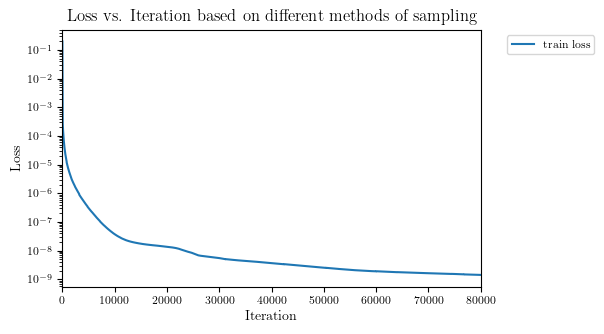

In [18]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,150000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()